In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from train_gtex import *
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from src.train_utils import forward
from src.distributions import *
from src.eval_utils import *
from src.baselines import *
from tqdm import tqdm
from matplotlib_venn import venn3, venn3_circles
import blitzgsea as blitz
from gseapy.plot import barplot, dotplot
from gseapy.plot import gseaplot
import gseapy as gp
from Bio.KEGG import REST
from src.plot_utils import enr_barplot
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.ticker import MultipleLocator
import torch
import os
import networkx as nx
from collections import Counter
sns.set_style("whitegrid")

In [3]:
RESULTS_DIR = 'results'
MODEL_PATH = 'data/normalised_model_default.pth'
GTEX_FILE = 'data/GTEX_data.csv'
METADATA_FILE = 'data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', dest='config', default='configs/default.yaml', type=str)
args, unknown = parser.parse_known_args()

# Initialise wandb
wandb.init(project='multitissue_imputation', config=args.config, mode='disabled')
config = wandb.config
print(config)

{'gpu': 0, 'sweep': False, 'lr': 0.00045568167228053424, 'batch_size': 63, 'epochs': 200, 'patience': 30, 'dropout': 0.17385777664292695, 'bn': True, 'use_demographic_information': True, 'update_edge_attr': False, 'n_graph_layers': 2, 'n_hidden_layers': 1, 'n_hidden_layers_pred': 2, 'n_hidden_layers_prior_var': 0, 'meta_G': 50, 'd_patient': 71, 'd_gene': 48, 'd_edge_attr': 98, 'd_tissue': 120, 'd_edge': 28, 'n_heads': 28, 'beta': 0, 'n_top_genes': None, 'attention_strategy': 'patient', 'metagenes_encoder': 'plain', 'loss_type': 'normal', 'layer': 'gat', 'activation': 'swish', 'norm': 'batch'}


In [6]:
# Split train/val/test
donors = adata.obs['Participant ID'].values
train_donors, test_donors = split_patient_train_test(donors, train_rate=0.8)
train_donors, val_donors = split_patient_train_test(train_donors, train_rate=0.75)
train_mask = np.isin(donors, train_donors)
test_mask = np.isin(donors, test_donors)
val_mask = np.isin(donors, val_donors)
# print(train_patients, val_patients, test_patients)

train_dataset = HypergraphDataset(adata[train_mask], dtype=dtype, disjoint=True, static=False)
val_dataset = HypergraphDataset(adata[val_mask], dtype=dtype, disjoint=True, static=True)
test_dataset = HypergraphDataset(adata[test_mask], dtype=dtype, static=True)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

In [7]:
# Use certain GPU
device = torch.device("cuda:{}".format(config.gpu) if torch.cuda.is_available() else "cpu")

# Select dynamic/static node types
config.update({'static_node_types': {'Tissue': (len(adata.obs['Tissue_idx'].unique()), config.d_tissue),
                            'metagenes': (config.meta_G, config.d_gene)}}, allow_val_change=True)
config.update({'dynamic_node_types': {'Participant ID': (len(adata.obs['Participant ID'].unique()), config.d_patient)}}, allow_val_change=True)

# Model
config.G = adata.shape[-1]
model = HypergraphNeuralNet(config).to(device)  # .double()

In [9]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Plot tissue embeddings

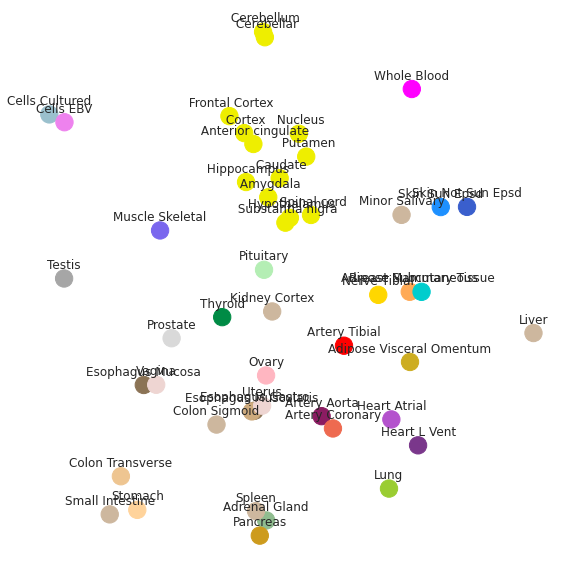

In [ ]:
params = model.params['Tissue'].cpu().detach().numpy()

tissue_params_2d = TSNE(n_components=2,
                        learning_rate='auto',
                        init='random',
                        random_state=0).fit_transform(params)

plt.figure(figsize=(8, 8))
colors = ['#ffaa56', '#cdad22', '#8fbc8f', '#8b1c62', '#ee6a50', '#ff0000', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#00cdcd', '#9ac0cd', '#ee82ee', '#cdb79e', '#eec591', '#8b7355', '#8b7355', '#cdaa7d',
          '#b452cd', '#7a378b', '#cdb79e', '#cdb79e', '#9acd32', '#cdb79e', '#7A67EE', '#FFD700', '#FFB6C1',
          '#CD9B1D', '#B4EEB4', '#D9D9D9', '#3A5FCD', '#1E90FF', '#CDB79E', '#CDB79E', '#FFD39B', '#A6A6A6',
          '#008B45', '#EED5D2', '#EED5D2', '#FF00FF']
ax = plt.gca()
x1, x2 = tissue_params_2d.T
ax.scatter(x1, x2,
           c=colors,
           s=300)

for t, i in tissue_dict.items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                # fontweight='bold',
                # rotation=45,
                ha='center')
plt.axis('off')
# plt.title('Tissue embeddings from multi-tissue imputation model', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/figures/tsne_tissue_embeddings.pdf', bbox_inches='tight');

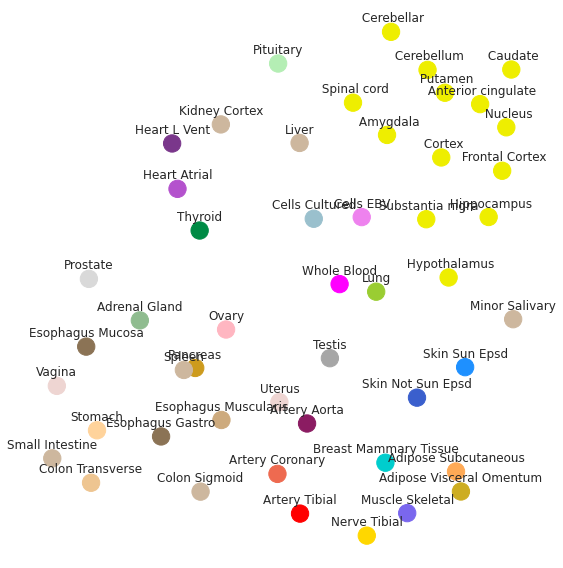

In [ ]:
params = model.params['Tissue'].cpu().detach().numpy()

tissue_params_2d = umap.UMAP().fit_transform(params)

plt.figure(figsize=(8, 8))
colors = ['#ffaa56', '#cdad22', '#8fbc8f', '#8b1c62', '#ee6a50', '#ff0000', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#00cdcd', '#9ac0cd', '#ee82ee', '#cdb79e', '#eec591', '#8b7355', '#8b7355', '#cdaa7d',
          '#b452cd', '#7a378b', '#cdb79e', '#cdb79e', '#9acd32', '#cdb79e', '#7A67EE', '#FFD700', '#FFB6C1',
          '#CD9B1D', '#B4EEB4', '#D9D9D9', '#3A5FCD', '#1E90FF', '#CDB79E', '#CDB79E', '#FFD39B', '#A6A6A6',
          '#008B45', '#EED5D2', '#EED5D2', '#FF00FF']
ax = plt.gca()
x1, x2 = tissue_params_2d.T
ax.scatter(x1, x2,
           c=colors,
           s=300)

for t, i in tissue_dict.items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                # fontweight='bold',
                # rotation=45,
                ha='center')

    
plt.axis('off')
# plt.title('Tissue embeddings from multi-tissue imputation model', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/figures/umap_tissue_embeddings.pdf', bbox_inches='tight');

#### Example: predictions validation set

In [ ]:
d = next(iter(val_loader))

In [ ]:
with torch.no_grad():
    out, node_features = forward(d, model, device, preprocess_fn=None, use_latent_mean=True)
    x_pred = torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean

In [ ]:
x_pred

tensor([[-0.0942,  0.1930, -0.0117,  ..., -0.1641, -0.3732, -0.6240],
        [ 0.5508, -0.1576,  0.3175,  ..., -0.1094, -0.4804, -0.4947],
        [ 0.4153,  0.2576, -0.4670,  ..., -0.1982, -0.7243, -0.7867],
        ...,
        [ 0.0668, -0.1317,  0.6310,  ...,  0.4927, -0.3985,  0.1665],
        [ 0.4716, -1.1849,  1.2882,  ...,  0.1269, -1.7253,  0.4976],
        [-0.1450, -0.4807,  0.5536,  ...,  0.3810,  0.1107,  0.3074]],
       device='cuda:0')

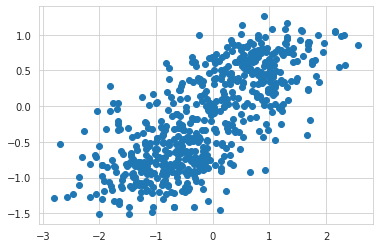

In [ ]:
idx = 9228
plt.scatter(d.x_target[:, idx].cpu().numpy(), x_pred[:, idx].cpu().numpy())

#### Compare to baselines

In [18]:
sample_corr = True

def rho(x, x_pred):
    return np.mean(pearson_correlation_score(x, x_pred, sample_corr=sample_corr))
metric_fns = [rho]
    
model.eval()
score_fn = pearson_correlation_score

validate = False
source_tissues = ['Whole_Blood']    # , 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'
target_tissues = [t for t in adata.obs['Tissue'].unique() if t not in source_tissues]

results_df = pd.DataFrame([], columns=['score', 'source', 'target', 'method'])
for tt in tqdm(target_tissues):
    # Name source and target tissues
    source_name = ', '.join(source_tissues)
    target_name = tt.replace('_', ' ')
    # print(tt)
    
    # Create datasets
    aux_train_dataset = HypergraphDataset(adata[train_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_train_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_train_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()
    
    aux_val_dataset = HypergraphDataset(adata[val_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_val_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_val_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()
    
    aux_test_dataset = HypergraphDataset(adata[test_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_test_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_test_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()

    # Prepare source expression data
    x_train_ = aux_train_dataset.adata_source.layers['x'].toarray()
    x_train_covs = aux_train_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_val_ = aux_val_dataset.adata_source.layers['x'].toarray()
    x_val_covs = aux_val_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_test_ = aux_test_dataset.adata_source.layers['x'].toarray()
    x_test_covs = aux_test_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    
    y_train = aux_train_dataset.adata_target.layers['x'].toarray()
    y_val = aux_val_dataset.adata_target.layers['x'].toarray()
    y_test = aux_test_dataset.adata_target.layers['x'].toarray()
    
    # Append donor metadata
    x_train_aux = aux_train_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_val_aux = aux_val_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_test_aux = aux_test_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_train = np.concatenate((x_train_, x_train_aux), axis=-1)
    x_val = np.concatenate((x_val_, x_val_aux), axis=-1)
    x_test = np.concatenate((x_test_, x_test_aux), axis=-1)
    
    if validate:
        x_test = x_val
        y_test = y_val
        x_test_ = x_val_
        x_test_covs = x_val_covs
    
    # Blood surrogate baseline
    sample_scores = score_fn(y_test, x_test_, sample_corr=sample_corr)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['blood surrogate'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # Mean baseline
    if sample_corr:  # Not defined when sampling units are genes
        means = y_train.mean(axis=0)
        y_test_pred = np.repeat(means[None, :], y_test.shape[0], axis=0)
        sample_scores = score_fn(y_test, y_test_pred, sample_corr=sample_corr)

        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['mean'] * len(scores)})
        results_df = pd.concat([results_df, df_])
    
    # KNN baseline
    x_train_knn = np.concatenate((x_train_, y_train), axis=-1)
    test_nans = np.full((x_test_.shape[0], y_train.shape[1]), np.nan)
    x_test_knn = np.concatenate((x_test_, test_nans), axis=-1)
    x_knn = np.concatenate((x_train_knn, x_test_knn), axis=0)

    x_knn_covs = np.concatenate((x_train_covs, x_test_covs), axis=0)
    knn_imp = impute_knn(x_knn, covariates=x_knn_covs, k=20)
    knn_imp_ = knn_imp[x_train_.shape[0]:, x_train_.shape[1]:]
    sample_scores = score_fn(y_test, knn_imp_, sample_corr=sample_corr)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['kNN'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # TEEBoT baseline.
    y_test_pred = PCA_linear_regression_baseline(x_train, y_train, x_test)
    
    sample_scores = score_fn(y_test, y_test_pred, sample_corr=sample_corr)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['TEEBoT'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # Hypergraph baseline
    aux_train_loader = DataLoader(aux_train_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True, drop_last=True)
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    aux_test_loader = DataLoader(aux_test_dataset, batch_size=len(aux_test_dataset), collate_fn=collate_fn, shuffle=False)

    # Compute predictions and score
    model.eval()
    with torch.no_grad():
        if validate:
            d = next(iter(aux_val_loader))
        else:
            d = next(iter(aux_test_loader))

        out, node_features = forward(d, model, device, preprocess_fn=None)
        y_test_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
        y_test_ = d.x_target.cpu().numpy()
    assert np.allclose(y_test_, y_test)

    sample_scores = score_fn(y_test, y_test_pred, sample_corr=sample_corr)

    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['HYFA (blood)'] * len(scores)})
    results_df = pd.concat([results_df, df_])

    # Hypergraph baseline (all tissues)
    # Select same set of individuals
    aux_val_dataset = HypergraphDataset(adata[val_mask],
                                      obs_source={'Participant ID': list(aux_val_dataset.donor_map.values())},
                                      obs_target={'Tissue': [tt]})
    aux_test_dataset = HypergraphDataset(adata[test_mask],
                                      obs_source={'Participant ID': list(aux_test_dataset.donor_map.values())},
                                      obs_target={'Tissue': [tt]})
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    aux_test_loader = DataLoader(aux_test_dataset, batch_size=len(aux_test_dataset), collate_fn=collate_fn, shuffle=False)

    # Compute predictions and score
    model.eval()
    with torch.no_grad():
        if validate:
            d = next(iter(aux_val_loader))
        else:
            d = next(iter(aux_test_loader))

        out, node_features = forward(d, model, device, preprocess_fn=None)
        y_test_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
        y_test_ = d.x_target.cpu().numpy()

    sample_scores = score_fn(y_test, y_test_pred, sample_corr=sample_corr)

    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['HYFA (all)'] * len(scores)})
    results_df = pd.concat([results_df, df_])

100%|███████████████████████████████████████████████████| 48/48 [10:51<00:00, 13.57s/it]


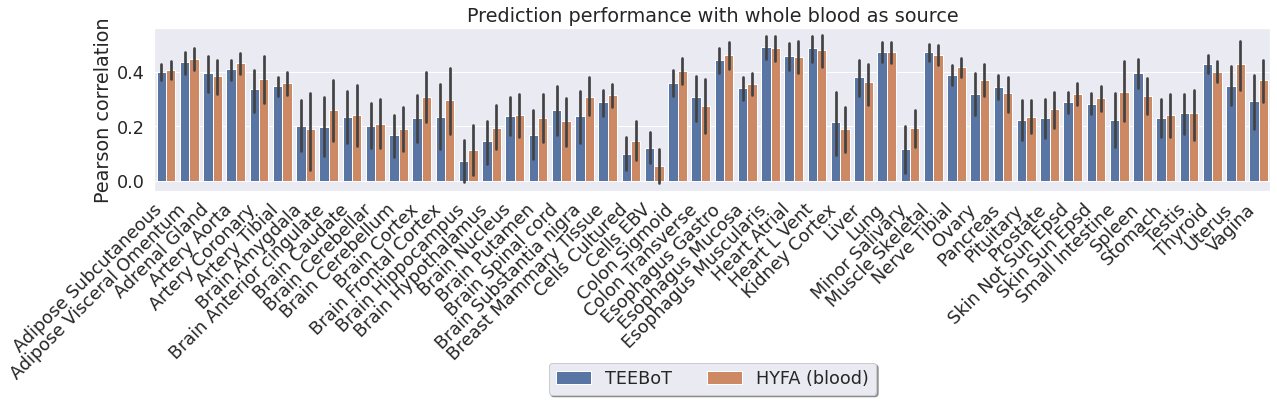

In [13]:
sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 3))
sns.barplot(y='score', x='target', hue='method',
            data=results_df[(results_df['method'] == 'HYFA (blood)') | (results_df['method'] == 'TEEBoT')], order=np.unique(results_df['target']),
            )  # capsize = 0.1
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Prediction performance with whole blood as source')
plt.xlabel('')
plt.ylabel('Pearson correlation');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1), fancybox=True, shadow=True, ncol=2);
# plt.savefig(f'{RESULTS_DIR}/comparison_scores_pertissue_blood_sample_corr{sample_corr}.pdf', bbox_inches='tight')

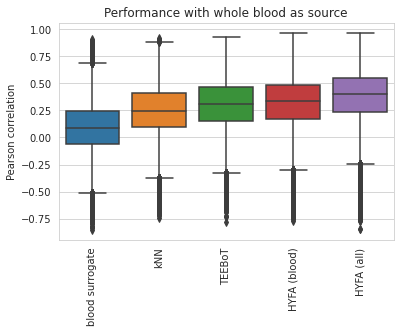

In [ ]:
sns.reset_orig()
sns.set_style("whitegrid")

results_df['score'] = pd.to_numeric(results_df['score'])
ranks = results_df.groupby('method')['score'].median().fillna(0).sort_values().index

sns.boxplot(x='method', y='score', data=results_df, order=ranks)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.title('Performance with whole blood as source');
# plt.savefig(f'{RESULTS_DIR}/aggregated_scores_blood_sample_corr{sample_corr}.pdf', bbox_inches='tight');

#### Comparison with TEEBoT across multiple tissues

In [ ]:
# Pre-load all data for kNN imputation
train_loader_all = DataLoader(train_dataset, batch_size=len(train_dataset), collate_fn=collate_fn, shuffle=False)
d = next(iter(train_loader_all))
y_observed = np.full((len(train_dataset), len(tissue_dict), config.G), np.nan)
y_observed[d.source['Participant ID'].numpy(), d.source['Tissue'].numpy(), :] = d.x_source
y_covs = d.node_features['Participant ID'].cpu().numpy()

In [ ]:
sample_corr = True
score_fn = pearson_correlation_score

source_tissues = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']  
ttissues = set(tissue_dict.keys())
ttissues = [t for t in ttissues if t not in source_tissues]
source_name = 'Accessible tissues'

results_df = pd.DataFrame([], columns=['score', 'source', 'target', 'method'])

for t in ttissues:
    print(', '.join(source_tissues), 'to', t)
    target_tissues = [t]
    target_name = t.replace('_', ' ')
    
    # Train set
    split_mask = train_mask
    valid_donors = []
    donors = adata[split_mask].obs['Participant ID'].unique()
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    aux_train_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    aux_train_loader = DataLoader(aux_train_dataset, batch_size=len(aux_train_dataset), collate_fn=collate_fn, shuffle=False)
    
    # Eval set
    split_mask = test_mask  # np.logical_or(val_mask, test_mask)
    valid_donors = []
    donors = adata[split_mask].obs['Participant ID'].unique()
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    
    aux_val_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    
    it = iter(aux_val_loader)
    val_d = next(it)
    patients_source_val = val_d.source['Participant ID'].cpu().numpy()
    
    print(source_tissues, target_name, len(np.unique(patients_source_val)))
    if len(np.unique(patients_source_val)) >= 25:  # combinations with >= 25 patients
        # Reshape and concatenate multiple tissues
        it = iter(aux_train_loader)
        d = next(it)
        x_source = d.x_source.reshape(-1, len(source_tissues)* d.x_source.shape[-1])
        x_target = d.x_target  # .reshape(-1, len(source_tissues)* d.x_source.shape[-1])
        x_source_val = val_d.x_source.reshape(-1, len(source_tissues) * val_d.x_source.shape[-1])
        x_target_val = val_d.x_target # .reshape(-1, len(source_tissues) * val_d.x_source_val.shape[-1])
        x_source_covs = d.source_features['Participant ID'].cpu().numpy()
        x_source_val_covs  = val_d.source_features['Participant ID'].cpu().numpy()
        x_source_covs = x_source_covs.reshape(-1, len(source_tissues), x_source_covs.shape[-1])[:, 0, :]
        x_source_val_covs = x_source_val_covs.reshape(-1, len(source_tissues), x_source_val_covs.shape[-1])[:, 0, :]
        
        # Blood surrogate baseline
        blood_source_mask = val_d.source['Tissue'] == 48
        scores = score_fn(x_target_val.numpy(), val_d.x_source[blood_source_mask].numpy(), sample_corr=sample_corr)
        print(f'Blood surrogate baseline: \n Mean score: {scores.mean()}')

        # Append results
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['Blood surrogate'] * len(scores)})
        results_df = pd.concat([results_df, df_])

        # Mean baseline
        if sample_corr:
            means = d.x_target.mean(axis=0).numpy()
            y_test_pred = np.repeat(means[None, :], x_target_val.shape[0], axis=0)
            scores = score_fn(x_target_val.numpy(), y_test_pred, sample_corr=sample_corr)
            print(f'Mean baseline: \n Mean score: {scores.mean()}')

            # Append results
            df_ = pd.DataFrame({'score': scores,
                                'source': [source_name] * len(scores),
                                'target': [target_name] * len(scores),
                                'method': ['mean'] * len(scores)})
            results_df = pd.concat([results_df, df_])

        # KNN baseline
        x_train_knn = np.concatenate((x_source, x_target), axis=-1)
        test_nans = np.full((x_source_val.shape[0], x_target.shape[1]), np.nan)
        x_test_knn = np.concatenate((x_source_val, test_nans), axis=-1)
        x_knn = np.concatenate((x_train_knn, x_test_knn), axis=0)

        x_knn_covs = np.concatenate((x_source_covs, x_source_val_covs), axis=0)
        knn_imp = impute_knn(x_knn, covariates=x_knn_covs, k=20)
        knn_imp_ = knn_imp[x_source.shape[0]:, x_source.shape[1]:]
        scores = score_fn(x_target_val.numpy(), knn_imp_, sample_corr=sample_corr)
        print(f'kNN baseline: \n Mean score: {scores.mean()}')

        # Append results
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['kNN'] * len(scores)})
        results_df = pd.concat([results_df, df_])
        
        # TEEBoT
        x_target_pred = PCA_linear_regression_baseline(x_source, x_target, x_source_val,
                                                          x_source_covs=x_source_covs,
                                                          x_source_test_covs=x_source_val_covs)
        scores = score_fn(x_target_val.numpy(), x_target_pred, sample_corr=sample_corr)
        print(f'TEEBoT regression baseline: \n Mean score: {scores.mean()}')

        # Store results
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['TEEBoT'] * len(scores)})
        results_df = pd.concat([results_df, df_])

        # Hypergraph
        with torch.no_grad():
            d = next(iter(aux_val_loader))
            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_pred = out['px_rate'].cpu().numpy()
            y_ = d.x_target.cpu().numpy()
        assert np.allclose(y_, x_target_val)

        scores = score_fn(x_target_val.numpy(), y_pred, sample_corr=sample_corr)
        print(f'Hypergraph neural network (accessible): \n Mean score: {scores.mean()}')

        # Store results
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['HYFA (accessible)'] * len(scores)})
        results_df = pd.concat([results_df, df_])
        
        # Hypergraph baseline (all tissues)
        # Select same set of individuals
        aux_val_dataset_ = HypergraphDataset(adata[split_mask],
                                          obs_source={'Participant ID': list(aux_val_dataset.donor_map.values())},
                                          obs_target={'Tissue': [t]})
        aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_), collate_fn=collate_fn, shuffle=False)

        # Compute predictions and score
        model.eval()
        with torch.no_grad():
            d = next(iter(aux_val_loader_))

            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_val_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
            y_test_ = d.x_target.cpu().numpy()

        scores = score_fn(x_target_val.numpy(), y_val_pred, sample_corr=sample_corr)
        print(f'Hypergraph neural network (all): \n Mean score: {scores.mean()}')

        # Append results
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['HYFA (all)'] * len(scores)})
        results_df = pd.concat([results_df, df_])  

Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Muscle_Skeletal
Selected 552 source and 138 target samples of 138 unique donors
Selected 228 source and 57 target samples of 57 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Muscle Skeletal 57
Blood surrogate baseline: 
 Mean score: 0.08136901259422302
kNN baseline: 
 Mean score: 0.4512161260602997
TEEBoT regression baseline: 
 Mean score: 0.4835994595305857
Hypergraph neural network (accessible): 
 Mean score: 0.5216197371482849
Hypergraph neural network (all): 
 Mean score: 0.5249998569488525
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Brain_Hypothalamus
Selected 92 source and 23 target samples of 23 unique donors
Selected 40 source and 10 target samples of 10 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Brain Hypothalamus 10
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to 

Selected 328 source and 82 target samples of 82 unique donors
Selected 152 source and 38 target samples of 38 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Cells Cultured 38
Blood surrogate baseline: 
 Mean score: 0.029860742390155792
kNN baseline: 
 Mean score: 0.15856470603828407
TEEBoT regression baseline: 
 Mean score: 0.099461166696374
Hypergraph neural network (accessible): 
 Mean score: 0.22684000432491302
Hypergraph neural network (all): 
 Mean score: 0.1791476160287857
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Pancreas
Selected 256 source and 64 target samples of 64 unique donors
Selected 76 source and 19 target samples of 19 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Pancreas 19
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Artery_Aorta
Selected 340 source and 85 target samples of 85 unique donors
Selected 132 source and 33 targe

kNN baseline: 
 Mean score: 0.16475288195725746
TEEBoT regression baseline: 
 Mean score: 0.11859001614558527
Hypergraph neural network (accessible): 
 Mean score: 0.2659114599227905
Hypergraph neural network (all): 
 Mean score: 0.3262670338153839
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Nerve_Tibial
Selected 464 source and 116 target samples of 116 unique donors
Selected 192 source and 48 target samples of 48 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Nerve Tibial 48
Blood surrogate baseline: 
 Mean score: 0.10311292856931686
kNN baseline: 
 Mean score: 0.36566402189620295
TEEBoT regression baseline: 
 Mean score: 0.382556114604322
Hypergraph neural network (accessible): 
 Mean score: 0.4325104057788849
Hypergraph neural network (all): 
 Mean score: 0.42355814576148987
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Testis
Selected 268 source and 67 target samples of 67 unique donors

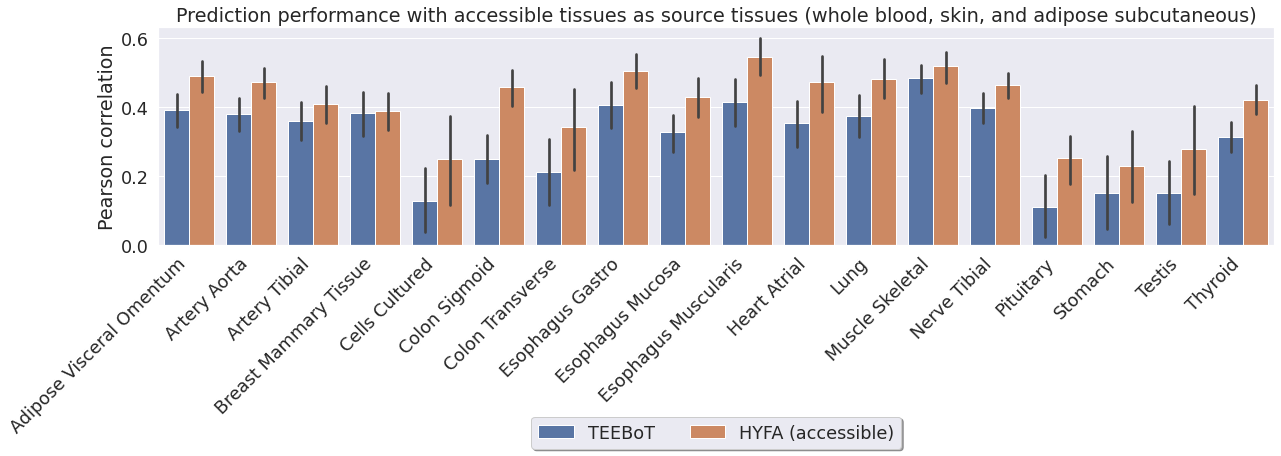

In [ ]:
sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 4))
sns.barplot(y='score', x='target', hue='method', data=results_df[(results_df['method'] == 'HYFA (accessible)') | (results_df['method'] == 'TEEBoT')], order=np.unique(results_df['target']))
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Prediction performance with accessible tissues as source tissues (whole blood, skin, and adipose subcutaneous)')
plt.xlabel('')
plt.ylabel('Pearson correlation');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.75), fancybox=True, shadow=True, ncol=2)
# plt.savefig(f'{RESULTS_DIR}/comparison_accessible_scores_valtest_sample_corr{sample_corr}.pdf', bbox_inches='tight')

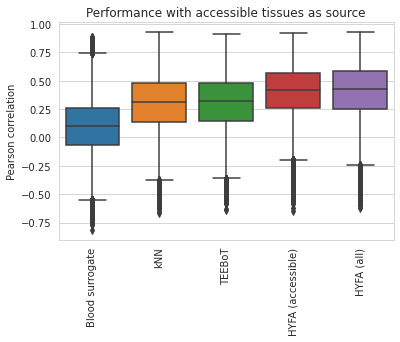

In [ ]:
sns.reset_orig()
sns.set_style("whitegrid")

results_df['score'] = pd.to_numeric(results_df['score'])
ranks = results_df.groupby('method')['score'].median().fillna(0).sort_values().index

sns.boxplot(x='method', y='score', data=results_df, order=ranks)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.title('Performance with accessible tissues as source')
# plt.ylim((-0.75, 0.85))
plt.savefig(f'{RESULTS_DIR}/aggregated_scores_test_accessible_sample_corr{sample_corr}.pdf', bbox_inches='tight');

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/results_pertissue_test_sources_accessible.csv')

In [ ]:
baseline_means = results_df[results_df['method'] == 'TEEBoT'].groupby('target')['score'].mean()
ours_means = results_df[results_df['method'] == 'HYFA (accessible)'].groupby('target')['score'].mean()
(ours_means > baseline_means).sum(), ours_means.size

(38, 38)

#### Increase in performance when multiple accessible tissues are used as source

In [23]:
score_fn = pearson_correlation_score

source_tissues = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']
source_tissues_idxs = [tissue_dict[t] for t in source_tissues]
names = [t.replace('_', ' ') for t in source_tissues] + ['Accessible All']

scores_col = []
source_col = []
target_col = []

# Target tissue
ttissues = set(tissue_dict.keys()) # - set(['Testis', 'Cells_Cultured'])
ttissues = [t for t in ttissues if t not in source_tissues]

for t in ttissues:
    target_tissues = [t]
    target_name = t.replace('_', ' ')
    
    # Get data
    # split_mask = val_mask
    split_mask = np.logical_or(val_mask, test_mask)
    
    donors = adata[split_mask].obs['Participant ID'].unique()

    valid_donors = []
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    
    aux_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    print(len(aux_dataset))
    aux_loader = DataLoader(aux_dataset, batch_size=len(aux_dataset), collate_fn=collate_fn, shuffle=False)
    
    it = iter(aux_loader)
    d = next(it)
    patients_source = d.source['Participant ID']
    tissues_source = d.source['Tissue']
    
    print(source_tissues, target_name, len(np.unique(patients_source)))
    if len(np.unique(patients_source)) >= 25:
        # Evaluate performance when increasingly adding more tissue types
        cum_source_tissues_idxs = []
        # selected_tissues = [[tissue_dict[t]] for t in source_tissues] + [[tissue_dict[t] for t in source_tissues]]
        selected_tissues = [[t] for t in source_tissues] + [source_tissues]
        print(selected_tissues)
        
        for source_t, name in zip(selected_tissues, names):
            cum_source_tissues_idxs = source_t
            
            # print(source_t, target_tissues)
            # Select samples from subset of individuals having all selected tissues
            aux_dataset_ = HypergraphDataset(adata = aux_dataset.adata_source,
                                             adata_target = aux_dataset.adata_target,
                                             obs_source={'Tissue': source_t},
                                             obs_target={'Tissue': target_tissues},
                                             static=True)
            aux_loader_ = DataLoader(aux_dataset_, batch_size=len(aux_dataset_), collate_fn=collate_fn, shuffle=False)

            with torch.no_grad():
                d = next(iter(aux_loader_))
                out, node_features = forward(d, model, device, preprocess_fn=None)
                y_pred = out['px_rate'].cpu().numpy()
                y_ = d.x_target.cpu().numpy()
                
            gene_scores = score_fn(y_, y_pred)
            sample_scores = score_fn(y_, y_pred, sample_corr=True)
            print(f'Hypergraph neural network: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

            scores = sample_scores
            scores_col.extend(scores)
            source_col.extend([name] * len(scores))
            target_col.extend([target_name] * len(scores))

Selected 376 source and 94 target samples of 94 unique donors
94
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Thyroid 94
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.38935649394989014. Mean score per sample: 0.3894377648830414
Hypergraph neural network: 
 Mean score per gene: 0.3623402416706085. Mean score per sample: 0.36765673756599426
Hypergraph neural network: 
 Mean score per gene: 0.3715164363384247. Mean score per sample: 0.38106828927993774
Hypergraph neural network: 
 Mean score per gene: 0.37241700291633606. Mean score per sample: 0.3748319447040558
Hypergraph neural network: 
 Mean score per gene: 0.4135224223136902. Mean score per sample: 0.4165612459182739
Selected 260 source and 65 target samples of 65 unique donors
65
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd'

Hypergraph neural network: 
 Mean score per gene: 0.17391106486320496. Mean score per sample: 0.18541717529296875
Hypergraph neural network: 
 Mean score per gene: 0.1934639811515808. Mean score per sample: 0.21039365231990814
Hypergraph neural network: 
 Mean score per gene: 0.23097698390483856. Mean score per sample: 0.24440805613994598
Selected 144 source and 36 target samples of 36 unique donors
36
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Small Intestine 36
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.4094039499759674. Mean score per sample: 0.37554049491882324
Hypergraph neural network: 
 Mean score per gene: 0.3319949209690094. Mean score per sample: 0.287898987531662
Hypergraph neural network: 
 Mean score per gene: 0.3428869843482971. Mean score per sample: 0.3296914696693

Hypergraph neural network: 
 Mean score per gene: 0.2887195646762848. Mean score per sample: 0.2532208263874054
Selected 72 source and 18 target samples of 18 unique donors
18
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Kidney Cortex 18
Selected 80 source and 20 target samples of 20 unique donors
20
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Uterus 20
Selected 452 source and 113 target samples of 113 unique donors
113
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Muscle Skeletal 113
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.47459831833839417. Mean score per sample: 0.47330212593078613
Hypergraph neural network: 
 Mean score per gene: 0.47451460361480713. Mean score per sample: 0.48046982288360596
Hypergraph neural 

Hypergraph neural network: 
 Mean score per gene: 0.24659349024295807. Mean score per sample: 0.21022772789001465
Hypergraph neural network: 
 Mean score per gene: 0.23854421079158783. Mean score per sample: 0.21568208932876587
Hypergraph neural network: 
 Mean score per gene: 0.2840859889984131. Mean score per sample: 0.25158220529556274
Selected 220 source and 55 target samples of 55 unique donors
55
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Heart L Vent 55
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.4378001093864441. Mean score per sample: 0.4567100405693054
Hypergraph neural network: 
 Mean score per gene: 0.41191956400871277. Mean score per sample: 0.4221787750720978
Hypergraph neural network: 
 Mean score per gene: 0.39208680391311646. Mean score per sample: 0.42501971125602

Hypergraph neural network: 
 Mean score per gene: 0.26646655797958374. Mean score per sample: 0.26038211584091187
Selected 256 source and 64 target samples of 64 unique donors
64
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Esophagus Gastro 64
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.45910516381263733. Mean score per sample: 0.44260716438293457
Hypergraph neural network: 
 Mean score per gene: 0.41202083230018616. Mean score per sample: 0.4236747622489929
Hypergraph neural network: 
 Mean score per gene: 0.43563729524612427. Mean score per sample: 0.42934319376945496
Hypergraph neural network: 
 Mean score per gene: 0.45170164108276367. Mean score per sample: 0.4593910574913025
Hypergraph neural network: 
 Mean score per gene: 0.4816533625125885. Mean score per sample: 0.477836370

In [29]:
Counter(results_df[results_df['source'] == 'Accessible All']['target'])

Counter({'Thyroid': 94,
         'Artery Aorta': 65,
         'Lung': 78,
         'Adipose Visceral Omentum': 93,
         'Heart Atrial': 67,
         'Ovary': 27,
         'Pancreas': 45,
         'Nerve Tibial': 95,
         'Cells Cultured': 71,
         'Small Intestine': 36,
         'Liver': 37,
         'Brain Putamen': 31,
         'Breast Mammary Tissue': 66,
         'Adrenal Gland': 37,
         'Pituitary': 50,
         'Brain Cortex': 42,
         'Brain Hippocampus': 32,
         'Minor Salivary': 26,
         'Muscle Skeletal': 113,
         'Artery Coronary': 28,
         'Artery Tibial': 93,
         'Prostate': 40,
         'Testis': 61,
         'Brain Hypothalamus': 27,
         'Esophagus Mucosa': 79,
         'Esophagus Muscularis': 73,
         'Brain Cerebellar': 30,
         'Heart L Vent': 55,
         'Spleen': 36,
         'Brain Nucleus': 34,
         'Stomach': 53,
         'Cells EBV': 32,
         'Colon Transverse': 60,
         'Colon Sigmoid': 66,
 

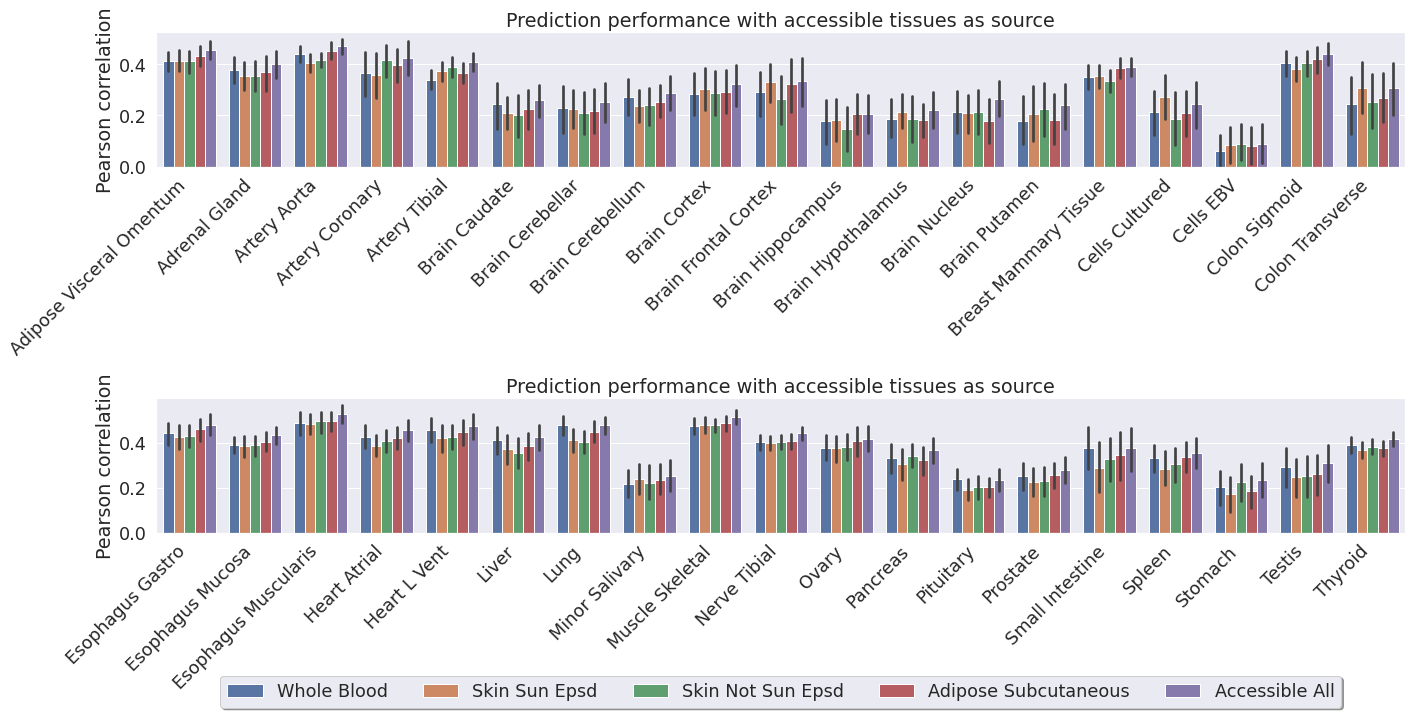

In [24]:
results_df = pd.DataFrame({'score': scores_col, 'source': source_col, 'target': target_col})
mid_point = 19
tt_1 = sorted(results_df['target'].unique())[:mid_point]
tt_2 = sorted(results_df['target'].unique())[mid_point:]
results_df_1 = results_df[results_df['target'].isin(tt_1)]
results_df_2 = results_df[results_df['target'].isin(tt_2)]

sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 10))

plt.subplot(2, 1, 1)
sns.barplot(y='score', x='target', hue='source', data=results_df_1, order=np.unique(results_df_1['target']))
plt.legend([], [], frameon=False)
plt.xticks(rotation=45, ha='right')
plt.title('Prediction performance with accessible tissues as source')
plt.xlabel('')
plt.ylabel('Pearson correlation');

plt.subplot(2, 1, 2)
sns.barplot(y='score', x='target', hue='source', data=results_df_2, order=np.unique(results_df_2['target']))
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.title('Prediction performance with accessible tissues as source')
plt.xlabel('')
plt.ylabel('Pearson correlation');
plt.tight_layout(pad=1.0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1), fancybox=True, shadow=True, ncol=5)

# plt.savefig(f'figures/scores_pertissue_HYFA_accessible.pdf', bbox_inches='tight')

In [25]:
results_df.to_csv(f'{RESULTS_DIR}/results_pertissue_HYFA_sources_accessible.csv')

#### Metagene-factors GSEA

In [ ]:
library = blitz.enrichr.get_library('KEGG_2021_Human')

In [ ]:
metagene_w = model.metagenes_encoder.encoder[0].weight.detach().cpu().numpy()
metagene_w = metagene_w.reshape((config.meta_G, -1, config.G))

In [ ]:
n_factors = config.d_edge_attr
n_metagenes = config.meta_G

results_df = pd.DataFrame()
for f in range(n_factors):
    print(f'Factor={f}')
    for m in range(n_metagenes):
        gene_idxs = np.argsort(metagene_w[m, f, :])[::-1]
        gene_names = adata.var['Symbol'][gene_idxs].values
        gene_values = metagene_w[m, f, gene_idxs]
        signature = pd.DataFrame({0: gene_names, 1: gene_values})
        
        result = blitz.gsea(signature, library, permutations=2000, signature_cache=True)
        result['Factor'] = f
        result['Metagene'] = m
        results_df = pd.concat([results_df, result], axis=0)

Factor=0
Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 836.97it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 854.51it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 845.79it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 791.93it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 856.89it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 833.80it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 760.74it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 683.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 677.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 636.74it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 705.21it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 655.73it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 743.31it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 826.25it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 779.76it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 779.01it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 719.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 775.06it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 760.39it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 792.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 822.16it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 838.54it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 795.92it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 774.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 762.31it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 812.97it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 819.26it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 811.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 825.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 843.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 833.43it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 845.02it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 852.59it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 854.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 874.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 858.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 891.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 831.02it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.17it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.38it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 829.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 855.04it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 851.48it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 902.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 864.05it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 863.58it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 870.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.62it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 828.40it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 850.57it/s]


Factor=1
Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 764.59it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 872.89it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 848.23it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 880.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 815.33it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 831.45it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 825.47it/s]


Use cached anchor parameters


Enrichment :  76%|██████████████████████████████████████████████████████████████████████▎                      | 242/320 [00:00<00:00, 807.49it/s]

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/blitz_gsea_results.csv')

In [ ]:
significant_results_df = results_df[results_df['fdr'] < 0.05]
significant_results_df

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene
Term,,,,,,,,,
PROTEIN PROCESSING IN ENDOPLASMIC RETICULUM,-0.368889,-4.047468,0.000052,0.016126,0.016257,151,"SEC31B,SEL1L,SSR2,PREB,LMAN1,HSPA1A,EDEM2,HSPB...",0,0
ANTIGEN PROCESSING AND PRESENTATION,-0.523647,-3.898660,0.000097,0.029917,0.010852,51,"B2M,HLA-DMB,CTSB,HLA-F,CREB1,HLA-B,CIITA,HSPA1...",0,2
PHAGOSOME,-0.391181,-3.843261,0.000121,0.037407,0.010852,116,"SFTPA1,HLA-DMB,FCGR3B,HLA-F,ITGB5,VAMP3,HLA-B,...",0,2
STAPHYLOCOCCUS AUREUS INFECTION,-0.542746,-3.830819,0.000128,0.039312,0.010852,45,"HLA-DMB,FCGR3B,C1QC,SELPLG,KRT15,ITGAL,C2,C1QB...",0,2
TOXOPLASMOSIS,-0.415903,-3.811293,0.000138,0.042482,0.010852,88,"HLA-DMB,MYD88,MAPK13,CIITA,MAPK14,TLR2,LAMA5,M...",0,2
...,...,...,...,...,...,...,...,...,...
HERPES SIMPLEX VIRUS 1 INFECTION,0.294076,3.486818,0.000489,0.142318,0.023063,409,"ZNF555,ZNF600,IL12A,ZNF613,IRF7,ZNF251,B2M,ZNF...",97,49
ALLOGRAFT REJECTION,0.675899,3.461735,0.000537,0.155128,0.023063,20,"HLA-DMB,IL12A,TNF,HLA-A,HLA-DQB1,HLA-E,HLA-DMA...",97,49
GRAFT-VERSUS-HOST DISEASE,0.695564,3.437282,0.000588,0.168526,0.023063,19,"IL6,HLA-DMB,TNF,HLA-A,HLA-DQB1,HLA-E,HLA-DMA,H...",97,49


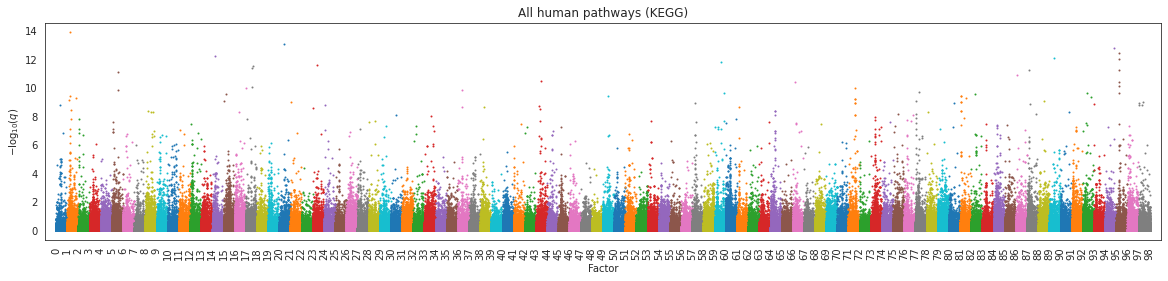

In [ ]:
sns.set_style('white')
plt.figure(figsize=(20, 4))
ax = plt.gca()
cmap = plt.get_cmap('tab10')

n_metagenes = 50
n_factors = 99
for f in range(n_factors):
    df = results_df[results_df['Factor'] == f]
    for x in range(n_metagenes):
        df_meta = df[df['Metagene'] == x]
        y = -np.log10(df_meta['fdr'].values)
        x_pos = [f + (x/n_metagenes)] * len(y)
        ax.scatter(x_pos, y, s=1, color=cmap(f % 10))
plt.xlabel('Factor')
plt.ylabel('$-\log_{10}(q)$')
plt.title('All human pathways (KEGG)')
plt.xticks(list(range(n_factors)))
plt.xticks(rotation = 90)
plt.xlim((-1, 99))
# plt.axhline(y = -np.log10(0.05), color = 'gray', linestyle = '--', linewidth=1)
plt.savefig(f'{RESULTS_DIR}/figures/manhattan_blitzgsea.pdf', bbox_inches='tight');
# plt.savefig('overleaf/figures/manhattan_blitzgsea.png', bbox_inches='tight');

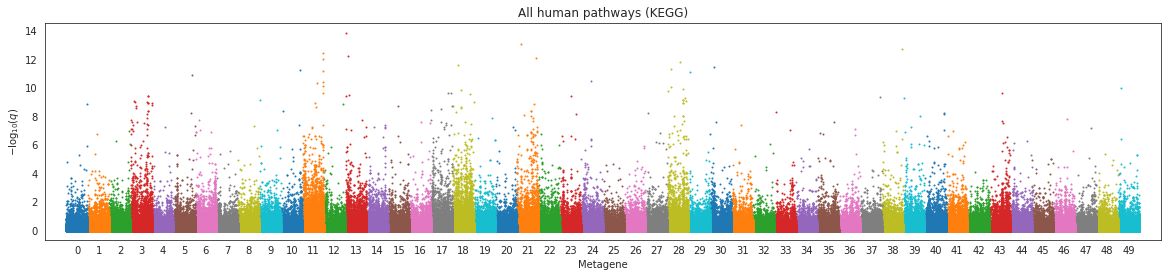

In [ ]:
sns.set_style('white')
plt.figure(figsize=(20, 4))
ax = plt.gca()
cmap = plt.get_cmap('tab10')

n_metagenes = 50
n_factors = 99
for f in range(n_factors):
    df = results_df[results_df['Factor'] == f]
    for x in range(n_metagenes):
        df_meta = df[df['Metagene'] == x]
        y = -np.log10(df_meta['fdr'].values)
        x_pos = [x + (f/n_factors)] * len(y)
        ax.scatter(x_pos, y, s=1, color=cmap(x % 10))
plt.xlabel('Metagene')
plt.ylabel('$-\log_{10}(q)$')
plt.title('All human pathways (KEGG)')
locs = list(range(n_metagenes))
# plt.xticks(locs, rotation = 90)
plt.gca().set_xticklabels('')
plt.gca().set_xticks(np.array(locs) + 0.5, minor=True)
plt.gca().set_xticklabels(locs, minor=True)
plt.xlim((-1, 51))
# plt.axhline(y = -np.log10(0.05), color = 'gray', linestyle = '--', linewidth=1)
# plt.savefig(f'{RESULTS_DIR}/figures/manhattan_metagenes_blitzgsea.pdf', bbox_inches='tight');
plt.savefig(f'{RESULTS_DIR}/figures/manhattan_metagenes_blitzgsea.pdf', bbox_inches='tight');
# plt.savefig('overleaf/figures/manhattan_blitzgsea.png', bbox_inches='tight');

#### Families of pathways

In [ ]:
def list_KEGG_human_pathways():
    lines = REST.kegg_list('pathway', 'hsa').readlines()
    symbols = np.array([s.split('\t')[0].split(':')[-1] for s in lines])
    description = np.array([s.split('\t')[1].rstrip() for s in lines])
    return symbols, description

def get_pathway_class(pathway):
    pathway_file = REST.kegg_get(pathway).read()  # query and read each pathway
    
    pathway_class = None 
    for line in pathway_file.rstrip().split('\n'):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == '':
            current_section = section

        if current_section == 'CLASS':
            if pathway_class is not None:
                print('Pathway belongs to more than one class')
                break
            pathway_class = line[12:]
                
    return pathway_class

In [ ]:
hp, hp_desc = list_KEGG_human_pathways()

In [ ]:
results_df_significant = results_df[results_df['fdr'] < 0.05].copy()
pathway_classes_dict = {}
for term in tqdm(np.unique(results_df_significant.index)):
    pathway_idx = np.where([term.lower() in p.lower() for p in hp_desc])[0]
    if len(pathway_idx) == 0:
        pathway_classes_dict[term] = 'Unknown'
    else:
        pathway_idx = pathway_idx[0]
        pathway_code = hp[pathway_idx]
        pathway_classes_dict[term] = get_pathway_class(pathway_code)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [05:55<00:00,  1.20s/it]


In [ ]:
families_dict = {k: p.split(';')[0] for k, p in pathway_classes_dict.items()}
classes_dict = {k: p.split(';')[1].lstrip() if len(p.split(';')) > 1 else p.split(';')[0] for k, p in pathway_classes_dict.items()}

In [ ]:
results_df_significant['class'] = results_df_significant.index.map(classes_dict)
results_df_significant['Category'] = results_df_significant.index.map(families_dict)

In [ ]:
def f(a):
    indexes = np.unique(a, return_index=True)[1]
    return a[np.sort(indexes)]

sorted_idxs = np.argsort(results_df_significant['Category'].values)

f(np.array(results_df_significant['class'].values))

array(['Folding, sorting and degradation', 'Immune system',
       'Transport and catabolism', 'Infectious disease: bacterial',
       'Infectious disease: parasitic', 'Immune disease',
       'Cardiovascular disease', 'Endocrine and metabolic disease',
       'Cellular community - eukaryotes', 'Translation',
       'Carbohydrate metabolism', 'Environmental adaptation',
       'Endocrine system', 'Energy metabolism',
       'Neurodegenerative disease', 'Infectious disease: viral',
       'Lipid metabolism', 'Amino acid metabolism',
       'Cancer: specific types', 'Unknown',
       'Development and regeneration', 'Nervous system',
       'Circulatory system', 'Replication and repair', 'Transcription',
       'Signal transduction', 'Signaling molecules and interaction',
       'Cell motility', 'Digestive system', 'Cancer: overview',
       'Excretory system', 'Glycan biosynthesis and metabolism', 'Aging',
       'Cell growth and death', 'Substance dependence',
       'Metabolism of othe

In [ ]:
sorted_classes = []
for c in np.array(results_df_significant['class'].values)[sorted_idxs]:
    if c not in sorted_classes:
        sorted_classes.append(c)
sorted_classes

['Transport and catabolism',
 'Cell growth and death',
 'Cellular community - eukaryotes',
 'Cell motility',
 'Signaling molecules and interaction',
 'Signal transduction',
 'Membrane transport',
 'Translation',
 'Replication and repair',
 'Folding, sorting and degradation',
 'Transcription',
 'Cancer: specific types',
 'Cancer: overview',
 'Cardiovascular disease',
 'Infectious disease: parasitic',
 'Neurodegenerative disease',
 'Infectious disease: bacterial',
 'Infectious disease: viral',
 'Immune disease',
 'Endocrine and metabolic disease',
 'Substance dependence',
 'Lipid metabolism',
 'Energy metabolism',
 'Glycan biosynthesis and metabolism',
 'Xenobiotics biodegradation and metabolism',
 'Amino acid metabolism',
 'Carbohydrate metabolism',
 'Nucleotide metabolism',
 'Metabolism of other amino acids',
 'Metabolism of cofactors and vitamins',
 'Metabolism of terpenoids and polyketides',
 'Development and regeneration',
 'Digestive system',
 'Immune system',
 'Sensory system',
 '

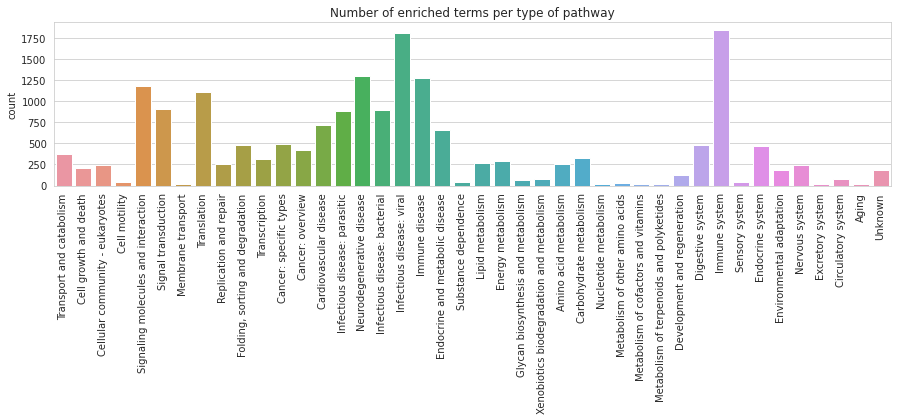

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 3))
sns.countplot(x='class', # hue='Category',
            data=results_df_significant.reset_index(),
            # height=4,
            # aspect=4,
            ax=plt.gca(),
            order=sorted_classes)
# plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.9), fancybox=True, shadow=True, ncol=4)
plt.xticks(rotation=90);
plt.xlabel('')
# plt.ylabel('')
plt.title('Number of enriched terms per type of pathway')
# plt.savefig(f'{RESULTS_DIR}/figures/enriched_terms_pathway_type_blitzgsea.pdf', bbox_inches='tight');

In [ ]:
results_df_significant[results_df_significant['class'] == 'Neurodegenerative disease']

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene,class,Category
Term,,,,,,,,,,,
PARKINSON DISEASE,-0.328745,-3.493032,4.775694e-04,0.139286,0.037489,192,"MCU,COX5B,PSMD3,DAXX,CASP9,NDUFA6,NDUFA9,UBC,C...",0,9,Neurodegenerative disease,Human Diseases
AMYOTROPHIC LATERAL SCLEROSIS,-0.285781,-3.773130,1.612126e-04,0.049365,0.016874,272,"COX7A2L,XBP1,SIGMAR1,NXF1,MAPK13,NDUFA13,PSMD6...",0,14,Neurodegenerative disease,Human Diseases
PARKINSON DISEASE,-0.435069,-5.134704,2.825881e-07,0.000089,0.000030,192,"TUBA1B,PSMC1,NDUFV3,UBA1,XBP1,NDUFA12,KIF5A,ND...",0,18,Neurodegenerative disease,Human Diseases
ALZHEIMER DISEASE,-0.331530,-5.053234,4.343918e-07,0.000136,0.000034,273,"FADD,TUBA1B,PSMC1,BACE1,NDUFV3,MAPK3,XBP1,NDUF...",0,18,Neurodegenerative disease,Human Diseases
HUNTINGTON DISEASE,-0.364913,-4.636326,3.546567e-06,0.001113,0.000153,226,"TGM2,TUBA1B,PSMC1,NDUFV3,TAF4B,DCTN3,NDUFA12,K...",0,18,Neurodegenerative disease,Human Diseases
...,...,...,...,...,...,...,...,...,...,...,...
AMYOTROPHIC LATERAL SCLEROSIS,-0.288168,-3.946484,7.930728e-05,0.024596,0.006226,272,"SRSF3,PSMD6,RAC1,SEC13,MAPK14,NDUFA9,PSMD14,TO...",97,17,Neurodegenerative disease,Human Diseases
PARKINSON DISEASE,-0.359977,-3.745854,1.797811e-04,0.054892,0.014113,192,"SDHD,PSMD6,NDUFC2,PSMD2,NDUFB10,PSMD7,PSMB4,AD...",97,18,Neurodegenerative disease,Human Diseases
ALZHEIMER DISEASE,-0.281911,-3.548813,3.869718e-04,0.114438,0.024302,273,"SDHD,PSMD6,CSNK1A1,NDUFC2,FZD4,PSMD2,NDUFB10,C...",97,18,Neurodegenerative disease,Human Diseases


#### FDR neurodegenerative

In [ ]:
cutoff = 0.05
aggregated_df = pd.DataFrame()
for m in range(50):
    df = results_df[results_df['Metagene'] == m].reset_index()[['Term', 'fdr', 'Factor']].set_index(['Term', 'Factor']).unstack()
    aggregated_df[m] = df.min(axis=1)

In [ ]:
neurodegenerative_pathways = ['PATHWAYS OF NEURODEGENERATION',
                              'AMYOTROPHIC LATERAL SCLEROSIS', 
                              'ALZHEIMER DISEASE',
                              'PARKINSON DISEASE',
                              'HUNTINGTON DISEASE',
                              'PRION DISEASE',
                              'SPINOCEREBELLAR ATAXIA']

min_fdr_per_term = aggregated_df.min(axis=1)
mean_fdr_per_term = aggregated_df.mean(axis=1)
df = aggregated_df[min_fdr_per_term < 0.05]
mask = [s in neurodegenerative_pathways for s in df.index]  
df = df[mask]
fdr_mask = df.values < 0.05
df = -np.log10(df + 1e-10)

In [ ]:
sum([s in neurodegenerative_pathways for s in results_df[results_df['fdr'] < 0.05].index])

2109

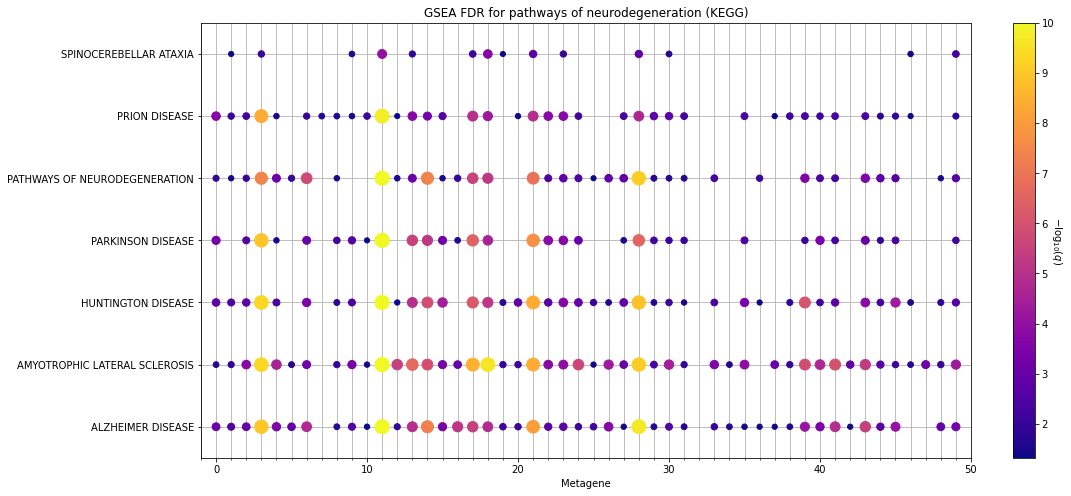

In [ ]:
sns.reset_orig()
x = np.arange(50)
y = np.arange(df.shape[0])
x_, y_ = np.meshgrid(x, y)
sizes = 20*df.values  # 0.01/(df.values+1e-5)

sizes = sizes[fdr_mask]
x_ = x_[fdr_mask]
y_ = y_[fdr_mask]
c = df.values[fdr_mask]

plt.figure(figsize=(15, 8))
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize()
plt.scatter(x_.flatten(), y_.flatten(), s=sizes, c=c, norm=norm, cmap=cmap)
plt.yticks(ticks=y, labels=df.index.values)
cbar = plt.colorbar(fraction=0.03)
cbar.set_label('$-\log_{10}(q)$', rotation=270, labelpad=10)

minorLocator = MultipleLocator(base=1.0)
plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gca().grid(which='both')
plt.gca().set_axisbelow(True)
plt.xlim(-1, 50)
plt.ylim(-0.5, 6.5)

plt.xlabel('Metagene')
plt.title('GSEA FDR for pathways of neurodegeneration (KEGG)')
plt.savefig(f'{RESULTS_DIR}/figures/fdr_scatter_metagenes_neurodegeneration_blitzgsea.png', bbox_inches='tight');

#### FDR signaling

In [ ]:
cutoff = 0.05
aggregated_df = pd.DataFrame()
for f in range(99):
    df = results_df[results_df['Factor'] == f].reset_index()[['Term', 'fdr', 'Metagene']].set_index(['Term', 'Metagene']).unstack()
    aggregated_df[f] = df.min(axis=1)

In [ ]:
signaling_pathways = [c for c, f in classes_dict.items() if f == 'Signaling molecules and interaction' or f == 'Signal transduction' or f == 'Membrane transport']

min_fdr_per_term = aggregated_df.min(axis=1)
mean_fdr_per_term = aggregated_df.mean(axis=1)
df = aggregated_df[min_fdr_per_term < 0.05]
mask = [s in signaling_pathways for s in df.index]  
df = df[mask]
fdr_mask = df.values < 0.05
df = -np.log10(df + 1e-10)

In [ ]:
sum([s in signaling_pathways for s in results_df[results_df['fdr'] < 0.05].index])

2109

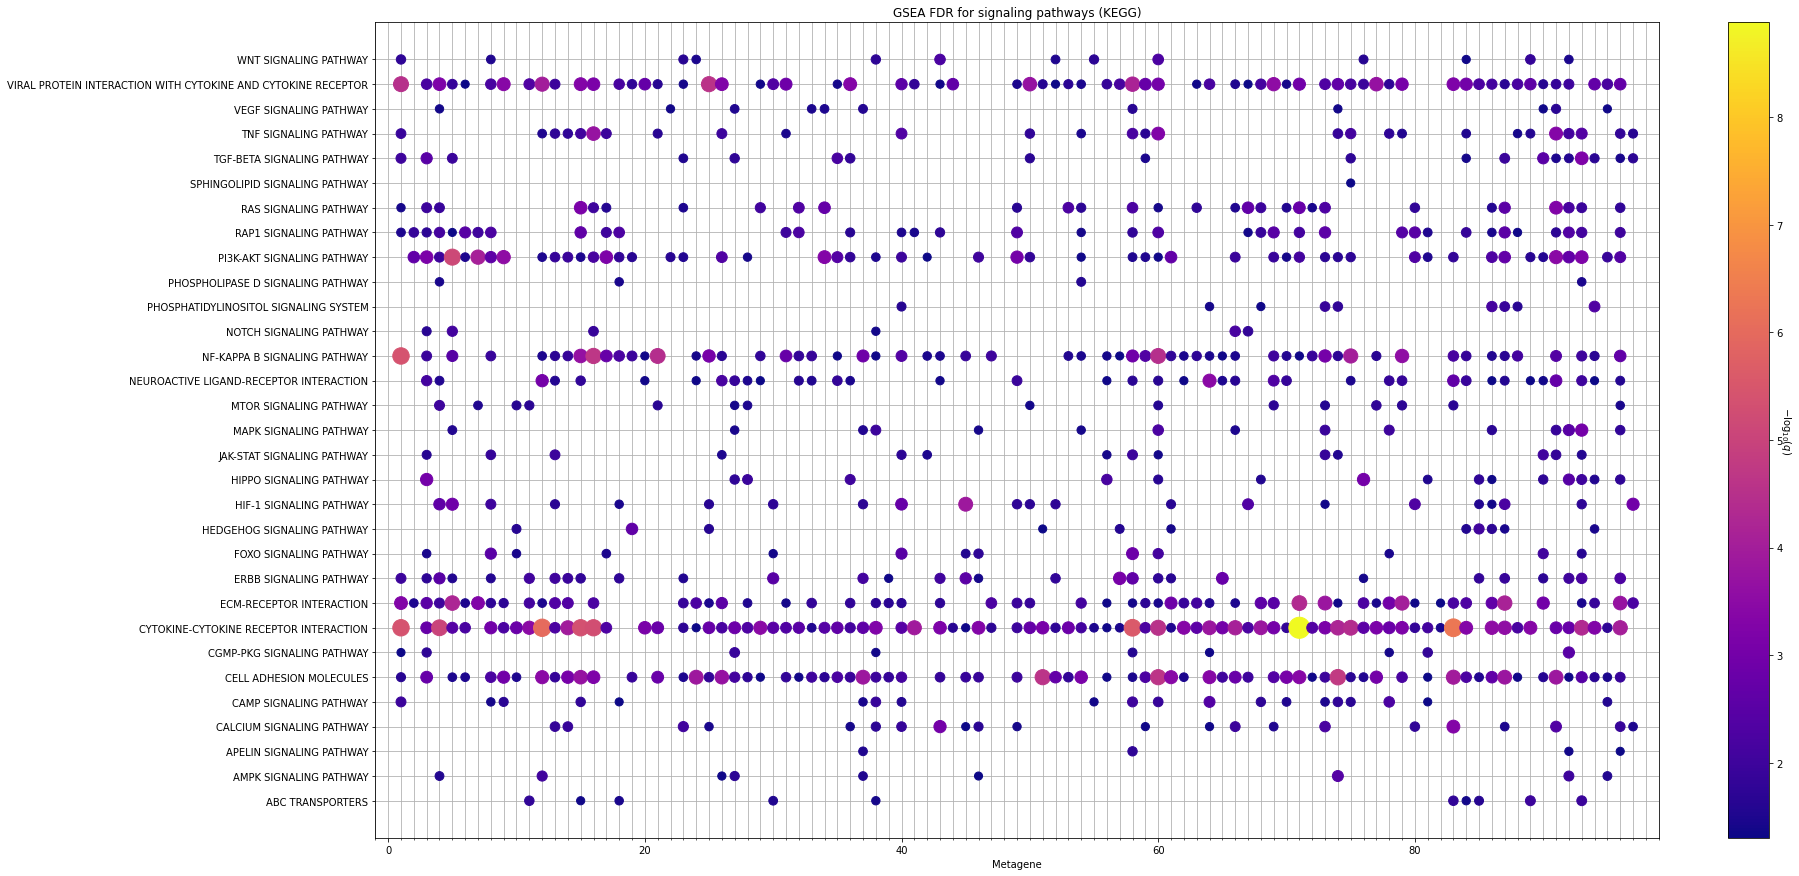

In [ ]:
sns.reset_orig()
x = np.arange(99)
y = np.arange(df.shape[0])
x_, y_ = np.meshgrid(x, y)
sizes = 50*df.values  # 0.01/(df.values+1e-5)

sizes = sizes[fdr_mask]
x_ = x_[fdr_mask]
y_ = y_[fdr_mask]
c = df.values[fdr_mask]

plt.figure(figsize=(25, 15))
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize()
plt.scatter(x_.flatten(), y_.flatten(), s=sizes, c=c, norm=norm, cmap=cmap)
plt.yticks(ticks=y, labels=df.index.values)
cbar = plt.colorbar(fraction=0.03)
cbar.set_label('$-\log_{10}(q)$', rotation=270, labelpad=10)

minorLocator = MultipleLocator(base=1.0)
plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gca().grid(which='both')
plt.gca().set_axisbelow(True)
plt.xlim(-1, 99)
# plt.ylim(-0.5, 6.5)

plt.xlabel('Metagene')
plt.title('GSEA FDR for signaling pathways (KEGG)')
plt.savefig(f'{RESULTS_DIR}/figures/fdr_scatter_factors_signaling_blitzgsea.png', bbox_inches='tight');

#### Neurodegenerative

In [ ]:
subject_df = pd.read_csv(METADATA_FILE, delimiter='\t')
subject_df = subject_df.set_index('SUBJID')

In [ ]:
aux_val_dataset_ = HypergraphDataset(adata,
                                  obs_source={'Tissue': ['Brain_Cortex']})
aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_),
                             collate_fn=collate_fn, shuffle=False)

# Compute predictions and score
model.eval()
with torch.no_grad():
    d = next(iter(aux_val_loader_))
    d = d.to(device)
    x_source = d.x_source
    x_source = model.encode_metagenes(x_source)

x_source = x_source.detach().cpu().numpy()
participant_idxs = d.source['Participant ID'].detach().cpu().numpy()
participant_idxs = [aux_val_dataset_.donor_map[p] for p in participant_idxs]

In [ ]:
with open('results/encoded_metagenes_brain_cortex.npy', 'wb') as f:
    np.save(f, x_source)

with open('results/participant_idxs_brain_cortex.npy', 'wb') as f:
    np.save(f, participant_idxs)

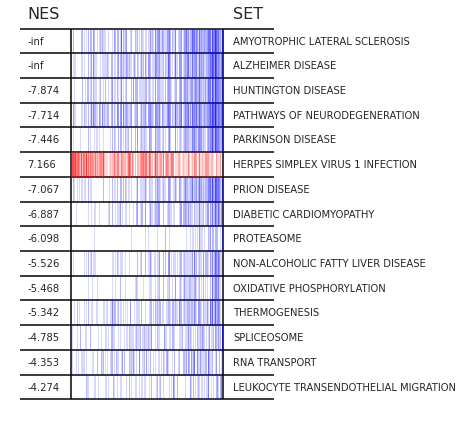

In [ ]:
factor_id = 95
metagene_idx = 11
gene_idxs = np.argsort(metagene_w[metagene_idx, factor_id, :])[::-1]
gene_names = adata.var['Symbol'][gene_idxs].values
gene_values = metagene_w[metagene_idx, factor_id, gene_idxs]
signature = pd.DataFrame({0: gene_names, 1: gene_values})
# result = blitz.gsea(signature, library, permutations=100)

df = results_df[(results_df['Factor'] == factor_id) & (results_df['Metagene'] == metagene_idx)]
fig = blitz.plot.top_table(signature, library, df, n=15)

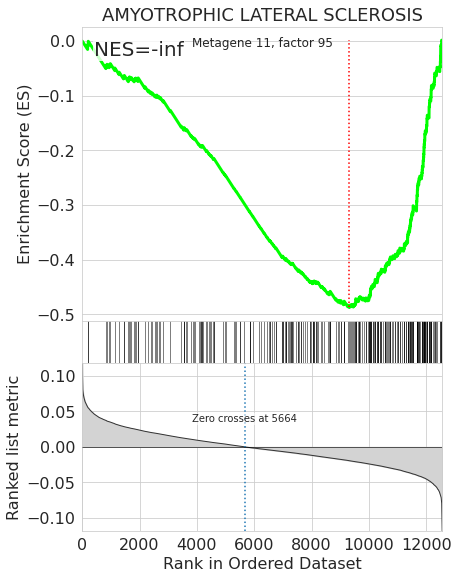

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[0], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))

(Counter({0: 198, 1: 6, 99: 1}), Counter({0: 929, 1: 17, 99: 2}))

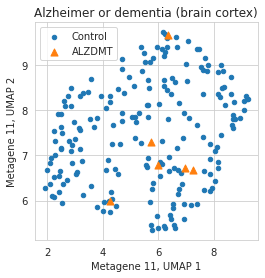

In [ ]:
key = 'MHALZDMT'
x = x_source[:, 11, :]

x_2d = umap.UMAP(random_state=0).fit_transform(x)

plt.figure(figsize=(4, 4))
y = subject_df.loc[participant_idxs][key]
plt.scatter(x_2d[y==0, 0], x_2d[y==0, 1], s=20, cmap=matplotlib.cm.summer, label='Control')
plt.gca().scatter(x_2d[y==1, 0], x_2d[y==1, 1], s=50, marker='^', cmap=matplotlib.cm.summer, label='ALZDMT')
plt.legend(loc='upper left')
plt.title('Alzheimer or dementia (brain cortex)')
plt.xlabel('Metagene 11, UMAP 1')
plt.ylabel('Metagene 11, UMAP 2')
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALZDMT_cortex.pdf', bbox_inches='tight');
Counter(y), Counter(subject_df[key])

In [ ]:
significant_results_df.loc['AMYOTROPHIC LATERAL SCLEROSIS'].sort_values('fdr')

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene
Term,,,,,,,,,
AMYOTROPHIC LATERAL SCLEROSIS,-0.487191,-inf,0.000000e+00,0.000000e+00,0.000000e+00,272,"GPX2,PSMA3,UQCRC2,NDUFS8,AMBRA1,PSMB5,NDUFB7,P...",95,11
AMYOTROPHIC LATERAL SCLEROSIS,-0.396399,-7.241107,4.450358e-13,1.397412e-10,1.397412e-10,272,"SIGMAR1,VCP,PSMD2,ALYREF,CASP3,NUP107,PSMC4,TP...",36,18
AMYOTROPHIC LATERAL SCLEROSIS,-0.393781,-7.016989,2.267010e-12,7.118412e-10,3.559206e-10,272,"ACTR1A,CAT,NDUFB10,NDUFS3,PSMA1,NDUFA12,PSMB6,...",81,3
AMYOTROPHIC LATERAL SCLEROSIS,-0.390171,-6.879322,6.013819e-12,1.888339e-09,6.572102e-10,272,"NDUFC1,NDUFB7,CHCHD10,PSMA4,COX7C,COX4I1,UQCR1...",71,28
AMYOTROPHIC LATERAL SCLEROSIS,-0.403806,-6.949674,3.661317e-12,1.149654e-09,1.149654e-09,272,"SDHA,NDUFV3,PSMB7,PSMC4,COX6A1,TPR,PSMC6,BECN1...",57,11
...,...,...,...,...,...,...,...,...,...
AMYOTROPHIC LATERAL SCLEROSIS,-0.286146,-3.787600,1.521092e-04,4.664308e-02,4.776229e-02,272,"NDUFB3,CCS,NUP62,BAX,KIF5A,HNRNPA2B1,DCTN2,NDU...",95,3
AMYOTROPHIC LATERAL SCLEROSIS,0.284826,3.781686,1.557695e-04,4.773836e-02,4.891164e-02,272,"POM121,DAXX,MAPK11,GLE1,DCTN6,HNRNPA1,ACTR10,N...",44,19
AMYOTROPHIC LATERAL SCLEROSIS,-0.271711,-3.226856,1.251586e-03,3.251360e-01,4.912474e-02,272,"PSMD2,FUS,NDUFA10,MAPK12,CHMP2B,WIPI1,UQCRC2,N...",67,6


In [ ]:
# Hypergraph baseline (all tissues)
# Select same set of individuals
aux_val_dataset_ = HypergraphDataset(adata,
                                  obs_source={'Tissue': ['Brain_Spinal_cord']})
aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_),
                             collate_fn=collate_fn, shuffle=False)

# Compute predictions and score
model.eval()
with torch.no_grad():
    d = next(iter(aux_val_loader_))
    d = d.to(device)
    x_source = d.x_source
    x_source = model.encode_metagenes(x_source)

x_source = x_source.detach().cpu().numpy()
participant_idxs = d.source['Participant ID'].detach().cpu().numpy()
participant_idxs = [aux_val_dataset_.donor_map[p] for p in participant_idxs]

In [ ]:
with open('results/encoded_metagenes_brain_spinal_cord.npy', 'wb') as f:
    np.save(f, x_source)

with open('results/participant_idxs_brain_spinal_cord.npy', 'wb') as f:
    np.save(f, participant_idxs)

(Counter({0: 124, 1: 2}), Counter({0: 937, 99: 7, 1: 4}))

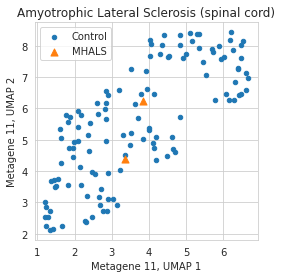

In [ ]:
sns.set_style('whitegrid')
key = 'MHALS' # 'MHALS'
x = x_source[:, 11, :]

x_2d = umap.UMAP(random_state=0).fit_transform(x)

plt.figure(figsize=(4, 4))
y = subject_df.loc[participant_idxs][key]
plt.scatter(x_2d[y==0, 0], x_2d[y==0, 1], s=20, cmap=matplotlib.cm.summer, label='Control')
plt.gca().scatter(x_2d[y==1, 0], x_2d[y==1, 1], s=50, marker='^', cmap=matplotlib.cm.summer, label=key)
plt.legend(loc='upper left')
plt.title('Amyotrophic Lateral Sclerosis (spinal cord)')
plt.xlabel('Metagene 11, UMAP 1')
plt.ylabel('Metagene 11, UMAP 2')
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_MHALS_spinalcord.pdf', bbox_inches='tight');
Counter(y), Counter(subject_df[key])

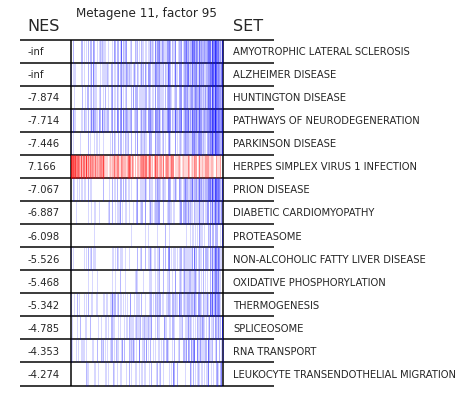

In [ ]:
factor_id = 95
metagene_idx = 11
gene_idxs = np.argsort(metagene_w[metagene_idx, factor_id, :])[::-1]
gene_names = adata.var['Symbol'][gene_idxs].values
gene_values = metagene_w[metagene_idx, factor_id, gene_idxs]
signature = pd.DataFrame({0: gene_names, 1: gene_values})
# result = blitz.gsea(signature, library, permutations=100)

df = results_df[(results_df['Factor'] == factor_id) & (results_df['Metagene'] == metagene_idx)]
fig = blitz.plot.top_table(signature, library, df, n=15)
plt.title(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALS_ALZDMT_top_plot.pdf', bbox_inches='tight')

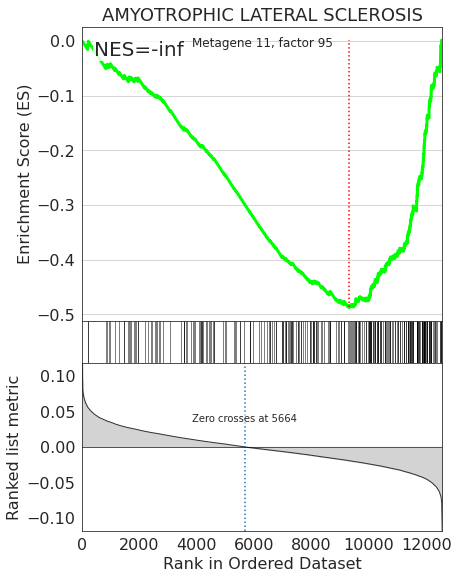

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[0], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALS_running_sum.pdf', bbox_inches='tight')

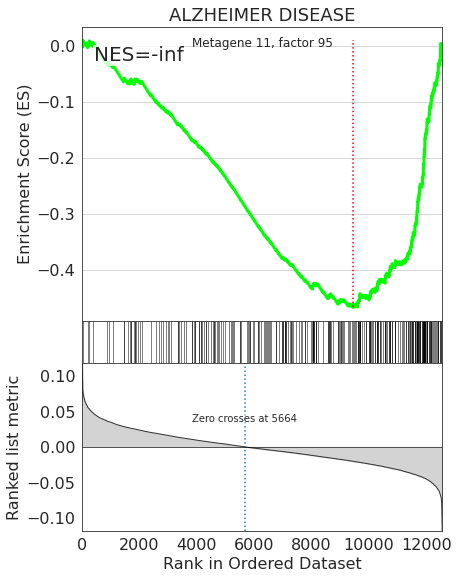

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[1], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_Alzheimer_running_sum.pdf', bbox_inches='tight')

#### Store predictions

In [ ]:
def create_dataframe(participant_ids, tissue_ids, expression, donor_map, tissue_dict_inv, symbols):
    participant_ids = np.concatenate(participant_ids, axis=0)
    tissue_ids = np.concatenate(tissue_ids, axis=0)
    expression = np.concatenate(expression, axis=0)
    df_metadata = pd.DataFrame({'Participant ID': [donor_map[p] for p in participant_ids],
                               'Tissue': [tissue_dict_inv[t] for t in tissue_ids]})
    df = pd.DataFrame(expression, columns=symbols)
    df = pd.concat([df_metadata, df], axis=1)
    df = df.set_index('Participant ID')
    return df

In [ ]:
dataset = HypergraphDataset(adata, static=True)

In [ ]:
model.eval()
# df_imputed = pd.DataFrame({'Participant ID': [], 'Tissue ID': [], })
source_participant_ids = []
source_tissue_ids = []
source_expression = []
target_participant_ids = []
target_tissue_ids = []
target_expression = []
for i, d in tqdm(enumerate(dataset)):
    # Set target tissues to missing tissues
    d.target['Tissue'] = torch.tensor([t for t in np.arange(len(tissue_dict)) if t not in d.source['Tissue']])
    d.target['Participant ID'] = torch.zeros_like(d.target['Tissue']) + d.source['Participant ID'][0]
    d.x_target = torch.tensor([-1])  # Unused
    
    # Make predictions
    with torch.no_grad():
        out, node_features = forward(d, model, device, preprocess_fn=None) 
        y_pred = out['px_rate']
    
    # Store
    source_participant_ids.append(d.source['Participant ID'].cpu().numpy() + i)
    source_tissue_ids.append(d.source['Tissue'].cpu().numpy())
    source_expression.append(d.x_source.cpu().numpy())
    target_participant_ids.append(d.target['Participant ID'].cpu().numpy() + i)
    target_tissue_ids.append(d.target['Tissue'].cpu().numpy())
    target_expression.append(y_pred.cpu().numpy())

# Store data in dataframes
df_imputed = create_dataframe(target_participant_ids, target_tissue_ids, target_expression,
                              donor_map=dataset.donor_map,
                              tissue_dict_inv=tissue_dict_inv,
                              symbols=adata.var['Symbol'])
df_observed = create_dataframe(source_participant_ids, source_tissue_ids, source_expression,
                               donor_map=dataset.donor_map,
                               tissue_dict_inv=tissue_dict_inv,
                               symbols=adata.var['Symbol'])

834it [00:17, 47.67it/s]


In [ ]:
df_observed.to_csv(f'{RESULTS_DIR}/observed_normalised.csv')
df_imputed.to_csv(f'{RESULTS_DIR}/imputed_normalised.csv')

#### Tissue to tissue network

In [ ]:
t2t_scores = np.load(f'{RESULTS_DIR}/t2t_scores.npy')

In [ ]:
score_fn = pearson_correlation_score
t2t_scores_dict = {}
unseen_mask = np.logical_or(val_mask, test_mask)

for st in tissue_dict.keys():
    st2t_scores_dict = {}
    for tt in tqdm(tissue_dict.keys()):
        print(st, '->', tt)
        if st in t2t_scores_dict and tt in t2t_scores_dict[st]:
            continue
            
        # Name source and target tissues
        source_name = st.replace('_', ' ')
        target_name = tt.replace('_', ' ')
        # print(tt)

        # Create datasets
        aux_dataset = HypergraphDataset(adata[unseen_mask],
                                        obs_source={'Tissue': [st]},
                                        obs_target={'Tissue': [tt]})
        source_donor_ids = aux_dataset.adata_source.obs['Participant ID']
        target_donor_ids = aux_dataset.adata_target.obs['Participant ID']
        assert (source_donor_ids.values == target_donor_ids.values).all()
        
        if len(aux_dataset) < 10:
            print('Less than 10 samples', st, tt)
            continue

        # Hypergraph baseline
        aux_loader = DataLoader(aux_dataset, batch_size=len(aux_dataset),
                                collate_fn=collate_fn, shuffle=False, drop_last=False)

        # Compute predictions and score
        model.eval()
        with torch.no_grad():
            d = next(iter(aux_loader))

            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_test_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
            y_test_ = d.x_target.cpu().numpy()

        sample_scores = score_fn(y_test_, y_test_pred, sample_corr=True)
        gene_scores = score_fn(y_test_, y_test_pred, sample_corr=False)

        # Append results
        st2t_scores_dict[tt] = {'gene_scores': gene_scores.mean(),
                                'sample_scores': sample_scores.mean()}
        del aux_dataset
        del aux_loader
        
    t2t_scores_dict[st] = st2t_scores_dict

  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Adipose_Subcutaneous -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<01:03,  1.32s/it]

Adipose_Subcutaneous -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:02<00:51,  1.09s/it]

Adipose_Subcutaneous -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:40,  1.13it/s]

Adipose_Subcutaneous -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:38,  1.17it/s]

Adipose_Subcutaneous -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:34,  1.28it/s]

Adipose_Subcutaneous -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:36,  1.17it/s]

Adipose_Subcutaneous -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:31,  1.35it/s]

Adipose_Subcutaneous -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:28,  1.45it/s]

Adipose_Subcutaneous -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:07<00:26,  1.49it/s]

Adipose_Subcutaneous -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:25,  1.52it/s]

Adipose_Subcutaneous -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:24,  1.52it/s]

Adipose_Subcutaneous -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:24,  1.53it/s]

Adipose_Subcutaneous -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:23,  1.56it/s]

Adipose_Subcutaneous -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:24,  1.43it/s]

Adipose_Subcutaneous -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:11<00:22,  1.49it/s]

Adipose_Subcutaneous -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:21,  1.50it/s]

Adipose_Subcutaneous -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:12<00:20,  1.54it/s]

Adipose_Subcutaneous -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:19,  1.60it/s]

Adipose_Subcutaneous -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:13<00:18,  1.66it/s]

Adipose_Subcutaneous -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:14<00:19,  1.50it/s]

Adipose_Subcutaneous -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:15<00:21,  1.33it/s]

Adipose_Subcutaneous -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:18,  1.43it/s]

Adipose_Subcutaneous -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:16<00:18,  1.37it/s]

Adipose_Subcutaneous -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:17<00:18,  1.34it/s]

Adipose_Subcutaneous -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:18<00:18,  1.32it/s]

Adipose_Subcutaneous -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:19<00:18,  1.24it/s]

Adipose_Subcutaneous -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:18,  1.20it/s]

Adipose_Subcutaneous -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:20<00:17,  1.22it/s]

Adipose_Subcutaneous -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:21<00:16,  1.22it/s]

Adipose_Subcutaneous -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:22<00:13,  1.39it/s]

Adipose_Subcutaneous -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:22<00:12,  1.41it/s]

Adipose_Subcutaneous -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:23<00:13,  1.29it/s]

Adipose_Subcutaneous -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:24<00:11,  1.42it/s]

Adipose_Subcutaneous -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:25<00:12,  1.19it/s]

Adipose_Subcutaneous -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:26<00:12,  1.13it/s]

Adipose_Subcutaneous -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:26<00:10,  1.23it/s]

Adipose_Subcutaneous -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:27<00:09,  1.26it/s]

Adipose_Subcutaneous -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:28<00:08,  1.29it/s]

Adipose_Subcutaneous -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:29<00:07,  1.33it/s]

Adipose_Subcutaneous -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:30<00:08,  1.11it/s]

Adipose_Subcutaneous -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:31<00:07,  1.04it/s]

Adipose_Subcutaneous -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:32<00:06,  1.17it/s]

Adipose_Subcutaneous -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:32<00:04,  1.25it/s]

Adipose_Subcutaneous -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:33<00:03,  1.27it/s]

Adipose_Subcutaneous -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:34<00:03,  1.24it/s]

Adipose_Subcutaneous -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:35<00:02,  1.15it/s]

Adipose_Subcutaneous -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:35<00:01,  1.31it/s]

Adipose_Subcutaneous -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:36<00:00,  1.44it/s]

Adipose_Subcutaneous -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Adipose_Visceral_Omentum -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:43,  1.11it/s]

Adipose_Visceral_Omentum -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:45,  1.03it/s]

Adipose_Visceral_Omentum -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:37,  1.22it/s]

Adipose_Visceral_Omentum -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:34,  1.29it/s]

Adipose_Visceral_Omentum -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:31,  1.41it/s]

Adipose_Visceral_Omentum -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:33,  1.28it/s]

Adipose_Visceral_Omentum -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:29,  1.43it/s]

Adipose_Visceral_Omentum -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:26,  1.53it/s]

Adipose_Visceral_Omentum -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:25,  1.58it/s]

Adipose_Visceral_Omentum -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:23,  1.63it/s]

Adipose_Visceral_Omentum -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:23,  1.64it/s]

Adipose_Visceral_Omentum -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:22,  1.64it/s]

Adipose_Visceral_Omentum -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:21,  1.66it/s]

Adipose_Visceral_Omentum -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:20,  1.68it/s]

Adipose_Visceral_Omentum -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:19,  1.75it/s]

Adipose_Visceral_Omentum -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:10<00:18,  1.74it/s]

Adipose_Visceral_Omentum -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:18,  1.73it/s]

Adipose_Visceral_Omentum -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:11<00:17,  1.81it/s]

Adipose_Visceral_Omentum -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:12<00:15,  1.89it/s]

Adipose_Visceral_Omentum -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:19,  1.48it/s]

Adipose_Visceral_Omentum -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:13<00:19,  1.43it/s]

Adipose_Visceral_Omentum -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:14<00:17,  1.55it/s]

Adipose_Visceral_Omentum -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:15<00:17,  1.46it/s]

Adipose_Visceral_Omentum -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:15<00:17,  1.41it/s]

Adipose_Visceral_Omentum -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:16<00:17,  1.38it/s]

Adipose_Visceral_Omentum -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:17<00:17,  1.32it/s]

Adipose_Visceral_Omentum -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:18<00:17,  1.29it/s]

Adipose_Visceral_Omentum -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:19<00:16,  1.30it/s]

Adipose_Visceral_Omentum -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:19<00:15,  1.31it/s]

Adipose_Visceral_Omentum -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:20<00:13,  1.44it/s]

Adipose_Visceral_Omentum -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:20<00:12,  1.49it/s]

Adipose_Visceral_Omentum -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:21<00:12,  1.38it/s]

Adipose_Visceral_Omentum -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:22<00:11,  1.44it/s]

Adipose_Visceral_Omentum -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:23<00:11,  1.31it/s]

Adipose_Visceral_Omentum -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:24<00:11,  1.26it/s]

Adipose_Visceral_Omentum -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:24<00:09,  1.38it/s]

Adipose_Visceral_Omentum -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:25<00:08,  1.41it/s]

Adipose_Visceral_Omentum -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:26<00:07,  1.45it/s]

Adipose_Visceral_Omentum -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:26<00:06,  1.48it/s]

Adipose_Visceral_Omentum -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:27<00:06,  1.35it/s]

Adipose_Visceral_Omentum -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:28<00:06,  1.27it/s]

Adipose_Visceral_Omentum -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:29<00:05,  1.36it/s]

Adipose_Visceral_Omentum -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:29<00:04,  1.43it/s]

Adipose_Visceral_Omentum -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:30<00:03,  1.44it/s]

Adipose_Visceral_Omentum -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:31<00:02,  1.42it/s]

Adipose_Visceral_Omentum -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:32<00:02,  1.31it/s]

Adipose_Visceral_Omentum -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:32<00:01,  1.43it/s]

Adipose_Visceral_Omentum -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:33<00:00,  1.55it/s]

Adipose_Visceral_Omentum -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Adrenal_Gland -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:31,  1.52it/s]

Adrenal_Gland -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.59it/s]

Adrenal_Gland -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:31,  1.48it/s]

Adrenal_Gland -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:29,  1.54it/s]

Adrenal_Gland -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:26,  1.68it/s]

Adrenal_Gland -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:26,  1.62it/s]

Adrenal_Gland -> Brain_Amygdala
Less than 10 samples Adrenal_Gland Brain_Amygdala
Adrenal_Gland -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:17,  2.37it/s]

Adrenal_Gland -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:17,  2.34it/s]

Adrenal_Gland -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:16,  2.32it/s]

Adrenal_Gland -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:17,  2.21it/s]

Adrenal_Gland -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:17,  2.15it/s]

Adrenal_Gland -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:17,  2.11it/s]

Adrenal_Gland -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:16,  2.16it/s]

Adrenal_Gland -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:15,  2.19it/s]

Adrenal_Gland -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:07<00:15,  2.19it/s]

Adrenal_Gland -> Brain_Putamen
Less than 10 samples Adrenal_Gland Brain_Putamen
Adrenal_Gland -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:08<00:10,  2.84it/s]

Adrenal_Gland -> Brain_Substantia_nigra
Less than 10 samples Adrenal_Gland Brain_Substantia_nigra
Adrenal_Gland -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:08<00:09,  3.03it/s]

Adrenal_Gland -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:09<00:11,  2.52it/s]

Adrenal_Gland -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:10<00:11,  2.34it/s]

Adrenal_Gland -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:10<00:12,  2.12it/s]

Adrenal_Gland -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:11<00:12,  1.95it/s]

Adrenal_Gland -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:11<00:12,  1.85it/s]

Adrenal_Gland -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:12<00:13,  1.75it/s]

Adrenal_Gland -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:13<00:13,  1.65it/s]

Adrenal_Gland -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:13<00:12,  1.67it/s]

Adrenal_Gland -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:14<00:12,  1.66it/s]

Adrenal_Gland -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:14<00:10,  1.78it/s]

Adrenal_Gland -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:15<00:10,  1.78it/s]

Adrenal_Gland -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:16<00:10,  1.70it/s]

Adrenal_Gland -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:16<00:08,  1.82it/s]

Adrenal_Gland -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:17<00:08,  1.68it/s]

Adrenal_Gland -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:08,  1.62it/s]

Adrenal_Gland -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:18<00:07,  1.70it/s]

Adrenal_Gland -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:19<00:07,  1.69it/s]

Adrenal_Gland -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:19<00:06,  1.76it/s]

Adrenal_Gland -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:05,  1.77it/s]

Adrenal_Gland -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:20<00:05,  1.72it/s]

Adrenal_Gland -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:21<00:04,  1.64it/s]

Adrenal_Gland -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:22<00:04,  1.70it/s]

Adrenal_Gland -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:22<00:03,  1.73it/s]

Adrenal_Gland -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:02,  1.70it/s]

Adrenal_Gland -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:02,  1.70it/s]

Adrenal_Gland -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:01,  1.65it/s]

Adrenal_Gland -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:24<00:01,  1.77it/s]

Adrenal_Gland -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:25<00:00,  1.87it/s]

Adrenal_Gland -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Artery_Aorta -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:42,  1.14it/s]

Artery_Aorta -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:38,  1.23it/s]

Artery_Aorta -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:33,  1.39it/s]

Artery_Aorta -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:36,  1.22it/s]

Artery_Aorta -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:32,  1.34it/s]

Artery_Aorta -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:34,  1.26it/s]

Artery_Aorta -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:29,  1.43it/s]

Artery_Aorta -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:25,  1.58it/s]

Artery_Aorta -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:23,  1.71it/s]

Artery_Aorta -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:24,  1.57it/s]

Artery_Aorta -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:22,  1.68it/s]

Artery_Aorta -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:21,  1.75it/s]

Artery_Aorta -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:19,  1.83it/s]

Artery_Aorta -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:19,  1.83it/s]

Artery_Aorta -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:18,  1.85it/s]

Artery_Aorta -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:10<00:17,  1.85it/s]

Artery_Aorta -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:17,  1.86it/s]

Artery_Aorta -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:11<00:16,  1.89it/s]

Artery_Aorta -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:15,  1.96it/s]

Artery_Aorta -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:16,  1.78it/s]

Artery_Aorta -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:13<00:17,  1.61it/s]

Artery_Aorta -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:13<00:16,  1.65it/s]

Artery_Aorta -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:14<00:16,  1.58it/s]

Artery_Aorta -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:15<00:16,  1.52it/s]

Artery_Aorta -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:15<00:15,  1.50it/s]

Artery_Aorta -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:16<00:16,  1.39it/s]

Artery_Aorta -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:17<00:16,  1.34it/s]

Artery_Aorta -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:18<00:15,  1.38it/s]

Artery_Aorta -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:18<00:14,  1.36it/s]

Artery_Aorta -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:19<00:12,  1.54it/s]

Artery_Aorta -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:19<00:11,  1.56it/s]

Artery_Aorta -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:20<00:11,  1.44it/s]

Artery_Aorta -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:21<00:10,  1.59it/s]

Artery_Aorta -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:22<00:10,  1.44it/s]

Artery_Aorta -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:22<00:10,  1.38it/s]

Artery_Aorta -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:23<00:08,  1.53it/s]

Artery_Aorta -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:23<00:07,  1.53it/s]

Artery_Aorta -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:24<00:06,  1.60it/s]

Artery_Aorta -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:25<00:06,  1.64it/s]

Artery_Aorta -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:25<00:05,  1.51it/s]

Artery_Aorta -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:26<00:05,  1.40it/s]

Artery_Aorta -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:27<00:04,  1.51it/s]

Artery_Aorta -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:27<00:03,  1.54it/s]

Artery_Aorta -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:28<00:03,  1.50it/s]

Artery_Aorta -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:29<00:02,  1.48it/s]

Artery_Aorta -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:30<00:02,  1.39it/s]

Artery_Aorta -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:30<00:01,  1.53it/s]

Artery_Aorta -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:31<00:00,  1.66it/s]

Artery_Aorta -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Artery_Coronary -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:31,  1.50it/s]

Artery_Coronary -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.57it/s]

Artery_Coronary -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:27,  1.65it/s]

Artery_Coronary -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:27,  1.63it/s]

Artery_Coronary -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:28,  1.55it/s]

Artery_Coronary -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:27,  1.54it/s]

Artery_Coronary -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:24,  1.71it/s]

Artery_Coronary -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:22,  1.84it/s]

Artery_Coronary -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:20,  1.95it/s]

Artery_Coronary -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:19,  2.01it/s]

Artery_Coronary -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:18,  2.05it/s]

Artery_Coronary -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:17,  2.09it/s]

Artery_Coronary -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:16,  2.13it/s]

Artery_Coronary -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:16,  2.16it/s]

Artery_Coronary -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:15,  2.17it/s]

Artery_Coronary -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:08<00:15,  2.18it/s]

Artery_Coronary -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:08<00:14,  2.18it/s]

Artery_Coronary -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:09<00:14,  2.19it/s]

Artery_Coronary -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:09<00:13,  2.19it/s]

Artery_Coronary -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:10<00:14,  2.06it/s]

Artery_Coronary -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:10<00:14,  1.91it/s]

Artery_Coronary -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:11<00:13,  1.98it/s]

Artery_Coronary -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:11<00:13,  1.92it/s]

Artery_Coronary -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:12<00:13,  1.82it/s]

Artery_Coronary -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:13,  1.77it/s]

Artery_Coronary -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:13<00:13,  1.72it/s]

Artery_Coronary -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:13,  1.68it/s]

Artery_Coronary -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:14<00:12,  1.67it/s]

Artery_Coronary -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:12,  1.64it/s]

Artery_Coronary -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:10,  1.78it/s]

Artery_Coronary -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:16<00:09,  1.84it/s]

Artery_Coronary -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.78it/s]

Artery_Coronary -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:17<00:08,  1.89it/s]

Artery_Coronary -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.75it/s]

Artery_Coronary -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:08,  1.71it/s]

Artery_Coronary -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:19<00:07,  1.80it/s]

Artery_Coronary -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:19<00:06,  1.78it/s]

Artery_Coronary -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:05,  1.87it/s]

Artery_Coronary -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:05,  1.91it/s]

Artery_Coronary -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  1.82it/s]

Artery_Coronary -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.75it/s]

Artery_Coronary -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:22<00:03,  1.85it/s]

Artery_Coronary -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:23<00:03,  1.87it/s]

Artery_Coronary -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:02,  1.80it/s]

Artery_Coronary -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:24<00:02,  1.84it/s]

Artery_Coronary -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:01,  1.74it/s]

Artery_Coronary -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:25<00:01,  1.85it/s]

Artery_Coronary -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:25<00:00,  1.93it/s]

Artery_Coronary -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Artery_Tibial -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:47,  1.02it/s]

Artery_Tibial -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:43,  1.07it/s]

Artery_Tibial -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:37,  1.24it/s]

Artery_Tibial -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:36,  1.24it/s]

Artery_Tibial -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:32,  1.33it/s]

Artery_Tibial -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:38,  1.12it/s]

Artery_Tibial -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:32,  1.29it/s]

Artery_Tibial -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:28,  1.41it/s]

Artery_Tibial -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:07<00:29,  1.34it/s]

Artery_Tibial -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:27,  1.43it/s]

Artery_Tibial -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:25,  1.47it/s]

Artery_Tibial -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:24,  1.52it/s]

Artery_Tibial -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:22,  1.57it/s]

Artery_Tibial -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:21,  1.60it/s]

Artery_Tibial -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:20,  1.62it/s]

Artery_Tibial -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:20,  1.62it/s]

Artery_Tibial -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:19,  1.64it/s]

Artery_Tibial -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:18,  1.71it/s]

Artery_Tibial -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:12<00:16,  1.81it/s]

Artery_Tibial -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:18,  1.60it/s]

Artery_Tibial -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:19,  1.43it/s]

Artery_Tibial -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:18,  1.49it/s]

Artery_Tibial -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:15<00:18,  1.41it/s]

Artery_Tibial -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:16<00:18,  1.35it/s]

Artery_Tibial -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:18,  1.33it/s]

Artery_Tibial -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:18<00:18,  1.25it/s]

Artery_Tibial -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:18,  1.22it/s]

Artery_Tibial -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:20<00:17,  1.23it/s]

Artery_Tibial -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:20<00:16,  1.24it/s]

Artery_Tibial -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:21<00:13,  1.37it/s]

Artery_Tibial -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:22<00:12,  1.40it/s]

Artery_Tibial -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:23<00:13,  1.30it/s]

Artery_Tibial -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:23<00:11,  1.40it/s]

Artery_Tibial -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:24<00:12,  1.19it/s]

Artery_Tibial -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:25<00:12,  1.15it/s]

Artery_Tibial -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:26<00:10,  1.27it/s]

Artery_Tibial -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:27<00:10,  1.19it/s]

Artery_Tibial -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:27<00:08,  1.26it/s]

Artery_Tibial -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:28<00:07,  1.31it/s]

Artery_Tibial -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:29<00:07,  1.23it/s]

Artery_Tibial -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:30<00:06,  1.15it/s]

Artery_Tibial -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:31<00:05,  1.27it/s]

Artery_Tibial -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:31<00:04,  1.34it/s]

Artery_Tibial -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:32<00:03,  1.34it/s]

Artery_Tibial -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:33<00:03,  1.31it/s]

Artery_Tibial -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:34<00:02,  1.20it/s]

Artery_Tibial -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:34<00:01,  1.33it/s]

Artery_Tibial -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:35<00:00,  1.47it/s]

Artery_Tibial -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Amygdala -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:27,  1.77it/s]

Brain_Amygdala -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:25,  1.81it/s]

Brain_Amygdala -> Adrenal_Gland
Less than 10 samples Brain_Amygdala Adrenal_Gland
Brain_Amygdala -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:16,  2.70it/s]

Brain_Amygdala -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:17,  2.52it/s]

Brain_Amygdala -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:19,  2.25it/s]

Brain_Amygdala -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:20,  2.02it/s]

Brain_Amygdala -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:03<00:20,  2.00it/s]

Brain_Amygdala -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:20,  1.91it/s]

Brain_Amygdala -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:04<00:21,  1.84it/s]

Brain_Amygdala -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:21,  1.79it/s]

Brain_Amygdala -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:20,  1.78it/s]

Brain_Amygdala -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:20,  1.76it/s]

Brain_Amygdala -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:19,  1.77it/s]

Brain_Amygdala -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:19,  1.76it/s]

Brain_Amygdala -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:08<00:18,  1.74it/s]

Brain_Amygdala -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:08<00:18,  1.73it/s]

Brain_Amygdala -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:09<00:17,  1.82it/s]

Brain_Amygdala -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:09<00:15,  1.88it/s]

Brain_Amygdala -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:10<00:14,  1.94it/s]

Brain_Amygdala -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:10<00:14,  1.96it/s]

Brain_Amygdala -> Cells_EBV
Less than 10 samples Brain_Amygdala Cells_EBV
Brain_Amygdala -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:11<00:09,  2.62it/s]

Brain_Amygdala -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:11<00:10,  2.49it/s]

Brain_Amygdala -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:12<00:10,  2.38it/s]

Brain_Amygdala -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:12<00:10,  2.27it/s]

Brain_Amygdala -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:13<00:09,  2.22it/s]

Brain_Amygdala -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:13<00:09,  2.15it/s]

Brain_Amygdala -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:14<00:09,  2.11it/s]

Brain_Amygdala -> Kidney_Cortex
Less than 10 samples Brain_Amygdala Kidney_Cortex
Brain_Amygdala -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:14<00:06,  2.71it/s]

Brain_Amygdala -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:15<00:07,  2.39it/s]

Brain_Amygdala -> Minor_Salivary
Less than 10 samples Brain_Amygdala Minor_Salivary
Brain_Amygdala -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:15<00:05,  2.75it/s]

Brain_Amygdala -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:16<00:05,  2.45it/s]

Brain_Amygdala -> Ovary
Less than 10 samples Brain_Amygdala Ovary
Brain_Amygdala -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:16<00:04,  2.98it/s]

Brain_Amygdala -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:17<00:04,  2.65it/s]

Brain_Amygdala -> Prostate
Less than 10 samples Brain_Amygdala Prostate
Brain_Amygdala -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:18<00:03,  2.97it/s]

Brain_Amygdala -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:18<00:03,  2.59it/s]

Brain_Amygdala -> Small_Intestine
Less than 10 samples Brain_Amygdala Small_Intestine
Brain_Amygdala -> Spleen
Less than 10 samples Brain_Amygdala Spleen
Brain_Amygdala -> Stomach
Less than 10 samples Brain_Amygdala Stomach
Brain_Amygdala -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:19<00:00,  4.17it/s]

Brain_Amygdala -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:19<00:00,  3.42it/s]

Brain_Amygdala -> Uterus
Less than 10 samples Brain_Amygdala Uterus
Brain_Amygdala -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:20<00:00,  3.69it/s]

Brain_Amygdala -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Anterior_cingulate -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:28,  1.70it/s]

Brain_Anterior_cingulate -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:26,  1.75it/s]

Brain_Anterior_cingulate -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:23,  1.95it/s]

Brain_Anterior_cingulate -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.93it/s]

Brain_Anterior_cingulate -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:21,  2.03it/s]

Brain_Anterior_cingulate -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.92it/s]

Brain_Anterior_cingulate -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:22,  1.88it/s]

Brain_Anterior_cingulate -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.77it/s]

Brain_Anterior_cingulate -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:23,  1.72it/s]

Brain_Anterior_cingulate -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:25,  1.52it/s]

Brain_Anterior_cingulate -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:24,  1.56it/s]

Brain_Anterior_cingulate -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:22,  1.62it/s]

Brain_Anterior_cingulate -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.63it/s]

Brain_Anterior_cingulate -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:20,  1.67it/s]

Brain_Anterior_cingulate -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:20,  1.68it/s]

Brain_Anterior_cingulate -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:19,  1.68it/s]

Brain_Anterior_cingulate -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:18,  1.70it/s]

Brain_Anterior_cingulate -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:17,  1.74it/s]

Brain_Anterior_cingulate -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:16,  1.79it/s]

Brain_Anterior_cingulate -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:15,  1.87it/s]

Brain_Anterior_cingulate -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:11<00:14,  1.92it/s]

Brain_Anterior_cingulate -> Cells_EBV
Less than 10 samples Brain_Anterior_cingulate Cells_EBV
Brain_Anterior_cingulate -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:10,  2.54it/s]

Brain_Anterior_cingulate -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:12<00:10,  2.46it/s]

Brain_Anterior_cingulate -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:10,  2.34it/s]

Brain_Anterior_cingulate -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:13<00:10,  2.23it/s]

Brain_Anterior_cingulate -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:10,  2.18it/s]

Brain_Anterior_cingulate -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:14<00:09,  2.11it/s]

Brain_Anterior_cingulate -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:09,  2.03it/s]

Brain_Anterior_cingulate -> Kidney_Cortex
Less than 10 samples Brain_Anterior_cingulate Kidney_Cortex
Brain_Anterior_cingulate -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:15<00:07,  2.57it/s]

Brain_Anterior_cingulate -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:16<00:07,  2.31it/s]

Brain_Anterior_cingulate -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:16<00:06,  2.29it/s]

Brain_Anterior_cingulate -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:17<00:07,  2.07it/s]

Brain_Anterior_cingulate -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:07,  1.94it/s]

Brain_Anterior_cingulate -> Ovary
Less than 10 samples Brain_Anterior_cingulate Ovary
Brain_Anterior_cingulate -> Pancreas
Less than 10 samples Brain_Anterior_cingulate Pancreas
Brain_Anterior_cingulate -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:18<00:03,  2.92it/s]

Brain_Anterior_cingulate -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:19<00:03,  2.73it/s]

Brain_Anterior_cingulate -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:19<00:03,  2.39it/s]

Brain_Anterior_cingulate -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:20<00:03,  2.18it/s]

Brain_Anterior_cingulate -> Small_Intestine
Less than 10 samples Brain_Anterior_cingulate Small_Intestine
Brain_Anterior_cingulate -> Spleen
Less than 10 samples Brain_Anterior_cingulate Spleen
Brain_Anterior_cingulate -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:20<00:01,  3.33it/s]

Brain_Anterior_cingulate -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:21<00:01,  2.91it/s]

Brain_Anterior_cingulate -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:21<00:01,  2.51it/s]

Brain_Anterior_cingulate -> Uterus
Less than 10 samples Brain_Anterior_cingulate Uterus
Brain_Anterior_cingulate -> Vagina
Less than 10 samples Brain_Anterior_cingulate Vagina
Brain_Anterior_cingulate -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Caudate -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:31,  1.53it/s]

Brain_Caudate -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.60it/s]

Brain_Caudate -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:25,  1.80it/s]

Brain_Caudate -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.90it/s]

Brain_Caudate -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:21,  2.01it/s]

Brain_Caudate -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.90it/s]

Brain_Caudate -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.82it/s]

Brain_Caudate -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.76it/s]

Brain_Caudate -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:24,  1.61it/s]

Brain_Caudate -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:24,  1.61it/s]

Brain_Caudate -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:24,  1.57it/s]

Brain_Caudate -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:23,  1.58it/s]

Brain_Caudate -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.57it/s]

Brain_Caudate -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.59it/s]

Brain_Caudate -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:21,  1.56it/s]

Brain_Caudate -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:21,  1.54it/s]

Brain_Caudate -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:20,  1.55it/s]

Brain_Caudate -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:19,  1.62it/s]

Brain_Caudate -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.67it/s]

Brain_Caudate -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.76it/s]

Brain_Caudate -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:16,  1.72it/s]

Brain_Caudate -> Cells_EBV
Less than 10 samples Brain_Caudate Cells_EBV
Brain_Caudate -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:11,  2.33it/s]

Brain_Caudate -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.26it/s]

Brain_Caudate -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:11,  2.15it/s]

Brain_Caudate -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.09it/s]

Brain_Caudate -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:10,  2.01it/s]

Brain_Caudate -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:11,  1.90it/s]

Brain_Caudate -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:10,  1.87it/s]

Brain_Caudate -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  1.96it/s]

Brain_Caudate -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:09,  1.92it/s]

Brain_Caudate -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.82it/s]

Brain_Caudate -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.91it/s]

Brain_Caudate -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:19<00:08,  1.77it/s]

Brain_Caudate -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:08,  1.71it/s]

Brain_Caudate -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:20<00:07,  1.84it/s]

Brain_Caudate -> Pancreas
Less than 10 samples Brain_Caudate Pancreas
Brain_Caudate -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:04,  2.27it/s]

Brain_Caudate -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:21<00:04,  2.25it/s]

Brain_Caudate -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  2.04it/s]

Brain_Caudate -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.88it/s]

Brain_Caudate -> Small_Intestine
Less than 10 samples Brain_Caudate Small_Intestine
Brain_Caudate -> Spleen
Less than 10 samples Brain_Caudate Spleen
Brain_Caudate -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:01,  2.70it/s]

Brain_Caudate -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:01,  2.46it/s]

Brain_Caudate -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:01,  2.20it/s]

Brain_Caudate -> Uterus
Less than 10 samples Brain_Caudate Uterus
Brain_Caudate -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:24<00:00,  2.74it/s]

Brain_Caudate -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Cerebellar -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:30,  1.60it/s]

Brain_Cerebellar -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:28,  1.67it/s]

Brain_Cerebellar -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:24,  1.91it/s]

Brain_Cerebellar -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.88it/s]

Brain_Cerebellar -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  1.97it/s]

Brain_Cerebellar -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.87it/s]

Brain_Cerebellar -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.80it/s]

Brain_Cerebellar -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.74it/s]

Brain_Cerebellar -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.68it/s]

Brain_Cerebellar -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:24,  1.61it/s]

Brain_Cerebellar -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:23,  1.61it/s]

Brain_Cerebellar -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:22,  1.63it/s]

Brain_Cerebellar -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.63it/s]

Brain_Cerebellar -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.62it/s]

Brain_Cerebellar -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:20,  1.63it/s]

Brain_Cerebellar -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.62it/s]

Brain_Cerebellar -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:19,  1.62it/s]

Brain_Cerebellar -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.67it/s]

Brain_Cerebellar -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.72it/s]

Brain_Cerebellar -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.76it/s]

Brain_Cerebellar -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:15,  1.76it/s]

Brain_Cerebellar -> Cells_EBV
Less than 10 samples Brain_Cerebellar Cells_EBV
Brain_Cerebellar -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:11,  2.31it/s]

Brain_Cerebellar -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.27it/s]

Brain_Cerebellar -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:11,  2.15it/s]

Brain_Cerebellar -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.05it/s]

Brain_Cerebellar -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:11,  1.97it/s]

Brain_Cerebellar -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:10,  1.92it/s]

Brain_Cerebellar -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:10,  1.89it/s]

Brain_Cerebellar -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  1.99it/s]

Brain_Cerebellar -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:09,  1.96it/s]

Brain_Cerebellar -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.87it/s]

Brain_Cerebellar -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.98it/s]

Brain_Cerebellar -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.85it/s]

Brain_Cerebellar -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:07,  1.79it/s]

Brain_Cerebellar -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:19<00:06,  1.90it/s]

Brain_Cerebellar -> Pancreas
Less than 10 samples Brain_Cerebellar Pancreas
Brain_Cerebellar -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:04,  2.36it/s]

Brain_Cerebellar -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:04,  2.32it/s]

Brain_Cerebellar -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  2.10it/s]

Brain_Cerebellar -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:21<00:04,  1.94it/s]

Brain_Cerebellar -> Small_Intestine
Less than 10 samples Brain_Cerebellar Small_Intestine
Brain_Cerebellar -> Spleen
Less than 10 samples Brain_Cerebellar Spleen
Brain_Cerebellar -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:22<00:01,  3.13it/s]

Brain_Cerebellar -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:22<00:01,  2.81it/s]

Brain_Cerebellar -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:23<00:01,  2.44it/s]

Brain_Cerebellar -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:23<00:00,  2.40it/s]

Brain_Cerebellar -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:24<00:00,  2.35it/s]

Brain_Cerebellar -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Cerebellum -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:30,  1.58it/s]

Brain_Cerebellum -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.61it/s]

Brain_Cerebellum -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:25,  1.83it/s]

Brain_Cerebellum -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.89it/s]

Brain_Cerebellum -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  1.98it/s]

Brain_Cerebellum -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:23,  1.83it/s]

Brain_Cerebellum -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.79it/s]

Brain_Cerebellum -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.76it/s]

Brain_Cerebellum -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.70it/s]

Brain_Cerebellum -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:23,  1.65it/s]

Brain_Cerebellum -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:24,  1.55it/s]

Brain_Cerebellum -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:24,  1.52it/s]

Brain_Cerebellum -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:23,  1.55it/s]

Brain_Cerebellum -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:22,  1.57it/s]

Brain_Cerebellum -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:21,  1.57it/s]

Brain_Cerebellum -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.57it/s]

Brain_Cerebellum -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:20,  1.58it/s]

Brain_Cerebellum -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.67it/s]

Brain_Cerebellum -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.73it/s]

Brain_Cerebellum -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:18,  1.54it/s]

Brain_Cerebellum -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:17,  1.60it/s]

Brain_Cerebellum -> Cells_EBV
Less than 10 samples Brain_Cerebellum Cells_EBV
Brain_Cerebellum -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:11,  2.18it/s]

Brain_Cerebellum -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.17it/s]

Brain_Cerebellum -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:11,  2.11it/s]

Brain_Cerebellum -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  1.97it/s]

Brain_Cerebellum -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:11,  1.92it/s]

Brain_Cerebellum -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:11,  1.83it/s]

Brain_Cerebellum -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:11,  1.82it/s]

Brain_Cerebellum -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:17<00:09,  1.90it/s]

Brain_Cerebellum -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:10,  1.78it/s]

Brain_Cerebellum -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:18<00:09,  1.72it/s]

Brain_Cerebellum -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.84it/s]

Brain_Cerebellum -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:19<00:08,  1.71it/s]

Brain_Cerebellum -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:20<00:08,  1.65it/s]

Brain_Cerebellum -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:20<00:07,  1.78it/s]

Brain_Cerebellum -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:20<00:06,  1.91it/s]

Brain_Cerebellum -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:21<00:06,  1.79it/s]

Brain_Cerebellum -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:22<00:05,  1.87it/s]

Brain_Cerebellum -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:22<00:05,  1.77it/s]

Brain_Cerebellum -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:23<00:04,  1.69it/s]

Brain_Cerebellum -> Small_Intestine
Less than 10 samples Brain_Cerebellum Small_Intestine
Brain_Cerebellum -> Spleen
Less than 10 samples Brain_Cerebellum Spleen
Brain_Cerebellum -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:01,  2.90it/s]

Brain_Cerebellum -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:24<00:01,  2.51it/s]

Brain_Cerebellum -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:25<00:01,  2.17it/s]

Brain_Cerebellum -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:25<00:00,  2.19it/s]

Brain_Cerebellum -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:26<00:00,  2.14it/s]

Brain_Cerebellum -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Cortex -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:31,  1.55it/s]

Brain_Cortex -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.61it/s]

Brain_Cortex -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:25,  1.77it/s]

Brain_Cortex -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:25,  1.79it/s]

Brain_Cortex -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:23,  1.86it/s]

Brain_Cortex -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:24,  1.73it/s]

Brain_Cortex -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:23,  1.76it/s]

Brain_Cortex -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.76it/s]

Brain_Cortex -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.71it/s]

Brain_Cortex -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:22,  1.70it/s]

Brain_Cortex -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:23,  1.63it/s]

Brain_Cortex -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:24,  1.52it/s]

Brain_Cortex -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:23,  1.53it/s]

Brain_Cortex -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:22,  1.57it/s]

Brain_Cortex -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:21,  1.59it/s]

Brain_Cortex -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.58it/s]

Brain_Cortex -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:20,  1.60it/s]

Brain_Cortex -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.70it/s]

Brain_Cortex -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:16,  1.79it/s]

Brain_Cortex -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.77it/s]

Brain_Cortex -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:16,  1.74it/s]

Brain_Cortex -> Cells_EBV
Less than 10 samples Brain_Cortex Cells_EBV
Brain_Cortex -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:11,  2.35it/s]

Brain_Cortex -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:10,  2.29it/s]

Brain_Cortex -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:10,  2.21it/s]

Brain_Cortex -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.03it/s]

Brain_Cortex -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:10,  2.02it/s]

Brain_Cortex -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:11,  1.90it/s]

Brain_Cortex -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:10,  1.92it/s]

Brain_Cortex -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  2.00it/s]

Brain_Cortex -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:09,  1.98it/s]

Brain_Cortex -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.87it/s]

Brain_Cortex -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.96it/s]

Brain_Cortex -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.72it/s]

Brain_Cortex -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:08,  1.67it/s]

Brain_Cortex -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:20<00:07,  1.82it/s]

Brain_Cortex -> Pancreas
Less than 10 samples Brain_Cortex Pancreas
Brain_Cortex -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:05,  2.19it/s]

Brain_Cortex -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:21<00:04,  2.18it/s]

Brain_Cortex -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  1.95it/s]

Brain_Cortex -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.80it/s]

Brain_Cortex -> Small_Intestine
Less than 10 samples Brain_Cortex Small_Intestine
Brain_Cortex -> Spleen
Less than 10 samples Brain_Cortex Spleen
Brain_Cortex -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:22<00:01,  2.95it/s]

Brain_Cortex -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:01,  2.67it/s]

Brain_Cortex -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:01,  2.02it/s]

Brain_Cortex -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:24<00:00,  2.07it/s]

Brain_Cortex -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:25<00:00,  2.10it/s]

Brain_Cortex -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Frontal_Cortex -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:29,  1.61it/s]

Brain_Frontal_Cortex -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:28,  1.67it/s]

Brain_Frontal_Cortex -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:24,  1.90it/s]

Brain_Frontal_Cortex -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.89it/s]

Brain_Frontal_Cortex -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  2.00it/s]

Brain_Frontal_Cortex -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.88it/s]

Brain_Frontal_Cortex -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:22,  1.84it/s]

Brain_Frontal_Cortex -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:22,  1.80it/s]

Brain_Frontal_Cortex -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.71it/s]

Brain_Frontal_Cortex -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:23,  1.68it/s]

Brain_Frontal_Cortex -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:22,  1.67it/s]

Brain_Frontal_Cortex -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:22,  1.67it/s]

Brain_Frontal_Cortex -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.60it/s]

Brain_Frontal_Cortex -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.62it/s]

Brain_Frontal_Cortex -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:21,  1.60it/s]

Brain_Frontal_Cortex -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.58it/s]

Brain_Frontal_Cortex -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:19,  1.60it/s]

Brain_Frontal_Cortex -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.71it/s]

Brain_Frontal_Cortex -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:16,  1.80it/s]

Brain_Frontal_Cortex -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:15,  1.87it/s]

Brain_Frontal_Cortex -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:15,  1.83it/s]

Brain_Frontal_Cortex -> Cells_EBV
Less than 10 samples Brain_Frontal_Cortex Cells_EBV
Brain_Frontal_Cortex -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:10,  2.37it/s]

Brain_Frontal_Cortex -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.26it/s]

Brain_Frontal_Cortex -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:11,  2.15it/s]

Brain_Frontal_Cortex -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.03it/s]

Brain_Frontal_Cortex -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:11,  1.99it/s]

Brain_Frontal_Cortex -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:11,  1.91it/s]

Brain_Frontal_Cortex -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:10,  1.89it/s]

Brain_Frontal_Cortex -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  1.93it/s]

Brain_Frontal_Cortex -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:16<00:09,  1.97it/s]

Brain_Frontal_Cortex -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.87it/s]

Brain_Frontal_Cortex -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:17<00:08,  1.96it/s]

Brain_Frontal_Cortex -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.80it/s]

Brain_Frontal_Cortex -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:08,  1.74it/s]

Brain_Frontal_Cortex -> Ovary
Less than 10 samples Brain_Frontal_Cortex Ovary
Brain_Frontal_Cortex -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:19<00:04,  2.42it/s]

Brain_Frontal_Cortex -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:05,  2.12it/s]

Brain_Frontal_Cortex -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:04,  2.13it/s]

Brain_Frontal_Cortex -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  1.93it/s]

Brain_Frontal_Cortex -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.80it/s]

Brain_Frontal_Cortex -> Small_Intestine
Less than 10 samples Brain_Frontal_Cortex Small_Intestine
Brain_Frontal_Cortex -> Spleen
Less than 10 samples Brain_Frontal_Cortex Spleen
Brain_Frontal_Cortex -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:22<00:01,  2.95it/s]

Brain_Frontal_Cortex -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:01,  2.63it/s]

Brain_Frontal_Cortex -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:23<00:01,  2.30it/s]

Brain_Frontal_Cortex -> Uterus
Less than 10 samples Brain_Frontal_Cortex Uterus
Brain_Frontal_Cortex -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:24<00:00,  2.85it/s]

Brain_Frontal_Cortex -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Hippocampus -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:29,  1.60it/s]

Brain_Hippocampus -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:28,  1.68it/s]

Brain_Hippocampus -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:24,  1.89it/s]

Brain_Hippocampus -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:24,  1.86it/s]

Brain_Hippocampus -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  1.96it/s]

Brain_Hippocampus -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:23,  1.82it/s]

Brain_Hippocampus -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.81it/s]

Brain_Hippocampus -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.78it/s]

Brain_Hippocampus -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.72it/s]

Brain_Hippocampus -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:22,  1.70it/s]

Brain_Hippocampus -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:22,  1.68it/s]

Brain_Hippocampus -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:21,  1.70it/s]

Brain_Hippocampus -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:21,  1.70it/s]

Brain_Hippocampus -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.60it/s]

Brain_Hippocampus -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:20,  1.63it/s]

Brain_Hippocampus -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.62it/s]

Brain_Hippocampus -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:19,  1.63it/s]

Brain_Hippocampus -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.69it/s]

Brain_Hippocampus -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.73it/s]

Brain_Hippocampus -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.77it/s]

Brain_Hippocampus -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:15,  1.76it/s]

Brain_Hippocampus -> Cells_EBV
Less than 10 samples Brain_Hippocampus Cells_EBV
Brain_Hippocampus -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:11,  2.31it/s]

Brain_Hippocampus -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.22it/s]

Brain_Hippocampus -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:11,  2.12it/s]

Brain_Hippocampus -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:12,  1.80it/s]

Brain_Hippocampus -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:12,  1.82it/s]

Brain_Hippocampus -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:11,  1.80it/s]

Brain_Hippocampus -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:11,  1.81it/s]

Brain_Hippocampus -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:10,  1.86it/s]

Brain_Hippocampus -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:09,  1.85it/s]

Brain_Hippocampus -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.79it/s]

Brain_Hippocampus -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.86it/s]

Brain_Hippocampus -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.78it/s]

Brain_Hippocampus -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:07,  1.75it/s]

Brain_Hippocampus -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:19<00:06,  1.87it/s]

Brain_Hippocampus -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:20<00:06,  1.98it/s]

Brain_Hippocampus -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:21<00:05,  1.86it/s]

Brain_Hippocampus -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:21<00:05,  1.94it/s]

Brain_Hippocampus -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:22<00:04,  1.86it/s]

Brain_Hippocampus -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.77it/s]

Brain_Hippocampus -> Small_Intestine
Less than 10 samples Brain_Hippocampus Small_Intestine
Brain_Hippocampus -> Spleen
Less than 10 samples Brain_Hippocampus Spleen
Brain_Hippocampus -> Stomach
Less than 10 samples Brain_Hippocampus Stomach
Brain_Hippocampus -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:01,  3.47it/s]

Brain_Hippocampus -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:23<00:01,  2.91it/s]

Brain_Hippocampus -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:24<00:00,  2.74it/s]

Brain_Hippocampus -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:24<00:00,  2.61it/s]

Brain_Hippocampus -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Hypothalamus -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:28,  1.68it/s]

Brain_Hypothalamus -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:26,  1.77it/s]

Brain_Hypothalamus -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:23,  1.99it/s]

Brain_Hypothalamus -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.95it/s]

Brain_Hypothalamus -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  1.97it/s]

Brain_Hypothalamus -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.87it/s]

Brain_Hypothalamus -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.81it/s]

Brain_Hypothalamus -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.76it/s]

Brain_Hypothalamus -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:23,  1.71it/s]

Brain_Hypothalamus -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:23,  1.69it/s]

Brain_Hypothalamus -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:22,  1.69it/s]

Brain_Hypothalamus -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:21,  1.70it/s]

Brain_Hypothalamus -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:21,  1.66it/s]

Brain_Hypothalamus -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.66it/s]

Brain_Hypothalamus -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:21,  1.61it/s]

Brain_Hypothalamus -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.59it/s]

Brain_Hypothalamus -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:19,  1.60it/s]

Brain_Hypothalamus -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:18,  1.70it/s]

Brain_Hypothalamus -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:16,  1.77it/s]

Brain_Hypothalamus -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.78it/s]

Brain_Hypothalamus -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:15,  1.77it/s]

Brain_Hypothalamus -> Cells_EBV
Less than 10 samples Brain_Hypothalamus Cells_EBV
Brain_Hypothalamus -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:11,  2.36it/s]

Brain_Hypothalamus -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.24it/s]

Brain_Hypothalamus -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:11,  2.15it/s]

Brain_Hypothalamus -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.07it/s]

Brain_Hypothalamus -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:10,  2.02it/s]

Brain_Hypothalamus -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:10,  1.95it/s]

Brain_Hypothalamus -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:10,  1.93it/s]

Brain_Hypothalamus -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  2.01it/s]

Brain_Hypothalamus -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:16<00:08,  2.01it/s]

Brain_Hypothalamus -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:08,  1.91it/s]

Brain_Hypothalamus -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:17<00:08,  1.99it/s]

Brain_Hypothalamus -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.85it/s]

Brain_Hypothalamus -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:07,  1.78it/s]

Brain_Hypothalamus -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:19<00:06,  1.90it/s]

Brain_Hypothalamus -> Pancreas
Less than 10 samples Brain_Hypothalamus Pancreas
Brain_Hypothalamus -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:04,  2.35it/s]

Brain_Hypothalamus -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:04,  2.31it/s]

Brain_Hypothalamus -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  2.11it/s]

Brain_Hypothalamus -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:21<00:04,  1.93it/s]

Brain_Hypothalamus -> Small_Intestine
Less than 10 samples Brain_Hypothalamus Small_Intestine
Brain_Hypothalamus -> Spleen
Less than 10 samples Brain_Hypothalamus Spleen
Brain_Hypothalamus -> Stomach
Less than 10 samples Brain_Hypothalamus Stomach
Brain_Hypothalamus -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:22<00:01,  3.57it/s]

Brain_Hypothalamus -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:22<00:01,  2.96it/s]

Brain_Hypothalamus -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:23<00:00,  2.78it/s]

Brain_Hypothalamus -> Vagina
Less than 10 samples Brain_Hypothalamus Vagina
Brain_Hypothalamus -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Nucleus -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:31,  1.52it/s]

Brain_Nucleus -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:29,  1.61it/s]

Brain_Nucleus -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:25,  1.81it/s]

Brain_Nucleus -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:24,  1.87it/s]

Brain_Nucleus -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:22,  1.95it/s]

Brain_Nucleus -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:23,  1.83it/s]

Brain_Nucleus -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:23,  1.77it/s]

Brain_Nucleus -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.76it/s]

Brain_Nucleus -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.70it/s]

Brain_Nucleus -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:23,  1.67it/s]

Brain_Nucleus -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:23,  1.64it/s]

Brain_Nucleus -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:22,  1.62it/s]

Brain_Nucleus -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:25,  1.43it/s]

Brain_Nucleus -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:23,  1.49it/s]

Brain_Nucleus -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:22,  1.50it/s]

Brain_Nucleus -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:22,  1.47it/s]

Brain_Nucleus -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:21,  1.49it/s]

Brain_Nucleus -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:11<00:19,  1.60it/s]

Brain_Nucleus -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.68it/s]

Brain_Nucleus -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:16,  1.73it/s]

Brain_Nucleus -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:16,  1.71it/s]

Brain_Nucleus -> Cells_EBV
Less than 10 samples Brain_Nucleus Cells_EBV
Brain_Nucleus -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:11,  2.32it/s]

Brain_Nucleus -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.27it/s]

Brain_Nucleus -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:11,  2.18it/s]

Brain_Nucleus -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:11,  2.08it/s]

Brain_Nucleus -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:10,  2.05it/s]

Brain_Nucleus -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:10,  1.92it/s]

Brain_Nucleus -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:10,  1.88it/s]

Brain_Nucleus -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  1.92it/s]

Brain_Nucleus -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:09,  1.88it/s]

Brain_Nucleus -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:18<00:09,  1.79it/s]

Brain_Nucleus -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:18<00:08,  1.90it/s]

Brain_Nucleus -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:19<00:08,  1.74it/s]

Brain_Nucleus -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:08,  1.69it/s]

Brain_Nucleus -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:20<00:07,  1.81it/s]

Brain_Nucleus -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:20<00:06,  1.88it/s]

Brain_Nucleus -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:21<00:06,  1.76it/s]

Brain_Nucleus -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:21<00:05,  1.86it/s]

Brain_Nucleus -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:22<00:05,  1.76it/s]

Brain_Nucleus -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:23<00:04,  1.67it/s]

Brain_Nucleus -> Small_Intestine
Less than 10 samples Brain_Nucleus Small_Intestine
Brain_Nucleus -> Spleen
Less than 10 samples Brain_Nucleus Spleen
Brain_Nucleus -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:01,  2.86it/s]

Brain_Nucleus -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:24<00:01,  2.57it/s]

Brain_Nucleus -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:01,  2.21it/s]

Brain_Nucleus -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:25<00:00,  2.21it/s]

Brain_Nucleus -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:25<00:00,  2.16it/s]

Brain_Nucleus -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Putamen -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:29,  1.63it/s]

Brain_Putamen -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:27,  1.68it/s]

Brain_Putamen -> Adrenal_Gland
Less than 10 samples Brain_Putamen Adrenal_Gland
Brain_Putamen -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:16,  2.66it/s]

Brain_Putamen -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:17,  2.49it/s]

Brain_Putamen -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:19,  2.18it/s]

Brain_Putamen -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:21,  1.95it/s]

Brain_Putamen -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:03<00:21,  1.87it/s]

Brain_Putamen -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:22,  1.74it/s]

Brain_Putamen -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:22,  1.70it/s]

Brain_Putamen -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:22,  1.66it/s]

Brain_Putamen -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:22,  1.63it/s]

Brain_Putamen -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.62it/s]

Brain_Putamen -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:21,  1.62it/s]

Brain_Putamen -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:20,  1.63it/s]

Brain_Putamen -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.59it/s]

Brain_Putamen -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:20,  1.55it/s]

Brain_Putamen -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:19,  1.63it/s]

Brain_Putamen -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:18,  1.65it/s]

Brain_Putamen -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:16,  1.71it/s]

Brain_Putamen -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:11<00:16,  1.72it/s]

Brain_Putamen -> Cells_EBV
Less than 10 samples Brain_Putamen Cells_EBV
Brain_Putamen -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:11,  2.33it/s]

Brain_Putamen -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:12<00:10,  2.29it/s]

Brain_Putamen -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:13<00:10,  2.21it/s]

Brain_Putamen -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:13<00:11,  2.09it/s]

Brain_Putamen -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:10,  2.02it/s]

Brain_Putamen -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:10,  1.93it/s]

Brain_Putamen -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:10,  1.90it/s]

Brain_Putamen -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:09,  1.93it/s]

Brain_Putamen -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:16<00:09,  1.91it/s]

Brain_Putamen -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:09,  1.83it/s]

Brain_Putamen -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:17<00:08,  1.89it/s]

Brain_Putamen -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:08,  1.78it/s]

Brain_Putamen -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:08,  1.74it/s]

Brain_Putamen -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:19<00:07,  1.83it/s]

Brain_Putamen -> Pancreas
Less than 10 samples Brain_Putamen Pancreas
Brain_Putamen -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:04,  2.28it/s]

Brain_Putamen -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:04,  2.21it/s]

Brain_Putamen -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:04,  2.01it/s]

Brain_Putamen -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:21<00:04,  1.89it/s]

Brain_Putamen -> Small_Intestine
Less than 10 samples Brain_Putamen Small_Intestine
Brain_Putamen -> Spleen
Less than 10 samples Brain_Putamen Spleen
Brain_Putamen -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:22<00:01,  3.02it/s]

Brain_Putamen -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:22<00:01,  2.60it/s]

Brain_Putamen -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:23<00:01,  2.03it/s]

Brain_Putamen -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:24<00:00,  2.05it/s]

Brain_Putamen -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:24<00:00,  2.09it/s]

Brain_Putamen -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Spinal_cord -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:27,  1.74it/s]

Brain_Spinal_cord -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:24,  1.88it/s]

Brain_Spinal_cord -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:22,  2.03it/s]

Brain_Spinal_cord -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:21,  2.07it/s]

Brain_Spinal_cord -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:20,  2.12it/s]

Brain_Spinal_cord -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:21,  2.00it/s]

Brain_Spinal_cord -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:21,  1.97it/s]

Brain_Spinal_cord -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:21,  1.93it/s]

Brain_Spinal_cord -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:21,  1.90it/s]

Brain_Spinal_cord -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:20,  1.87it/s]

Brain_Spinal_cord -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:20,  1.85it/s]

Brain_Spinal_cord -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:19,  1.86it/s]

Brain_Spinal_cord -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:19,  1.89it/s]

Brain_Spinal_cord -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:18,  1.93it/s]

Brain_Spinal_cord -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:17,  1.95it/s]

Brain_Spinal_cord -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:08<00:17,  1.90it/s]

Brain_Spinal_cord -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:08<00:17,  1.88it/s]

Brain_Spinal_cord -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:09<00:17,  1.80it/s]

Brain_Spinal_cord -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:09<00:16,  1.84it/s]

Brain_Spinal_cord -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:10<00:15,  1.89it/s]

Brain_Spinal_cord -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:10<00:14,  1.90it/s]

Brain_Spinal_cord -> Cells_EBV
Less than 10 samples Brain_Spinal_cord Cells_EBV
Brain_Spinal_cord -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:11<00:10,  2.55it/s]

Brain_Spinal_cord -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:11<00:10,  2.46it/s]

Brain_Spinal_cord -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:12<00:10,  2.35it/s]

Brain_Spinal_cord -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:12<00:10,  2.26it/s]

Brain_Spinal_cord -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:13<00:10,  2.19it/s]

Brain_Spinal_cord -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:13<00:10,  2.08it/s]

Brain_Spinal_cord -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:14<00:09,  2.01it/s]

Brain_Spinal_cord -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:14<00:09,  2.10it/s]

Brain_Spinal_cord -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:15<00:08,  2.09it/s]

Brain_Spinal_cord -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:15<00:08,  1.99it/s]

Brain_Spinal_cord -> Minor_Salivary
Less than 10 samples Brain_Spinal_cord Minor_Salivary
Brain_Spinal_cord -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:16<00:06,  2.44it/s]

Brain_Spinal_cord -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:17<00:06,  2.22it/s]

Brain_Spinal_cord -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:17<00:05,  2.21it/s]

Brain_Spinal_cord -> Pancreas
Less than 10 samples Brain_Spinal_cord Pancreas
Brain_Spinal_cord -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:18<00:04,  2.58it/s]

Brain_Spinal_cord -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:18<00:04,  2.48it/s]

Brain_Spinal_cord -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:19<00:04,  2.25it/s]

Brain_Spinal_cord -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:19<00:03,  2.08it/s]

Brain_Spinal_cord -> Small_Intestine
Less than 10 samples Brain_Spinal_cord Small_Intestine
Brain_Spinal_cord -> Spleen
Less than 10 samples Brain_Spinal_cord Spleen
Brain_Spinal_cord -> Stomach
Less than 10 samples Brain_Spinal_cord Stomach
Brain_Spinal_cord -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:20<00:01,  3.83it/s]

Brain_Spinal_cord -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:20<00:00,  3.17it/s]

Brain_Spinal_cord -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:21<00:00,  2.93it/s]

Brain_Spinal_cord -> Vagina
Less than 10 samples Brain_Spinal_cord Vagina
Brain_Spinal_cord -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Brain_Substantia_nigra -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:26,  1.79it/s]

Brain_Substantia_nigra -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:25,  1.83it/s]

Brain_Substantia_nigra -> Adrenal_Gland
Less than 10 samples Brain_Substantia_nigra Adrenal_Gland
Brain_Substantia_nigra -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:15,  2.85it/s]

Brain_Substantia_nigra -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:16,  2.60it/s]

Brain_Substantia_nigra -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:18,  2.30it/s]

Brain_Substantia_nigra -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:19,  2.12it/s]

Brain_Substantia_nigra -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:03<00:20,  2.05it/s]

Brain_Substantia_nigra -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:20,  1.95it/s]

Brain_Substantia_nigra -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:04<00:20,  1.92it/s]

Brain_Substantia_nigra -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:20,  1.89it/s]

Brain_Substantia_nigra -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:05<00:19,  1.88it/s]

Brain_Substantia_nigra -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:19,  1.87it/s]

Brain_Substantia_nigra -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:06<00:18,  1.86it/s]

Brain_Substantia_nigra -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:18,  1.84it/s]

Brain_Substantia_nigra -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:08<00:18,  1.82it/s]

Brain_Substantia_nigra -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:08<00:17,  1.82it/s]

Brain_Substantia_nigra -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:09<00:16,  1.85it/s]

Brain_Substantia_nigra -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:09<00:16,  1.80it/s]

Brain_Substantia_nigra -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:10<00:15,  1.84it/s]

Brain_Substantia_nigra -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:10<00:15,  1.85it/s]

Brain_Substantia_nigra -> Cells_EBV
Less than 10 samples Brain_Substantia_nigra Cells_EBV
Brain_Substantia_nigra -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:11<00:10,  2.44it/s]

Brain_Substantia_nigra -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:11<00:10,  2.39it/s]

Brain_Substantia_nigra -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:12<00:10,  2.28it/s]

Brain_Substantia_nigra -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:12<00:10,  2.16it/s]

Brain_Substantia_nigra -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:13<00:10,  2.09it/s]

Brain_Substantia_nigra -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:13<00:10,  2.03it/s]

Brain_Substantia_nigra -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:14<00:10,  2.00it/s]

Brain_Substantia_nigra -> Kidney_Cortex
Less than 10 samples Brain_Substantia_nigra Kidney_Cortex
Brain_Substantia_nigra -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:14<00:06,  2.58it/s]

Brain_Substantia_nigra -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:15<00:07,  2.36it/s]

Brain_Substantia_nigra -> Minor_Salivary
Less than 10 samples Brain_Substantia_nigra Minor_Salivary
Brain_Substantia_nigra -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:15<00:05,  2.74it/s]

Brain_Substantia_nigra -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:16<00:05,  2.48it/s]

Brain_Substantia_nigra -> Ovary
Less than 10 samples Brain_Substantia_nigra Ovary
Brain_Substantia_nigra -> Pancreas
Less than 10 samples Brain_Substantia_nigra Pancreas
Brain_Substantia_nigra -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:17<00:03,  3.37it/s]

Brain_Substantia_nigra -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:17<00:03,  3.00it/s]

Brain_Substantia_nigra -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:18<00:03,  2.67it/s]

Brain_Substantia_nigra -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:18<00:03,  2.40it/s]

Brain_Substantia_nigra -> Small_Intestine
Less than 10 samples Brain_Substantia_nigra Small_Intestine
Brain_Substantia_nigra -> Spleen
Less than 10 samples Brain_Substantia_nigra Spleen
Brain_Substantia_nigra -> Stomach
Less than 10 samples Brain_Substantia_nigra Stomach
Brain_Substantia_nigra -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:19<00:01,  3.97it/s]

Brain_Substantia_nigra -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:19<00:00,  3.31it/s]

Brain_Substantia_nigra -> Uterus
Less than 10 samples Brain_Substantia_nigra Uterus
Brain_Substantia_nigra -> Vagina
Less than 10 samples Brain_Substantia_nigra Vagina
Brain_Substantia_nigra -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Breast_Mammary_Tissue -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:39,  1.22it/s]

Breast_Mammary_Tissue -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:37,  1.27it/s]

Breast_Mammary_Tissue -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:31,  1.44it/s]

Breast_Mammary_Tissue -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:30,  1.47it/s]

Breast_Mammary_Tissue -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:28,  1.56it/s]

Breast_Mammary_Tissue -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:29,  1.44it/s]

Breast_Mammary_Tissue -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:25,  1.62it/s]

Breast_Mammary_Tissue -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:23,  1.73it/s]

Breast_Mammary_Tissue -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:22,  1.81it/s]

Breast_Mammary_Tissue -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:20,  1.86it/s]

Breast_Mammary_Tissue -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:20,  1.83it/s]

Breast_Mammary_Tissue -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:20,  1.82it/s]

Breast_Mammary_Tissue -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:19,  1.89it/s]

Breast_Mammary_Tissue -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:18,  1.93it/s]

Breast_Mammary_Tissue -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:17,  1.92it/s]

Breast_Mammary_Tissue -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:17,  1.88it/s]

Breast_Mammary_Tissue -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:17,  1.86it/s]

Breast_Mammary_Tissue -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:16,  1.87it/s]

Breast_Mammary_Tissue -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:15,  1.95it/s]

Breast_Mammary_Tissue -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:20,  1.42it/s]

Breast_Mammary_Tissue -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:19,  1.42it/s]

Breast_Mammary_Tissue -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:13<00:17,  1.52it/s]

Breast_Mammary_Tissue -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:17,  1.51it/s]

Breast_Mammary_Tissue -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:16,  1.51it/s]

Breast_Mammary_Tissue -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:15<00:15,  1.51it/s]

Breast_Mammary_Tissue -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:16<00:15,  1.45it/s]

Breast_Mammary_Tissue -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:15,  1.43it/s]

Breast_Mammary_Tissue -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:14,  1.43it/s]

Breast_Mammary_Tissue -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:18<00:13,  1.45it/s]

Breast_Mammary_Tissue -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:11,  1.62it/s]

Breast_Mammary_Tissue -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:19<00:10,  1.64it/s]

Breast_Mammary_Tissue -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:19<00:11,  1.53it/s]

Breast_Mammary_Tissue -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:09,  1.61it/s]

Breast_Mammary_Tissue -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:21<00:10,  1.44it/s]

Breast_Mammary_Tissue -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:22<00:10,  1.40it/s]

Breast_Mammary_Tissue -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:22<00:08,  1.48it/s]

Breast_Mammary_Tissue -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:23<00:07,  1.50it/s]

Breast_Mammary_Tissue -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:23<00:07,  1.54it/s]

Breast_Mammary_Tissue -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:24<00:06,  1.59it/s]

Breast_Mammary_Tissue -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:25<00:06,  1.45it/s]

Breast_Mammary_Tissue -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:26<00:05,  1.40it/s]

Breast_Mammary_Tissue -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:26<00:04,  1.53it/s]

Breast_Mammary_Tissue -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:27<00:03,  1.63it/s]

Breast_Mammary_Tissue -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:27<00:03,  1.63it/s]

Breast_Mammary_Tissue -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:28<00:02,  1.59it/s]

Breast_Mammary_Tissue -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:29<00:02,  1.49it/s]

Breast_Mammary_Tissue -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:29<00:01,  1.58it/s]

Breast_Mammary_Tissue -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:30<00:00,  1.67it/s]

Breast_Mammary_Tissue -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Cells_Cultured -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:42,  1.14it/s]

Cells_Cultured -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:38,  1.24it/s]

Cells_Cultured -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:33,  1.38it/s]

Cells_Cultured -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:32,  1.37it/s]

Cells_Cultured -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:30,  1.45it/s]

Cells_Cultured -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:35,  1.20it/s]

Cells_Cultured -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:30,  1.37it/s]

Cells_Cultured -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:27,  1.48it/s]

Cells_Cultured -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:26,  1.52it/s]

Cells_Cultured -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:24,  1.61it/s]

Cells_Cultured -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:23,  1.65it/s]

Cells_Cultured -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:22,  1.66it/s]

Cells_Cultured -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:21,  1.69it/s]

Cells_Cultured -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:19,  1.76it/s]

Cells_Cultured -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:19,  1.76it/s]

Cells_Cultured -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:10<00:19,  1.74it/s]

Cells_Cultured -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:18,  1.72it/s]

Cells_Cultured -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:11<00:17,  1.81it/s]

Cells_Cultured -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:15,  1.88it/s]

Cells_Cultured -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:17,  1.69it/s]

Cells_Cultured -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:13<00:20,  1.38it/s]

Cells_Cultured -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:14<00:18,  1.46it/s]

Cells_Cultured -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:14<00:17,  1.47it/s]

Cells_Cultured -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:15<00:17,  1.46it/s]

Cells_Cultured -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:16<00:16,  1.45it/s]

Cells_Cultured -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:17<00:16,  1.36it/s]

Cells_Cultured -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:17<00:16,  1.33it/s]

Cells_Cultured -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:18<00:15,  1.33it/s]

Cells_Cultured -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:19<00:14,  1.35it/s]

Cells_Cultured -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:19<00:12,  1.49it/s]

Cells_Cultured -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:20<00:11,  1.50it/s]

Cells_Cultured -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:21<00:12,  1.41it/s]

Cells_Cultured -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:22<00:10,  1.51it/s]

Cells_Cultured -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:22<00:11,  1.34it/s]

Cells_Cultured -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:23<00:11,  1.25it/s]

Cells_Cultured -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:24<00:09,  1.36it/s]

Cells_Cultured -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:25<00:08,  1.37it/s]

Cells_Cultured -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:25<00:07,  1.43it/s]

Cells_Cultured -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:26<00:06,  1.48it/s]

Cells_Cultured -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:27<00:06,  1.40it/s]

Cells_Cultured -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:28<00:06,  1.20it/s]

Cells_Cultured -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:28<00:05,  1.33it/s]

Cells_Cultured -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:29<00:04,  1.40it/s]

Cells_Cultured -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:30<00:03,  1.42it/s]

Cells_Cultured -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:30<00:02,  1.42it/s]

Cells_Cultured -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:31<00:02,  1.31it/s]

Cells_Cultured -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:32<00:01,  1.43it/s]

Cells_Cultured -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:32<00:00,  1.52it/s]

Cells_Cultured -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Cells_EBV -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:27,  1.72it/s]

Cells_EBV -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:26,  1.76it/s]

Cells_EBV -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:24,  1.91it/s]

Cells_EBV -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:24,  1.82it/s]

Cells_EBV -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:23,  1.87it/s]

Cells_EBV -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:24,  1.79it/s]

Cells_EBV -> Brain_Amygdala
Less than 10 samples Cells_EBV Brain_Amygdala
Cells_EBV -> Brain_Anterior_cingulate
Less than 10 samples Cells_EBV Brain_Anterior_cingulate
Cells_EBV -> Brain_Caudate
Less than 10 samples Cells_EBV Brain_Caudate
Cells_EBV -> Brain_Cerebellar
Less than 10 samples Cells_EBV Brain_Cerebellar
Cells_EBV -> Brain_Cerebellum
Less than 10 samples Cells_EBV Brain_Cerebellum
Cells_EBV -> Brain_Cortex
Less than 10 samples Cells_EBV Brain_Cortex
Cells_EBV -> Brain_Frontal_Cortex
Less than 10 samples Cells_EBV Brain_Frontal_Cortex
Cells_EBV -> Brain_Hippocampus
Less than 10 samples Cells_EBV Brain_Hippocampus
Cells_EBV -> Brain_Hypothalamus
Less than 10 samples Cells_EBV Brain_Hypothalamus
Cells_EBV -> Brain_Nucleus
Less than 10 samples Cells_EBV Brain_Nucleus
Cells_EBV -> Brain_Putamen
Less than 10 samples Cells_EBV Brain_Putamen
Cells_EBV -> Brain_Spinal_cord
Less than 10 samples Cells_EBV Brain_Spinal_cord
Cells_EBV -> Brain_Substantia_nigra
Less than 10 samples Cells

 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:03<00:03,  9.41it/s]

Cells_EBV -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:04<00:04,  6.81it/s]

Cells_EBV -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:05<00:05,  5.01it/s]

Cells_EBV -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:05<00:06,  4.16it/s]

Cells_EBV -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:06<00:07,  3.53it/s]

Cells_EBV -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:06<00:07,  3.09it/s]

Cells_EBV -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:07<00:08,  2.63it/s]

Cells_EBV -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:07<00:09,  2.35it/s]

Cells_EBV -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:08<00:09,  2.27it/s]

Cells_EBV -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:08<00:09,  2.19it/s]

Cells_EBV -> Kidney_Cortex
Less than 10 samples Cells_EBV Kidney_Cortex
Cells_EBV -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:09<00:06,  2.77it/s]

Cells_EBV -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:09<00:06,  2.43it/s]

Cells_EBV -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:10<00:06,  2.32it/s]

Cells_EBV -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:10<00:07,  2.11it/s]

Cells_EBV -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:11<00:07,  1.99it/s]

Cells_EBV -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:12<00:06,  1.98it/s]

Cells_EBV -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:12<00:06,  1.94it/s]

Cells_EBV -> Pituitary
Less than 10 samples Cells_EBV Pituitary
Cells_EBV -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:13<00:03,  2.57it/s]

Cells_EBV -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:13<00:03,  2.34it/s]

Cells_EBV -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:14<00:03,  2.11it/s]

Cells_EBV -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:14<00:03,  2.05it/s]

Cells_EBV -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:15<00:02,  2.05it/s]

Cells_EBV -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:15<00:02,  2.00it/s]

Cells_EBV -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:16<00:02,  2.00it/s]

Cells_EBV -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:16<00:01,  1.94it/s]

Cells_EBV -> Uterus
Less than 10 samples Cells_EBV Uterus
Cells_EBV -> Vagina
Less than 10 samples Cells_EBV Vagina
Cells_EBV -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Colon_Sigmoid -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:36,  1.31it/s]

Colon_Sigmoid -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:36,  1.30it/s]

Colon_Sigmoid -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:31,  1.46it/s]

Colon_Sigmoid -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:30,  1.48it/s]

Colon_Sigmoid -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:27,  1.58it/s]

Colon_Sigmoid -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:29,  1.47it/s]

Colon_Sigmoid -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:26,  1.60it/s]

Colon_Sigmoid -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:24,  1.71it/s]

Colon_Sigmoid -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:22,  1.79it/s]

Colon_Sigmoid -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:20,  1.86it/s]

Colon_Sigmoid -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:19,  1.90it/s]

Colon_Sigmoid -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:19,  1.93it/s]

Colon_Sigmoid -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:18,  1.96it/s]

Colon_Sigmoid -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:18,  1.94it/s]

Colon_Sigmoid -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:16,  2.02it/s]

Colon_Sigmoid -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:16,  1.99it/s]

Colon_Sigmoid -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:15,  2.00it/s]

Colon_Sigmoid -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:15,  2.05it/s]

Colon_Sigmoid -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:14,  2.09it/s]

Colon_Sigmoid -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:15,  1.89it/s]

Colon_Sigmoid -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:18,  1.52it/s]

Colon_Sigmoid -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:12<00:16,  1.63it/s]

Colon_Sigmoid -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:18,  1.42it/s]

Colon_Sigmoid -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:17,  1.40it/s]

Colon_Sigmoid -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:16,  1.41it/s]

Colon_Sigmoid -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:15<00:16,  1.39it/s]

Colon_Sigmoid -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:16,  1.36it/s]

Colon_Sigmoid -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:15,  1.37it/s]

Colon_Sigmoid -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:17<00:14,  1.42it/s]

Colon_Sigmoid -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:11,  1.59it/s]

Colon_Sigmoid -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:18<00:11,  1.63it/s]

Colon_Sigmoid -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:19<00:10,  1.56it/s]

Colon_Sigmoid -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:09,  1.63it/s]

Colon_Sigmoid -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:20<00:10,  1.47it/s]

Colon_Sigmoid -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:21<00:09,  1.41it/s]

Colon_Sigmoid -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:22<00:08,  1.51it/s]

Colon_Sigmoid -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:22<00:08,  1.50it/s]

Colon_Sigmoid -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:23<00:07,  1.56it/s]

Colon_Sigmoid -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:24<00:06,  1.59it/s]

Colon_Sigmoid -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:24<00:06,  1.48it/s]

Colon_Sigmoid -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:25<00:05,  1.37it/s]

Colon_Sigmoid -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:26<00:04,  1.46it/s]

Colon_Sigmoid -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:26<00:03,  1.52it/s]

Colon_Sigmoid -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:27<00:03,  1.50it/s]

Colon_Sigmoid -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:28<00:02,  1.52it/s]

Colon_Sigmoid -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:29<00:02,  1.45it/s]

Colon_Sigmoid -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:29<00:01,  1.58it/s]

Colon_Sigmoid -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:30<00:00,  1.70it/s]

Colon_Sigmoid -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Colon_Transverse -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:41,  1.17it/s]

Colon_Transverse -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:37,  1.27it/s]

Colon_Transverse -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:32,  1.40it/s]

Colon_Transverse -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:32,  1.40it/s]

Colon_Transverse -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:29,  1.48it/s]

Colon_Transverse -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:34,  1.25it/s]

Colon_Transverse -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:29,  1.44it/s]

Colon_Transverse -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:25,  1.62it/s]

Colon_Transverse -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:22,  1.75it/s]

Colon_Transverse -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:20,  1.86it/s]

Colon_Transverse -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:19,  1.93it/s]

Colon_Transverse -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:18,  1.98it/s]

Colon_Transverse -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:17,  2.04it/s]

Colon_Transverse -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:16,  2.06it/s]

Colon_Transverse -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:16,  2.09it/s]

Colon_Transverse -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:15,  2.09it/s]

Colon_Transverse -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:15,  2.11it/s]

Colon_Transverse -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:14,  2.14it/s]

Colon_Transverse -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:13,  2.17it/s]

Colon_Transverse -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:15,  1.90it/s]

Colon_Transverse -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:16,  1.70it/s]

Colon_Transverse -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:12<00:15,  1.76it/s]

Colon_Transverse -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:15,  1.63it/s]

Colon_Transverse -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:17,  1.43it/s]

Colon_Transverse -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:17,  1.41it/s]

Colon_Transverse -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:15<00:16,  1.36it/s]

Colon_Transverse -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:16,  1.30it/s]

Colon_Transverse -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:15,  1.36it/s]

Colon_Transverse -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:17<00:14,  1.40it/s]

Colon_Transverse -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:12,  1.56it/s]

Colon_Transverse -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:18<00:11,  1.58it/s]

Colon_Transverse -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:19<00:11,  1.50it/s]

Colon_Transverse -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:09,  1.62it/s]

Colon_Transverse -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:21<00:10,  1.46it/s]

Colon_Transverse -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:21<00:09,  1.41it/s]

Colon_Transverse -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:22<00:08,  1.52it/s]

Colon_Transverse -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:23<00:08,  1.48it/s]

Colon_Transverse -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:23<00:06,  1.61it/s]

Colon_Transverse -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:24<00:06,  1.61it/s]

Colon_Transverse -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:24<00:05,  1.52it/s]

Colon_Transverse -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:25<00:05,  1.41it/s]

Colon_Transverse -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:26<00:04,  1.47it/s]

Colon_Transverse -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:27<00:04,  1.49it/s]

Colon_Transverse -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:27<00:03,  1.43it/s]

Colon_Transverse -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:28<00:02,  1.43it/s]

Colon_Transverse -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:29<00:02,  1.38it/s]

Colon_Transverse -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:29<00:01,  1.53it/s]

Colon_Transverse -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:30<00:00,  1.66it/s]

Colon_Transverse -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Esophagus_Gastro -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:48,  1.02s/it]

Esophagus_Gastro -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:41,  1.14it/s]

Esophagus_Gastro -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:34,  1.32it/s]

Esophagus_Gastro -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:32,  1.37it/s]

Esophagus_Gastro -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:29,  1.49it/s]

Esophagus_Gastro -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:30,  1.40it/s]

Esophagus_Gastro -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:26,  1.57it/s]

Esophagus_Gastro -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:24,  1.69it/s]

Esophagus_Gastro -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:22,  1.79it/s]

Esophagus_Gastro -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:21,  1.81it/s]

Esophagus_Gastro -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:21,  1.77it/s]

Esophagus_Gastro -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:20,  1.78it/s]

Esophagus_Gastro -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:19,  1.81it/s]

Esophagus_Gastro -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:19,  1.82it/s]

Esophagus_Gastro -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:18,  1.84it/s]

Esophagus_Gastro -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:18,  1.83it/s]

Esophagus_Gastro -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:17,  1.85it/s]

Esophagus_Gastro -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:16,  1.86it/s]

Esophagus_Gastro -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:15,  1.92it/s]

Esophagus_Gastro -> Breast_Mammary_Tissue
Esophagus_Gastro -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:16,  1.67it/s]

Esophagus_Gastro -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:13<00:15,  1.70it/s]

Esophagus_Gastro -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:16,  1.62it/s]

Esophagus_Gastro -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:16,  1.55it/s]

Esophagus_Gastro -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:15<00:17,  1.40it/s]

Esophagus_Gastro -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:16<00:16,  1.39it/s]

Esophagus_Gastro -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:16,  1.37it/s]

Esophagus_Gastro -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:14,  1.40it/s]

Esophagus_Gastro -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:18<00:14,  1.43it/s]

Esophagus_Gastro -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:11,  1.60it/s]

Esophagus_Gastro -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:19<00:10,  1.64it/s]

Esophagus_Gastro -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:20<00:10,  1.57it/s]

Esophagus_Gastro -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:09,  1.67it/s]

Esophagus_Gastro -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:21<00:09,  1.51it/s]

Esophagus_Gastro -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:22<00:09,  1.46it/s]

Esophagus_Gastro -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:22<00:08,  1.58it/s]

Esophagus_Gastro -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:23<00:07,  1.55it/s]

Esophagus_Gastro -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:23<00:06,  1.60it/s]

Esophagus_Gastro -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:24<00:06,  1.64it/s]

Esophagus_Gastro -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:25<00:06,  1.48it/s]

Esophagus_Gastro -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:26<00:05,  1.43it/s]

Esophagus_Gastro -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:26<00:04,  1.47it/s]

Esophagus_Gastro -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:27<00:03,  1.51it/s]

Esophagus_Gastro -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:27<00:03,  1.51it/s]

Esophagus_Gastro -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:28<00:02,  1.48it/s]

Esophagus_Gastro -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:29<00:02,  1.26it/s]

Esophagus_Gastro -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:30<00:01,  1.39it/s]

Esophagus_Gastro -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:30<00:00,  1.51it/s]

Esophagus_Gastro -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Esophagus_Mucosa -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:44,  1.08it/s]

Esophagus_Mucosa -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:42,  1.12it/s]

Esophagus_Mucosa -> Adrenal_Gland


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:21,  1.71it/s]

Heart_Atrial -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:19,  1.76it/s]

Heart_Atrial -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:18,  1.80it/s]

Heart_Atrial -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:18,  1.76it/s]

Heart_Atrial -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:18,  1.75it/s]

Heart_Atrial -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:17,  1.82it/s]

Heart_Atrial -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:15,  1.88it/s]

Heart_Atrial -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:16,  1.73it/s]

Heart_Atrial -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:17,  1.63it/s]

Heart_Atrial -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:13<00:15,  1.71it/s]

Heart_Atrial -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:16,  1.62it/s]

Heart_Atrial -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:15,  1.60it/s]

Heart_Atrial -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:15<00:15,  1.55it/s]

Heart_Atrial -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:15<00:15,  1.51it/s]

Heart_Atrial -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:15,  1.46it/s]

Heart_Atrial -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:15,  1.34it/s]

Heart_Atrial -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:18<00:15,  1.31it/s]

Heart_Atrial -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:12,  1.48it/s]

Heart_Atrial -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:19<00:11,  1.54it/s]

Heart_Atrial -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:20<00:12,  1.33it/s]

Heart_Atrial -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:10,  1.49it/s]

Heart_Atrial -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:21<00:11,  1.36it/s]

Heart_Atrial -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:22<00:10,  1.34it/s]

Heart_Atrial -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:23<00:08,  1.47it/s]

Heart_Atrial -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:23<00:07,  1.51it/s]

Heart_Atrial -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:24<00:07,  1.53it/s]

Heart_Atrial -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:24<00:06,  1.59it/s]

Heart_Atrial -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:25<00:06,  1.46it/s]

Heart_Atrial -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:26<00:05,  1.41it/s]

Heart_Atrial -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:27<00:04,  1.50it/s]

Heart_Atrial -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:27<00:03,  1.58it/s]

Heart_Atrial -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:28<00:03,  1.61it/s]

Heart_Atrial -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:28<00:02,  1.56it/s]

Heart_Atrial -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:29<00:02,  1.41it/s]

Heart_Atrial -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:30<00:01,  1.55it/s]

Heart_Atrial -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:30<00:00,  1.65it/s]

Heart_Atrial -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Heart_L_Vent -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:41,  1.16it/s]

Heart_L_Vent -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:36,  1.27it/s]

Heart_L_Vent -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:32,  1.43it/s]

Heart_L_Vent -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:32,  1.39it/s]

Heart_L_Vent -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:30,  1.43it/s]

Heart_L_Vent -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:31,  1.36it/s]

Heart_L_Vent -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:28,  1.50it/s]

Heart_L_Vent -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:25,  1.59it/s]

Heart_L_Vent -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:24,  1.66it/s]

Heart_L_Vent -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:22,  1.71it/s]

Heart_L_Vent -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:22,  1.70it/s]

Heart_L_Vent -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:21,  1.73it/s]

Heart_L_Vent -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:08<00:20,  1.74it/s]

Heart_L_Vent -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:19,  1.76it/s]

Heart_L_Vent -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:18,  1.79it/s]

Heart_L_Vent -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:18,  1.79it/s]

Heart_L_Vent -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:17,  1.79it/s]

Heart_L_Vent -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:16,  1.86it/s]

Heart_L_Vent -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:15,  1.93it/s]

Heart_L_Vent -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:16,  1.77it/s]

Heart_L_Vent -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:17,  1.63it/s]

Heart_L_Vent -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:13<00:15,  1.73it/s]

Heart_L_Vent -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:14<00:15,  1.66it/s]

Heart_L_Vent -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:15,  1.61it/s]

Heart_L_Vent -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:15<00:15,  1.58it/s]

Heart_L_Vent -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:16<00:17,  1.34it/s]

Heart_L_Vent -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:17<00:16,  1.30it/s]

Heart_L_Vent -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:17<00:15,  1.32it/s]

Heart_L_Vent -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:18<00:16,  1.24it/s]

Heart_L_Vent -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:19<00:13,  1.38it/s]

Heart_L_Vent -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:19<00:12,  1.44it/s]

Heart_L_Vent -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:20<00:12,  1.37it/s]

Heart_L_Vent -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:21<00:10,  1.50it/s]

Heart_L_Vent -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:22<00:10,  1.38it/s]

Heart_L_Vent -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:22<00:10,  1.35it/s]

Heart_L_Vent -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:23<00:08,  1.48it/s]

Heart_L_Vent -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:24<00:08,  1.49it/s]

Heart_L_Vent -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:24<00:07,  1.54it/s]

Heart_L_Vent -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:25<00:06,  1.56it/s]

Heart_L_Vent -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:26<00:06,  1.48it/s]

Heart_L_Vent -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:26<00:05,  1.41it/s]

Heart_L_Vent -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:27<00:04,  1.51it/s]

Heart_L_Vent -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:28<00:03,  1.55it/s]

Heart_L_Vent -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:28<00:03,  1.55it/s]

Heart_L_Vent -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:29<00:02,  1.53it/s]

Heart_L_Vent -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:30<00:02,  1.44it/s]

Heart_L_Vent -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:30<00:01,  1.57it/s]

Heart_L_Vent -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:31<00:00,  1.68it/s]

Heart_L_Vent -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Kidney_Cortex -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:26,  1.83it/s]

Kidney_Cortex -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:24,  1.88it/s]

Kidney_Cortex -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:23,  1.98it/s]

Kidney_Cortex -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:21,  2.05it/s]

Kidney_Cortex -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:20,  2.12it/s]

Kidney_Cortex -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:20,  2.08it/s]

Kidney_Cortex -> Brain_Amygdala
Less than 10 samples Kidney_Cortex Brain_Amygdala
Kidney_Cortex -> Brain_Anterior_cingulate
Less than 10 samples Kidney_Cortex Brain_Anterior_cingulate
Kidney_Cortex -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:03<00:11,  3.49it/s]

Kidney_Cortex -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:03<00:12,  3.09it/s]

Kidney_Cortex -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:04<00:13,  2.79it/s]

Kidney_Cortex -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:04<00:14,  2.62it/s]

Kidney_Cortex -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:05<00:14,  2.45it/s]

Kidney_Cortex -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:05<00:15,  2.31it/s]

Kidney_Cortex -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:06<00:15,  2.22it/s]

Kidney_Cortex -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:06<00:15,  2.14it/s]

Kidney_Cortex -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:07<00:15,  2.10it/s]

Kidney_Cortex -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:07<00:14,  2.12it/s]

Kidney_Cortex -> Brain_Substantia_nigra
Less than 10 samples Kidney_Cortex Brain_Substantia_nigra
Kidney_Cortex -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:08<00:10,  2.67it/s]

Kidney_Cortex -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:08<00:11,  2.46it/s]

Kidney_Cortex -> Cells_EBV
Less than 10 samples Kidney_Cortex Cells_EBV
Kidney_Cortex -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:09<00:08,  2.92it/s]

Kidney_Cortex -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:09<00:09,  2.65it/s]

Kidney_Cortex -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:10<00:09,  2.44it/s]

Kidney_Cortex -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:10<00:10,  2.29it/s]

Kidney_Cortex -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:11<00:10,  2.18it/s]

Kidney_Cortex -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:11<00:09,  2.11it/s]

Kidney_Cortex -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:12<00:09,  2.03it/s]

Kidney_Cortex -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:12<00:09,  1.96it/s]

Kidney_Cortex -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:13<00:09,  1.96it/s]

Kidney_Cortex -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:13<00:08,  1.94it/s]

Kidney_Cortex -> Minor_Salivary
Less than 10 samples Kidney_Cortex Minor_Salivary
Kidney_Cortex -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:14<00:06,  2.44it/s]

Kidney_Cortex -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:15<00:06,  2.27it/s]

Kidney_Cortex -> Ovary
Less than 10 samples Kidney_Cortex Ovary
Kidney_Cortex -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:15<00:04,  2.82it/s]

Kidney_Cortex -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:16<00:04,  2.54it/s]

Kidney_Cortex -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:16<00:04,  2.38it/s]

Kidney_Cortex -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:17<00:04,  2.23it/s]

Kidney_Cortex -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:17<00:03,  2.12it/s]

Kidney_Cortex -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:18<00:03,  2.10it/s]

Kidney_Cortex -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:18<00:02,  2.09it/s]

Kidney_Cortex -> Stomach
Less than 10 samples Kidney_Cortex Stomach
Kidney_Cortex -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:19<00:01,  2.63it/s]

Kidney_Cortex -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:19<00:01,  2.38it/s]

Kidney_Cortex -> Uterus
Less than 10 samples Kidney_Cortex Uterus
Kidney_Cortex -> Vagina
Less than 10 samples Kidney_Cortex Vagina
Kidney_Cortex -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Liver -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:33,  1.45it/s]

Liver -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:30,  1.52it/s]

Liver -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:28,  1.61it/s]

Liver -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:27,  1.62it/s]

Liver -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:26,  1.69it/s]

Liver -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:26,  1.59it/s]

Liver -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:24,  1.69it/s]

Liver -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:23,  1.75it/s]

Liver -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:25,  1.58it/s]

Liver -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:23,  1.66it/s]

Liver -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:22,  1.69it/s]

Liver -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:20,  1.77it/s]

Liver -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:19,  1.86it/s]

Liver -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:18,  1.92it/s]

Liver -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:17,  1.98it/s]

Liver -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:16,  1.97it/s]

Liver -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:16,  1.95it/s]

Liver -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:15,  1.99it/s]

Liver -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:14,  2.05it/s]

Liver -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:15,  1.89it/s]

Liver -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:11<00:15,  1.78it/s]

Liver -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:12<00:14,  1.84it/s]

Liver -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:12<00:14,  1.82it/s]

Liver -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:13,  1.79it/s]

Liver -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:13,  1.76it/s]

Liver -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:14<00:13,  1.69it/s]

Liver -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:13,  1.65it/s]

Liver -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:15<00:12,  1.64it/s]

Liver -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:12,  1.62it/s]

Liver -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:17<00:11,  1.71it/s]

Liver -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:17<00:11,  1.57it/s]

Liver -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:18<00:10,  1.55it/s]

Liver -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:19<00:09,  1.65it/s]

Liver -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:19<00:09,  1.57it/s]

Liver -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:20<00:08,  1.56it/s]

Liver -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:20<00:07,  1.67it/s]

Liver -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:21<00:07,  1.71it/s]

Liver -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:22<00:06,  1.71it/s]

Liver -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:22<00:05,  1.75it/s]

Liver -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:23<00:05,  1.69it/s]

Liver -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:23<00:04,  1.62it/s]

Liver -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:24<00:04,  1.75it/s]

Liver -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:24<00:03,  1.83it/s]

Liver -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:25<00:02,  1.88it/s]

Liver -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:25<00:02,  1.81it/s]

Liver -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:26<00:01,  1.69it/s]

Liver -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:27<00:01,  1.81it/s]

Liver -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:27<00:00,  1.92it/s]

Liver -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Lung -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:43,  1.10it/s]

Lung -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:40,  1.16it/s]

Lung -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:35,  1.30it/s]

Lung -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:35,  1.27it/s]

Lung -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:32,  1.37it/s]

Lung -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:34,  1.25it/s]

Lung -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:30,  1.40it/s]

Lung -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:27,  1.49it/s]

Lung -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:25,  1.55it/s]

Lung -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:24,  1.59it/s]

Lung -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:23,  1.60it/s]

Lung -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:23,  1.60it/s]

Lung -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:24,  1.47it/s]

Lung -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:22,  1.52it/s]

Lung -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:21,  1.58it/s]

Lung -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:10<00:20,  1.59it/s]

Lung -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:19,  1.63it/s]

Lung -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:18,  1.67it/s]

Lung -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:12<00:17,  1.72it/s]

Lung -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:19,  1.52it/s]

Lung -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:19,  1.43it/s]

Lung -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:14<00:17,  1.50it/s]

Lung -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:15<00:17,  1.45it/s]

Lung -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:16<00:17,  1.42it/s]

Lung -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:17,  1.41it/s]

Lung -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:17<00:18,  1.27it/s]

Lung -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:18<00:17,  1.23it/s]

Lung -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:19<00:16,  1.24it/s]

Lung -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:20<00:15,  1.25it/s]

Lung -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:20<00:13,  1.39it/s]

Lung -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:21<00:12,  1.42it/s]

Lung -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:22<00:13,  1.22it/s]

Lung -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:23<00:12,  1.33it/s]

Lung -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:24<00:12,  1.20it/s]

Lung -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:25<00:12,  1.16it/s]

Lung -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:25<00:10,  1.29it/s]

Lung -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:26<00:08,  1.34it/s]

Lung -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:27<00:07,  1.40it/s]

Lung -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:27<00:06,  1.43it/s]

Lung -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:28<00:06,  1.35it/s]

Lung -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:29<00:06,  1.15it/s]

Lung -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:30<00:05,  1.28it/s]

Lung -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:31<00:04,  1.37it/s]

Lung -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:31<00:03,  1.39it/s]

Lung -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:32<00:02,  1.35it/s]

Lung -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:33<00:02,  1.26it/s]

Lung -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:33<00:01,  1.42it/s]

Lung -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:34<00:00,  1.55it/s]

Lung -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Minor_Salivary -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:25,  1.85it/s]

Minor_Salivary -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:26,  1.76it/s]

Minor_Salivary -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:23,  1.94it/s]

Minor_Salivary -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:22,  1.97it/s]

Minor_Salivary -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:21,  2.05it/s]

Minor_Salivary -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:22,  1.92it/s]

Minor_Salivary -> Brain_Amygdala
Less than 10 samples Minor_Salivary Brain_Amygdala
Minor_Salivary -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:03<00:15,  2.65it/s]

Minor_Salivary -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:15,  2.52it/s]

Minor_Salivary -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:04<00:15,  2.46it/s]

Minor_Salivary -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:04<00:16,  2.37it/s]

Minor_Salivary -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:05<00:15,  2.33it/s]

Minor_Salivary -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:05<00:15,  2.26it/s]

Minor_Salivary -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:06<00:15,  2.27it/s]

Minor_Salivary -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:06<00:15,  2.19it/s]

Minor_Salivary -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:07<00:15,  2.19it/s]

Minor_Salivary -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:07<00:14,  2.20it/s]

Minor_Salivary -> Brain_Spinal_cord
Less than 10 samples Minor_Salivary Brain_Spinal_cord
Minor_Salivary -> Brain_Substantia_nigra
Less than 10 samples Minor_Salivary Brain_Substantia_nigra
Minor_Salivary -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:08<00:08,  3.37it/s]

Minor_Salivary -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:08<00:09,  2.94it/s]

Minor_Salivary -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:09<00:09,  2.72it/s]

Minor_Salivary -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:09<00:10,  2.50it/s]

Minor_Salivary -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:10<00:10,  2.34it/s]

Minor_Salivary -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:10<00:10,  2.25it/s]

Minor_Salivary -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:11<00:10,  2.17it/s]

Minor_Salivary -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:11<00:10,  2.05it/s]

Minor_Salivary -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:12<00:10,  1.99it/s]

Minor_Salivary -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:12<00:10,  1.97it/s]

Minor_Salivary -> Kidney_Cortex
Less than 10 samples Minor_Salivary Kidney_Cortex
Minor_Salivary -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:13<00:06,  2.61it/s]

Minor_Salivary -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:13<00:07,  2.33it/s]

Minor_Salivary -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:14<00:07,  2.10it/s]

Minor_Salivary -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:15<00:07,  1.94it/s]

Minor_Salivary -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:15<00:07,  1.89it/s]

Minor_Salivary -> Ovary
Less than 10 samples Minor_Salivary Ovary
Minor_Salivary -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:16<00:04,  2.42it/s]

Minor_Salivary -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:16<00:04,  2.38it/s]

Minor_Salivary -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:17<00:04,  2.31it/s]

Minor_Salivary -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:17<00:04,  2.15it/s]

Minor_Salivary -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:18<00:03,  2.04it/s]

Minor_Salivary -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:18<00:03,  2.00it/s]

Minor_Salivary -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:19<00:02,  2.00it/s]

Minor_Salivary -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:19<00:02,  1.97it/s]

Minor_Salivary -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:20<00:02,  1.92it/s]

Minor_Salivary -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:20<00:01,  1.85it/s]

Minor_Salivary -> Uterus
Less than 10 samples Minor_Salivary Uterus
Minor_Salivary -> Vagina
Less than 10 samples Minor_Salivary Vagina
Minor_Salivary -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Muscle_Skeletal -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:53,  1.11s/it]

Muscle_Skeletal -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:02<00:47,  1.01s/it]

Muscle_Skeletal -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:39,  1.16it/s]

Muscle_Skeletal -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:38,  1.16it/s]

Muscle_Skeletal -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:34,  1.27it/s]

Muscle_Skeletal -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:41,  1.03it/s]

Muscle_Skeletal -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:06<00:35,  1.19it/s]

Muscle_Skeletal -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:31,  1.31it/s]

Muscle_Skeletal -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:07<00:29,  1.36it/s]

Muscle_Skeletal -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:08<00:27,  1.44it/s]

Muscle_Skeletal -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:26,  1.44it/s]

Muscle_Skeletal -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:09<00:25,  1.43it/s]

Muscle_Skeletal -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:10<00:24,  1.46it/s]

Muscle_Skeletal -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:23,  1.51it/s]

Muscle_Skeletal -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:11<00:22,  1.52it/s]

Muscle_Skeletal -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:12<00:22,  1.50it/s]

Muscle_Skeletal -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:12<00:21,  1.51it/s]

Muscle_Skeletal -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:13<00:19,  1.56it/s]

Muscle_Skeletal -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:13<00:18,  1.65it/s]

Muscle_Skeletal -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:14<00:19,  1.47it/s]

Muscle_Skeletal -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:15<00:21,  1.32it/s]

Muscle_Skeletal -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:16<00:19,  1.41it/s]

Muscle_Skeletal -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:16<00:19,  1.35it/s]

Muscle_Skeletal -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:17<00:19,  1.29it/s]

Muscle_Skeletal -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:18<00:18,  1.27it/s]

Muscle_Skeletal -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:19<00:19,  1.18it/s]

Muscle_Skeletal -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:20<00:19,  1.14it/s]

Muscle_Skeletal -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:21<00:18,  1.16it/s]

Muscle_Skeletal -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:22<00:17,  1.16it/s]

Muscle_Skeletal -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:22<00:14,  1.31it/s]

Muscle_Skeletal -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:23<00:13,  1.34it/s]

Muscle_Skeletal -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:24<00:15,  1.12it/s]

Muscle_Skeletal -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:25<00:12,  1.23it/s]

Muscle_Skeletal -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:26<00:14,  1.04it/s]

Muscle_Skeletal -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:27<00:13,  1.00it/s]

Muscle_Skeletal -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:28<00:11,  1.14it/s]

Muscle_Skeletal -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:29<00:10,  1.16it/s]

Muscle_Skeletal -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:29<00:09,  1.20it/s]

Muscle_Skeletal -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:30<00:07,  1.26it/s]

Muscle_Skeletal -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:31<00:07,  1.16it/s]

Muscle_Skeletal -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:32<00:07,  1.06it/s]

Muscle_Skeletal -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:33<00:06,  1.16it/s]

Muscle_Skeletal -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:34<00:04,  1.23it/s]

Muscle_Skeletal -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:35<00:04,  1.23it/s]

Muscle_Skeletal -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:35<00:03,  1.22it/s]

Muscle_Skeletal -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:36<00:02,  1.11it/s]

Muscle_Skeletal -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:37<00:01,  1.24it/s]

Muscle_Skeletal -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:38<00:00,  1.36it/s]

Muscle_Skeletal -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Nerve_Tibial -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:48,  1.01s/it]

Nerve_Tibial -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:02<00:48,  1.04s/it]

Nerve_Tibial -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:39,  1.15it/s]

Nerve_Tibial -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:37,  1.19it/s]

Nerve_Tibial -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:33,  1.33it/s]

Nerve_Tibial -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:35,  1.22it/s]

Nerve_Tibial -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:30,  1.38it/s]

Nerve_Tibial -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:27,  1.49it/s]

Nerve_Tibial -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:26,  1.53it/s]

Nerve_Tibial -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:24,  1.57it/s]

Nerve_Tibial -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:24,  1.55it/s]

Nerve_Tibial -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:23,  1.55it/s]

Nerve_Tibial -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:22,  1.57it/s]

Nerve_Tibial -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:22,  1.57it/s]

Nerve_Tibial -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:21,  1.57it/s]

Nerve_Tibial -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:20,  1.59it/s]

Nerve_Tibial -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:19,  1.60it/s]

Nerve_Tibial -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:18,  1.69it/s]

Nerve_Tibial -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:12<00:16,  1.78it/s]

Nerve_Tibial -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:17,  1.62it/s]

Nerve_Tibial -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:19,  1.44it/s]

Nerve_Tibial -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:17,  1.50it/s]

Nerve_Tibial -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:15<00:17,  1.46it/s]

Nerve_Tibial -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:16<00:17,  1.42it/s]

Nerve_Tibial -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:17,  1.37it/s]

Nerve_Tibial -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:18<00:17,  1.29it/s]

Nerve_Tibial -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:17,  1.25it/s]

Nerve_Tibial -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:19<00:16,  1.24it/s]

Nerve_Tibial -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:20<00:15,  1.26it/s]

Nerve_Tibial -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:21<00:13,  1.43it/s]

Nerve_Tibial -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:21<00:12,  1.47it/s]

Nerve_Tibial -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:22<00:12,  1.35it/s]

Nerve_Tibial -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:23<00:11,  1.35it/s]

Nerve_Tibial -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:24<00:12,  1.19it/s]

Nerve_Tibial -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:25<00:12,  1.08it/s]

Nerve_Tibial -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:26<00:10,  1.22it/s]

Nerve_Tibial -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:26<00:09,  1.27it/s]

Nerve_Tibial -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:27<00:08,  1.33it/s]

Nerve_Tibial -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:28<00:07,  1.37it/s]

Nerve_Tibial -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:29<00:07,  1.27it/s]

Nerve_Tibial -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:30<00:06,  1.20it/s]

Nerve_Tibial -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:30<00:05,  1.31it/s]

Nerve_Tibial -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:31<00:04,  1.37it/s]

Nerve_Tibial -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:32<00:03,  1.37it/s]

Nerve_Tibial -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:32<00:02,  1.34it/s]

Nerve_Tibial -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:33<00:02,  1.25it/s]

Nerve_Tibial -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:34<00:01,  1.39it/s]

Nerve_Tibial -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:34<00:00,  1.50it/s]

Nerve_Tibial -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Ovary -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:28,  1.68it/s]

Ovary -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:26,  1.77it/s]

Ovary -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:24,  1.90it/s]

Ovary -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:23,  1.90it/s]

Ovary -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:23,  1.88it/s]

Ovary -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:24,  1.78it/s]

Ovary -> Brain_Amygdala
Less than 10 samples Ovary Brain_Amygdala
Ovary -> Brain_Anterior_cingulate
Less than 10 samples Ovary Brain_Anterior_cingulate
Ovary -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:03<00:12,  3.15it/s]

Ovary -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:04<00:13,  2.87it/s]

Ovary -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:04<00:14,  2.68it/s]

Ovary -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:05<00:14,  2.56it/s]

Ovary -> Brain_Frontal_Cortex
Less than 10 samples Ovary Brain_Frontal_Cortex
Ovary -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:05<00:11,  3.12it/s]

Ovary -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:06<00:12,  2.80it/s]

Ovary -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:06<00:12,  2.62it/s]

Ovary -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:06<00:12,  2.47it/s]

Ovary -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:07<00:13,  2.31it/s]

Ovary -> Brain_Substantia_nigra
Less than 10 samples Ovary Brain_Substantia_nigra
Ovary -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:08<00:10,  2.73it/s]

Ovary -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:08<00:11,  2.39it/s]

Ovary -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:09<00:11,  2.29it/s]

Ovary -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:09<00:12,  2.16it/s]

Ovary -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:10<00:11,  2.10it/s]

Ovary -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:10<00:11,  2.07it/s]

Ovary -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:11<00:11,  1.98it/s]

Ovary -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:11<00:11,  1.97it/s]

Ovary -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:12<00:10,  1.99it/s]

Ovary -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:12<00:09,  2.02it/s]

Ovary -> Kidney_Cortex
Less than 10 samples Ovary Kidney_Cortex
Ovary -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:13<00:06,  2.67it/s]

Ovary -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:13<00:07,  2.43it/s]

Ovary -> Minor_Salivary
Less than 10 samples Ovary Minor_Salivary
Ovary -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:14<00:05,  2.67it/s]

Ovary -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:14<00:05,  2.37it/s]

Ovary -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:15<00:06,  1.87it/s]

Ovary -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:16<00:06,  1.87it/s]

Ovary -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:16<00:05,  1.94it/s]

Ovary -> Prostate
Less than 10 samples Ovary Prostate
Ovary -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:17<00:03,  2.38it/s]

Ovary -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:17<00:03,  2.16it/s]

Ovary -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:18<00:03,  2.17it/s]

Ovary -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:18<00:02,  2.15it/s]

Ovary -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:19<00:02,  2.11it/s]

Ovary -> Testis
Less than 10 samples Ovary Testis
Ovary -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:20<00:01,  2.51it/s]

Ovary -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:20<00:00,  2.27it/s]

Ovary -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:21<00:00,  2.12it/s]

Ovary -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Pancreas -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:35,  1.34it/s]

Pancreas -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:33,  1.40it/s]

Pancreas -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:31,  1.47it/s]

Pancreas -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:31,  1.43it/s]

Pancreas -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:29,  1.50it/s]

Pancreas -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:29,  1.44it/s]

Pancreas -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:25,  1.64it/s]

Pancreas -> Brain_Anterior_cingulate
Less than 10 samples Pancreas Brain_Anterior_cingulate
Pancreas -> Brain_Caudate
Less than 10 samples Pancreas Brain_Caudate
Pancreas -> Brain_Cerebellar
Less than 10 samples Pancreas Brain_Cerebellar
Pancreas -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:10,  3.49it/s]

Pancreas -> Brain_Cortex
Less than 10 samples Pancreas Brain_Cortex
Pancreas -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:05<00:09,  3.75it/s]

Pancreas -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:05<00:10,  3.35it/s]

Pancreas -> Brain_Hypothalamus
Less than 10 samples Pancreas Brain_Hypothalamus
Pancreas -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:06<00:08,  3.69it/s]

Pancreas -> Brain_Putamen
Less than 10 samples Pancreas Brain_Putamen
Pancreas -> Brain_Spinal_cord
Less than 10 samples Pancreas Brain_Spinal_cord
Pancreas -> Brain_Substantia_nigra
Less than 10 samples Pancreas Brain_Substantia_nigra
Pancreas -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:07<00:06,  4.64it/s]

Pancreas -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:07<00:08,  3.48it/s]

Pancreas -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:08<00:09,  3.00it/s]

Pancreas -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:08<00:10,  2.51it/s]

Pancreas -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:09<00:11,  2.13it/s]

Pancreas -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:10<00:12,  1.91it/s]

Pancreas -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:11<00:13,  1.73it/s]

Pancreas -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:11<00:13,  1.60it/s]

Pancreas -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:12<00:13,  1.61it/s]

Pancreas -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:13<00:12,  1.57it/s]

Pancreas -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:13<00:11,  1.71it/s]

Pancreas -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:14<00:10,  1.73it/s]

Pancreas -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:14<00:10,  1.62it/s]

Pancreas -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:15<00:09,  1.69it/s]

Pancreas -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:16<00:09,  1.57it/s]

Pancreas -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:16<00:09,  1.51it/s]

Pancreas -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:17<00:08,  1.61it/s]

Pancreas -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:18<00:08,  1.47it/s]

Pancreas -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:18<00:06,  1.63it/s]

Pancreas -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:19<00:06,  1.64it/s]

Pancreas -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:19<00:05,  1.57it/s]

Pancreas -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:20<00:05,  1.51it/s]

Pancreas -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:21<00:04,  1.57it/s]

Pancreas -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:21<00:03,  1.56it/s]

Pancreas -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:22<00:03,  1.39it/s]

Pancreas -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:23<00:02,  1.44it/s]

Pancreas -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:24<00:02,  1.42it/s]

Pancreas -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:24<00:01,  1.54it/s]

Pancreas -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:25<00:00,  1.66it/s]

Pancreas -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Pituitary -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:34,  1.38it/s]

Pituitary -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:32,  1.46it/s]

Pituitary -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:27,  1.69it/s]

Pituitary -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:26,  1.70it/s]

Pituitary -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:24,  1.78it/s]

Pituitary -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:25,  1.67it/s]

Pituitary -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:24,  1.71it/s]

Pituitary -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:24,  1.71it/s]

Pituitary -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:23,  1.67it/s]

Pituitary -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:23,  1.65it/s]

Pituitary -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:23,  1.60it/s]

Pituitary -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:23,  1.57it/s]

Pituitary -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:22,  1.58it/s]

Pituitary -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:21,  1.61it/s]

Pituitary -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:09<00:20,  1.62it/s]

Pituitary -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:20,  1.58it/s]

Pituitary -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:10<00:20,  1.57it/s]

Pituitary -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:11<00:19,  1.61it/s]

Pituitary -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:11<00:17,  1.71it/s]

Pituitary -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:12<00:17,  1.67it/s]

Pituitary -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:17,  1.64it/s]

Pituitary -> Cells_EBV
Less than 10 samples Pituitary Cells_EBV
Pituitary -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:12,  2.15it/s]

Pituitary -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:13<00:11,  2.10it/s]

Pituitary -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:12,  1.98it/s]

Pituitary -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:15<00:12,  1.87it/s]

Pituitary -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:15<00:12,  1.82it/s]

Pituitary -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:16<00:12,  1.74it/s]

Pituitary -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:16<00:11,  1.72it/s]

Pituitary -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:17<00:10,  1.78it/s]

Pituitary -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:18<00:10,  1.75it/s]

Pituitary -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:18<00:10,  1.68it/s]

Pituitary -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:19<00:08,  1.81it/s]

Pituitary -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:19<00:09,  1.64it/s]

Pituitary -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:20<00:08,  1.58it/s]

Pituitary -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:21<00:07,  1.71it/s]

Pituitary -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:21<00:06,  1.84it/s]

Pituitary -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:22<00:06,  1.63it/s]

Pituitary -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:22<00:05,  1.73it/s]

Pituitary -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:23<00:05,  1.62it/s]

Pituitary -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:24<00:05,  1.56it/s]

Pituitary -> Small_Intestine
Less than 10 samples Pituitary Small_Intestine
Pituitary -> Spleen
Less than 10 samples Pituitary Spleen
Pituitary -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:24<00:01,  2.72it/s]

Pituitary -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:25<00:01,  2.40it/s]

Pituitary -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:25<00:01,  2.08it/s]

Pituitary -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:26<00:00,  2.06it/s]

Pituitary -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:26<00:00,  2.06it/s]

Pituitary -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Prostate -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:32,  1.48it/s]

Prostate -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:31,  1.50it/s]

Prostate -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:28,  1.63it/s]

Prostate -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:27,  1.65it/s]

Prostate -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:25,  1.72it/s]

Prostate -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:26,  1.60it/s]

Prostate -> Brain_Amygdala
Less than 10 samples Prostate Brain_Amygdala
Prostate -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:18,  2.27it/s]

Prostate -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:17,  2.24it/s]

Prostate -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:17,  2.22it/s]

Prostate -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:17,  2.14it/s]

Prostate -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:17,  2.14it/s]

Prostate -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:16,  2.15it/s]

Prostate -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:07<00:16,  2.16it/s]

Prostate -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:07<00:15,  2.17it/s]

Prostate -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:08<00:15,  2.12it/s]

Prostate -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:08<00:15,  2.07it/s]

Prostate -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:09<00:15,  2.05it/s]

Prostate -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:09<00:14,  2.11it/s]

Prostate -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:10<00:14,  1.98it/s]

Prostate -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:10<00:14,  1.87it/s]

Prostate -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:11<00:14,  1.89it/s]

Prostate -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:11<00:14,  1.81it/s]

Prostate -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:12<00:14,  1.72it/s]

Prostate -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:12<00:14,  1.71it/s]

Prostate -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:13<00:14,  1.62it/s]

Prostate -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:14<00:14,  1.57it/s]

Prostate -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:14<00:13,  1.61it/s]

Prostate -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:15<00:12,  1.62it/s]

Prostate -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:16<00:10,  1.76it/s]

Prostate -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:16<00:10,  1.75it/s]

Prostate -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:17<00:10,  1.67it/s]

Prostate -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:17<00:09,  1.74it/s]

Prostate -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:18<00:09,  1.62it/s]

Prostate -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:19<00:08,  1.57it/s]

Prostate -> Ovary
Less than 10 samples Prostate Ovary
Prostate -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:19<00:05,  2.13it/s]

Prostate -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:05,  2.12it/s]

Prostate -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:05,  1.85it/s]

Prostate -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:05,  1.77it/s]

Prostate -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:04,  1.68it/s]

Prostate -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:22<00:04,  1.72it/s]

Prostate -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:23<00:03,  1.75it/s]

Prostate -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:23<00:02,  1.72it/s]

Prostate -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:24<00:02,  1.65it/s]

Prostate -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:25<00:01,  1.59it/s]

Prostate -> Uterus
Less than 10 samples Prostate Uterus
Prostate -> Vagina
Less than 10 samples Prostate Vagina
Prostate -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Skin_Not_Sun_Epsd -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:45,  1.06it/s]

Skin_Not_Sun_Epsd -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:43,  1.07it/s]

Skin_Not_Sun_Epsd -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:36,  1.26it/s]

Skin_Not_Sun_Epsd -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:35,  1.29it/s]

Skin_Not_Sun_Epsd -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:31,  1.40it/s]

Skin_Not_Sun_Epsd -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:36,  1.17it/s]

Skin_Not_Sun_Epsd -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:31,  1.35it/s]

Skin_Not_Sun_Epsd -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:28,  1.45it/s]

Skin_Not_Sun_Epsd -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:26,  1.49it/s]

Skin_Not_Sun_Epsd -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:25,  1.54it/s]

Skin_Not_Sun_Epsd -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:07<00:24,  1.55it/s]

Skin_Not_Sun_Epsd -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:24,  1.54it/s]

Skin_Not_Sun_Epsd -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:22,  1.59it/s]

Skin_Not_Sun_Epsd -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:09<00:21,  1.62it/s]

Skin_Not_Sun_Epsd -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:20,  1.63it/s]

Skin_Not_Sun_Epsd -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:20,  1.61it/s]

Skin_Not_Sun_Epsd -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:19,  1.61it/s]

Skin_Not_Sun_Epsd -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:18,  1.65it/s]

Skin_Not_Sun_Epsd -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:12<00:17,  1.71it/s]

Skin_Not_Sun_Epsd -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:18,  1.54it/s]

Skin_Not_Sun_Epsd -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:19,  1.47it/s]

Skin_Not_Sun_Epsd -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:14<00:17,  1.53it/s]

Skin_Not_Sun_Epsd -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:15<00:18,  1.43it/s]

Skin_Not_Sun_Epsd -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:16<00:18,  1.39it/s]

Skin_Not_Sun_Epsd -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:17,  1.35it/s]

Skin_Not_Sun_Epsd -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:18<00:17,  1.29it/s]

Skin_Not_Sun_Epsd -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:18<00:17,  1.25it/s]

Skin_Not_Sun_Epsd -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:19<00:16,  1.24it/s]

Skin_Not_Sun_Epsd -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:20<00:15,  1.28it/s]

Skin_Not_Sun_Epsd -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:21<00:13,  1.44it/s]

Skin_Not_Sun_Epsd -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:21<00:12,  1.45it/s]

Skin_Not_Sun_Epsd -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:22<00:13,  1.28it/s]

Skin_Not_Sun_Epsd -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:23<00:11,  1.37it/s]

Skin_Not_Sun_Epsd -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:24<00:12,  1.19it/s]

Skin_Not_Sun_Epsd -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:25<00:12,  1.15it/s]

Skin_Not_Sun_Epsd -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:25<00:10,  1.25it/s]

Skin_Not_Sun_Epsd -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:26<00:10,  1.19it/s]

Skin_Not_Sun_Epsd -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:27<00:08,  1.25it/s]

Skin_Not_Sun_Epsd -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:28<00:07,  1.34it/s]

Skin_Not_Sun_Epsd -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:29<00:07,  1.17it/s]

Skin_Not_Sun_Epsd -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:30<00:07,  1.14it/s]

Skin_Not_Sun_Epsd -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:30<00:05,  1.25it/s]

Skin_Not_Sun_Epsd -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:31<00:04,  1.33it/s]

Skin_Not_Sun_Epsd -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:32<00:03,  1.35it/s]

Skin_Not_Sun_Epsd -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:32<00:02,  1.35it/s]

Skin_Not_Sun_Epsd -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:33<00:02,  1.24it/s]

Skin_Not_Sun_Epsd -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:34<00:01,  1.37it/s]

Skin_Not_Sun_Epsd -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:35<00:00,  1.48it/s]

Skin_Not_Sun_Epsd -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Skin_Sun_Epsd -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:51,  1.07s/it]

Skin_Sun_Epsd -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:44,  1.04it/s]

Skin_Sun_Epsd -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:38,  1.20it/s]

Skin_Sun_Epsd -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:36,  1.22it/s]

Skin_Sun_Epsd -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:32,  1.35it/s]

Skin_Sun_Epsd -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:35,  1.22it/s]

Skin_Sun_Epsd -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:31,  1.35it/s]

Skin_Sun_Epsd -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:28,  1.44it/s]

Skin_Sun_Epsd -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:27,  1.48it/s]

Skin_Sun_Epsd -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:25,  1.53it/s]

Skin_Sun_Epsd -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:24,  1.52it/s]

Skin_Sun_Epsd -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:24,  1.52it/s]

Skin_Sun_Epsd -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:23,  1.56it/s]

Skin_Sun_Epsd -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:24,  1.42it/s]

Skin_Sun_Epsd -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:23,  1.47it/s]

Skin_Sun_Epsd -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:22,  1.49it/s]

Skin_Sun_Epsd -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:12<00:20,  1.53it/s]

Skin_Sun_Epsd -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:19,  1.57it/s]

Skin_Sun_Epsd -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:13<00:18,  1.63it/s]

Skin_Sun_Epsd -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:14<00:19,  1.50it/s]

Skin_Sun_Epsd -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:20,  1.37it/s]

Skin_Sun_Epsd -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:18,  1.45it/s]

Skin_Sun_Epsd -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:16<00:18,  1.40it/s]

Skin_Sun_Epsd -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:17<00:18,  1.35it/s]

Skin_Sun_Epsd -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:17,  1.34it/s]

Skin_Sun_Epsd -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:18<00:18,  1.25it/s]

Skin_Sun_Epsd -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:18,  1.21it/s]

Skin_Sun_Epsd -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:20<00:17,  1.23it/s]

Skin_Sun_Epsd -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:21<00:16,  1.24it/s]

Skin_Sun_Epsd -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:21<00:13,  1.38it/s]

Skin_Sun_Epsd -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:22<00:12,  1.41it/s]

Skin_Sun_Epsd -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:23<00:13,  1.30it/s]

Skin_Sun_Epsd -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:23<00:11,  1.42it/s]

Skin_Sun_Epsd -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:25<00:12,  1.19it/s]

Skin_Sun_Epsd -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:26<00:12,  1.15it/s]

Skin_Sun_Epsd -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:26<00:10,  1.27it/s]

Skin_Sun_Epsd -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:27<00:09,  1.30it/s]

Skin_Sun_Epsd -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:28<00:08,  1.33it/s]

Skin_Sun_Epsd -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:28<00:07,  1.27it/s]

Skin_Sun_Epsd -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:29<00:07,  1.18it/s]

Skin_Sun_Epsd -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:31<00:07,  1.04it/s]

Skin_Sun_Epsd -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:31<00:05,  1.17it/s]

Skin_Sun_Epsd -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:32<00:04,  1.25it/s]

Skin_Sun_Epsd -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:33<00:03,  1.27it/s]

Skin_Sun_Epsd -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:33<00:03,  1.27it/s]

Skin_Sun_Epsd -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:34<00:02,  1.16it/s]

Skin_Sun_Epsd -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:35<00:01,  1.30it/s]

Skin_Sun_Epsd -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:36<00:00,  1.41it/s]

Skin_Sun_Epsd -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Small_Intestine -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:29,  1.66it/s]

Small_Intestine -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:28,  1.63it/s]

Small_Intestine -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:26,  1.72it/s]

Small_Intestine -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:25,  1.74it/s]

Small_Intestine -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:24,  1.80it/s]

Small_Intestine -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:24,  1.74it/s]

Small_Intestine -> Brain_Amygdala
Less than 10 samples Small_Intestine Brain_Amygdala
Small_Intestine -> Brain_Anterior_cingulate
Less than 10 samples Small_Intestine Brain_Anterior_cingulate
Small_Intestine -> Brain_Caudate
Less than 10 samples Small_Intestine Brain_Caudate
Small_Intestine -> Brain_Cerebellar
Less than 10 samples Small_Intestine Brain_Cerebellar
Small_Intestine -> Brain_Cerebellum
Less than 10 samples Small_Intestine Brain_Cerebellum
Small_Intestine -> Brain_Cortex
Less than 10 samples Small_Intestine Brain_Cortex
Small_Intestine -> Brain_Frontal_Cortex
Less than 10 samples Small_Intestine Brain_Frontal_Cortex
Small_Intestine -> Brain_Hippocampus
Less than 10 samples Small_Intestine Brain_Hippocampus
Small_Intestine -> Brain_Hypothalamus
Less than 10 samples Small_Intestine Brain_Hypothalamus
Small_Intestine -> Brain_Nucleus
Less than 10 samples Small_Intestine Brain_Nucleus
Small_Intestine -> Brain_Putamen
Less than 10 samples Small_Intestine Brain_Putamen
Small_Inte

 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:04<00:03,  8.91it/s]

Small_Intestine -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:04<00:04,  6.87it/s]

Small_Intestine -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:05<00:04,  5.54it/s]

Small_Intestine -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:05<00:06,  4.28it/s]

Small_Intestine -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:06<00:07,  3.41it/s]

Small_Intestine -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:06<00:08,  2.87it/s]

Small_Intestine -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:07<00:09,  2.48it/s]

Small_Intestine -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:08<00:09,  2.22it/s]

Small_Intestine -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:08<00:09,  2.16it/s]

Small_Intestine -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:09<00:09,  2.10it/s]

Small_Intestine -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:09<00:08,  2.13it/s]

Small_Intestine -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:10<00:08,  2.14it/s]

Small_Intestine -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:10<00:08,  2.00it/s]

Small_Intestine -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:11<00:08,  1.99it/s]

Small_Intestine -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:11<00:08,  1.85it/s]

Small_Intestine -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:12<00:07,  1.78it/s]

Small_Intestine -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:12<00:07,  1.85it/s]

Small_Intestine -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:13<00:06,  1.80it/s]

Small_Intestine -> Pituitary
Less than 10 samples Small_Intestine Pituitary
Small_Intestine -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:13<00:04,  2.36it/s]

Small_Intestine -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:14<00:04,  2.13it/s]

Small_Intestine -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:15<00:04,  1.95it/s]

Small_Intestine -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:15<00:03,  1.81it/s]

Small_Intestine -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:16<00:03,  1.79it/s]

Small_Intestine -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:17<00:02,  1.75it/s]

Small_Intestine -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:17<00:02,  1.76it/s]

Small_Intestine -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:18<00:01,  1.71it/s]

Small_Intestine -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:18<00:01,  1.84it/s]

Small_Intestine -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:19<00:00,  1.95it/s]

Small_Intestine -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Spleen -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:32,  1.48it/s]

Spleen -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:30,  1.55it/s]

Spleen -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:28,  1.64it/s]

Spleen -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:27,  1.64it/s]

Spleen -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:25,  1.74it/s]

Spleen -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:03<00:26,  1.64it/s]

Spleen -> Brain_Amygdala
Less than 10 samples Spleen Brain_Amygdala
Spleen -> Brain_Anterior_cingulate
Less than 10 samples Spleen Brain_Anterior_cingulate
Spleen -> Brain_Caudate
Less than 10 samples Spleen Brain_Caudate
Spleen -> Brain_Cerebellar
Less than 10 samples Spleen Brain_Cerebellar
Spleen -> Brain_Cerebellum
Less than 10 samples Spleen Brain_Cerebellum
Spleen -> Brain_Cortex
Less than 10 samples Spleen Brain_Cortex
Spleen -> Brain_Frontal_Cortex
Less than 10 samples Spleen Brain_Frontal_Cortex
Spleen -> Brain_Hippocampus
Less than 10 samples Spleen Brain_Hippocampus
Spleen -> Brain_Hypothalamus
Less than 10 samples Spleen Brain_Hypothalamus
Spleen -> Brain_Nucleus
Less than 10 samples Spleen Brain_Nucleus
Spleen -> Brain_Putamen
Less than 10 samples Spleen Brain_Putamen
Spleen -> Brain_Spinal_cord
Less than 10 samples Spleen Brain_Spinal_cord
Spleen -> Brain_Substantia_nigra
Less than 10 samples Spleen Brain_Substantia_nigra
Spleen -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:04<00:03,  8.70it/s]

Spleen -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:04<00:04,  6.32it/s]

Spleen -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:05<00:05,  5.14it/s]

Spleen -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:06<00:06,  4.02it/s]

Spleen -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:06<00:07,  3.19it/s]

Spleen -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:07<00:08,  2.73it/s]

Spleen -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:07<00:09,  2.34it/s]

Spleen -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:08<00:10,  2.04it/s]

Spleen -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:09<00:10,  2.01it/s]

Spleen -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:09<00:10,  1.89it/s]

Spleen -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:10<00:09,  1.97it/s]

Spleen -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:10<00:09,  1.98it/s]

Spleen -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:11<00:09,  1.83it/s]

Spleen -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:11<00:08,  1.92it/s]

Spleen -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:12<00:08,  1.73it/s]

Spleen -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:13<00:08,  1.66it/s]

Spleen -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:13<00:07,  1.73it/s]

Spleen -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:14<00:07,  1.65it/s]

Spleen -> Pituitary
Less than 10 samples Spleen Pituitary
Spleen -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:14<00:04,  2.20it/s]

Spleen -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:15<00:04,  2.01it/s]

Spleen -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:16<00:04,  1.84it/s]

Spleen -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:16<00:03,  1.79it/s]

Spleen -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:17<00:03,  1.66it/s]

Spleen -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:18<00:03,  1.63it/s]

Spleen -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:18<00:02,  1.66it/s]

Spleen -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:19<00:01,  1.62it/s]

Spleen -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:19<00:01,  1.71it/s]

Spleen -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:20<00:00,  1.78it/s]

Spleen -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Stomach -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:35,  1.36it/s]

Stomach -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:33,  1.39it/s]

Stomach -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:30,  1.50it/s]

Stomach -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:30,  1.49it/s]

Stomach -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:27,  1.58it/s]

Stomach -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:29,  1.48it/s]

Stomach -> Brain_Amygdala
Less than 10 samples Stomach Brain_Amygdala
Stomach -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:04<00:18,  2.21it/s]

Stomach -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:04<00:18,  2.21it/s]

Stomach -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:05<00:17,  2.22it/s]

Stomach -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:05<00:17,  2.21it/s]

Stomach -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:06<00:17,  2.15it/s]

Stomach -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:06<00:17,  2.11it/s]

Stomach -> Brain_Hippocampus
Less than 10 samples Stomach Brain_Hippocampus
Stomach -> Brain_Hypothalamus
Less than 10 samples Stomach Brain_Hypothalamus
Stomach -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:07<00:10,  3.26it/s]

Stomach -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:07<00:11,  2.87it/s]

Stomach -> Brain_Spinal_cord
Less than 10 samples Stomach Brain_Spinal_cord
Stomach -> Brain_Substantia_nigra
Less than 10 samples Stomach Brain_Substantia_nigra
Stomach -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:08<00:08,  3.51it/s]

Stomach -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:09<00:10,  2.68it/s]

Stomach -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:09<00:10,  2.47it/s]

Stomach -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:10<00:12,  2.12it/s]

Stomach -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:11<00:13,  1.86it/s]

Stomach -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:12<00:15,  1.59it/s]

Stomach -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:12<00:15,  1.50it/s]

Stomach -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:13<00:15,  1.44it/s]

Stomach -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:14<00:14,  1.49it/s]

Stomach -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:14<00:13,  1.48it/s]

Stomach -> Kidney_Cortex
Less than 10 samples Stomach Kidney_Cortex
Stomach -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:15<00:08,  2.01it/s]

Stomach -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:16<00:09,  1.81it/s]

Stomach -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:16<00:08,  1.82it/s]

Stomach -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:17<00:09,  1.61it/s]

Stomach -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:18<00:09,  1.53it/s]

Stomach -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:18<00:08,  1.62it/s]

Stomach -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:19<00:07,  1.57it/s]

Stomach -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:20<00:06,  1.71it/s]

Stomach -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:20<00:05,  1.69it/s]

Stomach -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:21<00:05,  1.60it/s]

Stomach -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:22<00:05,  1.51it/s]

Stomach -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:22<00:04,  1.56it/s]

Stomach -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:23<00:03,  1.56it/s]

Stomach -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:24<00:03,  1.42it/s]

Stomach -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:24<00:02,  1.45it/s]

Stomach -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:25<00:02,  1.41it/s]

Stomach -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:26<00:01,  1.51it/s]

Stomach -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:26<00:00,  1.63it/s]

Stomach -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Testis -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:38,  1.26it/s]

Testis -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:36,  1.30it/s]

Testis -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:32,  1.41it/s]

Testis -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:02<00:31,  1.42it/s]

Testis -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:03<00:28,  1.52it/s]

Testis -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:04<00:30,  1.41it/s]

Testis -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:04<00:26,  1.58it/s]

Testis -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:05<00:23,  1.73it/s]

Testis -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:05<00:22,  1.80it/s]

Testis -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:06<00:20,  1.87it/s]

Testis -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:06<00:21,  1.80it/s]

Testis -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:07<00:20,  1.85it/s]

Testis -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:07<00:18,  1.90it/s]

Testis -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:08<00:18,  1.94it/s]

Testis -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:08<00:17,  1.96it/s]

Testis -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:09<00:16,  1.95it/s]

Testis -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:09<00:16,  1.97it/s]

Testis -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:10<00:15,  2.01it/s]

Testis -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:10<00:14,  2.02it/s]

Testis -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:11<00:17,  1.63it/s]

Testis -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:12<00:18,  1.55it/s]

Testis -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:12<00:16,  1.67it/s]

Testis -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:13<00:15,  1.65it/s]

Testis -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:14<00:15,  1.58it/s]

Testis -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:14<00:15,  1.55it/s]

Testis -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:15<00:15,  1.49it/s]

Testis -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:16<00:15,  1.44it/s]

Testis -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:16<00:14,  1.47it/s]

Testis -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:17<00:13,  1.45it/s]

Testis -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:18<00:11,  1.60it/s]

Testis -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:18<00:11,  1.60it/s]

Testis -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:19<00:11,  1.50it/s]

Testis -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:20<00:10,  1.59it/s]

Testis -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:20<00:10,  1.44it/s]

Testis -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:21<00:10,  1.39it/s]

Testis -> Ovary
Less than 10 samples Testis Ovary
Testis -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:22<00:06,  1.86it/s]

Testis -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:22<00:06,  1.81it/s]

Testis -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:23<00:05,  1.70it/s]

Testis -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:24<00:05,  1.58it/s]

Testis -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:25<00:05,  1.47it/s]

Testis -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:25<00:04,  1.55it/s]

Testis -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:26<00:03,  1.60it/s]

Testis -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:27<00:03,  1.57it/s]

Testis -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:27<00:02,  1.40it/s]

Testis -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:28<00:02,  1.35it/s]

Testis -> Uterus
Less than 10 samples Testis Uterus
Testis -> Vagina
Less than 10 samples Testis Vagina
Testis -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Thyroid -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:49,  1.04s/it]

Thyroid -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:45,  1.04it/s]

Thyroid -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:37,  1.22it/s]

Thyroid -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:41,  1.09it/s]

Thyroid -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:36,  1.22it/s]

Thyroid -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:37,  1.14it/s]

Thyroid -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:32,  1.29it/s]

Thyroid -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:29,  1.40it/s]

Thyroid -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:07<00:27,  1.45it/s]

Thyroid -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:25,  1.50it/s]

Thyroid -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:25,  1.51it/s]

Thyroid -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:09<00:24,  1.50it/s]

Thyroid -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:23,  1.53it/s]

Thyroid -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:22,  1.57it/s]

Thyroid -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:21,  1.59it/s]

Thyroid -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:21,  1.56it/s]

Thyroid -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:12<00:20,  1.56it/s]

Thyroid -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:19,  1.61it/s]

Thyroid -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:13<00:17,  1.67it/s]

Thyroid -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:14<00:19,  1.49it/s]

Thyroid -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:14<00:20,  1.37it/s]

Thyroid -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:18,  1.46it/s]

Thyroid -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:16<00:18,  1.40it/s]

Thyroid -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:17<00:18,  1.35it/s]

Thyroid -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:17<00:18,  1.33it/s]

Thyroid -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:18<00:18,  1.25it/s]

Thyroid -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:18,  1.22it/s]

Thyroid -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:20<00:17,  1.23it/s]

Thyroid -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:21<00:16,  1.23it/s]

Thyroid -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:21<00:13,  1.37it/s]

Thyroid -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:22<00:12,  1.40it/s]

Thyroid -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:23<00:14,  1.18it/s]

Thyroid -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:24<00:12,  1.29it/s]

Thyroid -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:25<00:13,  1.15it/s]

Thyroid -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:26<00:12,  1.13it/s]

Thyroid -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:26<00:10,  1.25it/s]

Thyroid -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:27<00:09,  1.29it/s]

Thyroid -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:28<00:08,  1.33it/s]

Thyroid -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:29<00:07,  1.37it/s]

Thyroid -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:29<00:07,  1.26it/s]

Thyroid -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:30<00:06,  1.17it/s]

Thyroid -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:31<00:05,  1.27it/s]

Thyroid -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:32<00:04,  1.33it/s]

Thyroid -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:32<00:03,  1.35it/s]

Thyroid -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:33<00:03,  1.32it/s]

Thyroid -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:34<00:02,  1.13it/s]

Thyroid -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:35<00:01,  1.27it/s]

Thyroid -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:36<00:00,  1.38it/s]

Thyroid -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Uterus -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:25,  1.89it/s]

Uterus -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:24,  1.95it/s]

Uterus -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:22,  2.03it/s]

Uterus -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:21,  2.05it/s]

Uterus -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:21,  2.08it/s]

Uterus -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:21,  2.03it/s]

Uterus -> Brain_Amygdala
Less than 10 samples Uterus Brain_Amygdala
Uterus -> Brain_Anterior_cingulate
Less than 10 samples Uterus Brain_Anterior_cingulate
Uterus -> Brain_Caudate
Less than 10 samples Uterus Brain_Caudate
Uterus -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:03<00:09,  4.06it/s]

Uterus -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:03<00:10,  3.51it/s]

Uterus -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:04<00:11,  3.13it/s]

Uterus -> Brain_Frontal_Cortex
Less than 10 samples Uterus Brain_Frontal_Cortex
Uterus -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:04<00:09,  3.53it/s]

Uterus -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:05<00:10,  3.16it/s]

Uterus -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:05<00:11,  2.79it/s]

Uterus -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:06<00:12,  2.63it/s]

Uterus -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:06<00:12,  2.52it/s]

Uterus -> Brain_Substantia_nigra
Less than 10 samples Uterus Brain_Substantia_nigra
Uterus -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:07<00:09,  3.01it/s]

Uterus -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:07<00:10,  2.62it/s]

Uterus -> Cells_EBV
Less than 10 samples Uterus Cells_EBV
Uterus -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:08<00:08,  2.97it/s]

Uterus -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:08<00:09,  2.72it/s]

Uterus -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:09<00:09,  2.51it/s]

Uterus -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:09<00:09,  2.33it/s]

Uterus -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:10<00:09,  2.23it/s]

Uterus -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:10<00:09,  2.15it/s]

Uterus -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:11<00:09,  2.10it/s]

Uterus -> Kidney_Cortex
Less than 10 samples Uterus Kidney_Cortex
Uterus -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:11<00:06,  2.63it/s]

Uterus -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:12<00:07,  2.43it/s]

Uterus -> Minor_Salivary
Less than 10 samples Uterus Minor_Salivary
Uterus -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:12<00:05,  2.73it/s]

Uterus -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:13<00:05,  2.51it/s]

Uterus -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:13<00:05,  2.34it/s]

Uterus -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:14<00:05,  2.26it/s]

Uterus -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:15<00:05,  1.96it/s]

Uterus -> Prostate
Less than 10 samples Uterus Prostate
Uterus -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:15<00:03,  2.51it/s]

Uterus -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:16<00:03,  2.35it/s]

Uterus -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:16<00:02,  2.33it/s]

Uterus -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:16<00:02,  2.22it/s]

Uterus -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:17<00:02,  2.12it/s]

Uterus -> Testis
Less than 10 samples Uterus Testis
Uterus -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:18<00:01,  2.58it/s]

Uterus -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:18<00:00,  2.29it/s]

Uterus -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:19<00:00,  2.16it/s]

Uterus -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Vagina -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:00<00:24,  1.97it/s]

Vagina -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:00<00:23,  2.01it/s]

Vagina -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:01<00:22,  2.08it/s]

Vagina -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:01<00:21,  2.07it/s]

Vagina -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:02<00:20,  2.10it/s]

Vagina -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:02<00:20,  2.06it/s]

Vagina -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:03<00:19,  2.12it/s]

Vagina -> Brain_Anterior_cingulate
Less than 10 samples Vagina Brain_Anterior_cingulate
Vagina -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:03<00:14,  2.84it/s]

Vagina -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:04<00:14,  2.66it/s]

Vagina -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:04<00:15,  2.48it/s]

Vagina -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:05<00:15,  2.39it/s]

Vagina -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:05<00:15,  2.36it/s]

Vagina -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:06<00:15,  2.33it/s]

Vagina -> Brain_Hypothalamus
Less than 10 samples Vagina Brain_Hypothalamus
Vagina -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:06<00:11,  2.97it/s]

Vagina -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:06<00:11,  2.76it/s]

Vagina -> Brain_Spinal_cord
Less than 10 samples Vagina Brain_Spinal_cord
Vagina -> Brain_Substantia_nigra
Less than 10 samples Vagina Brain_Substantia_nigra
Vagina -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:07<00:07,  3.74it/s]

Vagina -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:08<00:08,  3.12it/s]

Vagina -> Cells_EBV
Less than 10 samples Vagina Cells_EBV
Vagina -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:08<00:07,  3.31it/s]

Vagina -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:09<00:08,  2.85it/s]

Vagina -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:09<00:09,  2.56it/s]

Vagina -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:10<00:09,  2.31it/s]

Vagina -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:10<00:10,  2.18it/s]

Vagina -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:11<00:09,  2.10it/s]

Vagina -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:11<00:09,  2.13it/s]

Vagina -> Kidney_Cortex
Less than 10 samples Vagina Kidney_Cortex
Vagina -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:12<00:06,  2.77it/s]

Vagina -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:12<00:06,  2.48it/s]

Vagina -> Minor_Salivary
Less than 10 samples Vagina Minor_Salivary
Vagina -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:13<00:05,  2.79it/s]

Vagina -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:13<00:05,  2.49it/s]

Vagina -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:14<00:05,  2.28it/s]

Vagina -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:14<00:05,  2.17it/s]

Vagina -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:15<00:05,  2.17it/s]

Vagina -> Prostate
Less than 10 samples Vagina Prostate
Vagina -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:15<00:03,  2.63it/s]

Vagina -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:16<00:03,  2.43it/s]

Vagina -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:16<00:02,  2.38it/s]

Vagina -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:17<00:02,  2.31it/s]

Vagina -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:17<00:02,  2.26it/s]

Vagina -> Testis
Less than 10 samples Vagina Testis
Vagina -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:18<00:01,  2.76it/s]

Vagina -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:18<00:00,  2.54it/s]

Vagina -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:19<00:00,  2.26it/s]

Vagina -> Whole_Blood


  0%|                                                                                                                                                                     | 0/49 [00:00<?, ?it/s]

Whole_Blood -> Adipose_Subcutaneous


  2%|███▏                                                                                                                                                         | 1/49 [00:01<00:51,  1.07s/it]

Whole_Blood -> Adipose_Visceral_Omentum


  4%|██████▍                                                                                                                                                      | 2/49 [00:01<00:45,  1.02it/s]

Whole_Blood -> Adrenal_Gland


  6%|█████████▌                                                                                                                                                   | 3/49 [00:02<00:38,  1.19it/s]

Whole_Blood -> Artery_Aorta


  8%|████████████▊                                                                                                                                                | 4/49 [00:03<00:37,  1.19it/s]

Whole_Blood -> Artery_Coronary


 10%|████████████████                                                                                                                                             | 5/49 [00:04<00:33,  1.30it/s]

Whole_Blood -> Artery_Tibial


 12%|███████████████████▏                                                                                                                                         | 6/49 [00:05<00:36,  1.16it/s]

Whole_Blood -> Brain_Amygdala


 14%|██████████████████████▍                                                                                                                                      | 7/49 [00:05<00:31,  1.34it/s]

Whole_Blood -> Brain_Anterior_cingulate


 16%|█████████████████████████▋                                                                                                                                   | 8/49 [00:06<00:28,  1.45it/s]

Whole_Blood -> Brain_Caudate


 18%|████████████████████████████▊                                                                                                                                | 9/49 [00:06<00:26,  1.50it/s]

Whole_Blood -> Brain_Cerebellar


 20%|███████████████████████████████▊                                                                                                                            | 10/49 [00:07<00:25,  1.51it/s]

Whole_Blood -> Brain_Cerebellum


 22%|███████████████████████████████████                                                                                                                         | 11/49 [00:08<00:24,  1.52it/s]

Whole_Blood -> Brain_Cortex


 24%|██████████████████████████████████████▏                                                                                                                     | 12/49 [00:08<00:24,  1.53it/s]

Whole_Blood -> Brain_Frontal_Cortex


 27%|█████████████████████████████████████████▍                                                                                                                  | 13/49 [00:09<00:23,  1.56it/s]

Whole_Blood -> Brain_Hippocampus


 29%|████████████████████████████████████████████▌                                                                                                               | 14/49 [00:10<00:22,  1.59it/s]

Whole_Blood -> Brain_Hypothalamus


 31%|███████████████████████████████████████████████▊                                                                                                            | 15/49 [00:10<00:21,  1.61it/s]

Whole_Blood -> Brain_Nucleus


 33%|██████████████████████████████████████████████████▉                                                                                                         | 16/49 [00:11<00:20,  1.58it/s]

Whole_Blood -> Brain_Putamen


 35%|██████████████████████████████████████████████████████                                                                                                      | 17/49 [00:11<00:20,  1.60it/s]

Whole_Blood -> Brain_Spinal_cord


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 18/49 [00:12<00:18,  1.63it/s]

Whole_Blood -> Brain_Substantia_nigra


 39%|████████████████████████████████████████████████████████████▍                                                                                               | 19/49 [00:13<00:17,  1.69it/s]

Whole_Blood -> Breast_Mammary_Tissue


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 20/49 [00:13<00:19,  1.52it/s]

Whole_Blood -> Cells_Cultured


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 21/49 [00:15<00:22,  1.23it/s]

Whole_Blood -> Cells_EBV


 45%|██████████████████████████████████████████████████████████████████████                                                                                      | 22/49 [00:15<00:20,  1.32it/s]

Whole_Blood -> Colon_Sigmoid


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/49 [00:16<00:20,  1.30it/s]

Whole_Blood -> Colon_Transverse


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/49 [00:17<00:19,  1.26it/s]

Whole_Blood -> Esophagus_Gastro


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 25/49 [00:18<00:19,  1.24it/s]

Whole_Blood -> Esophagus_Mucosa


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                         | 26/49 [00:19<00:19,  1.18it/s]

Whole_Blood -> Esophagus_Muscularis


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 27/49 [00:19<00:19,  1.16it/s]

Whole_Blood -> Heart_Atrial


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 28/49 [00:20<00:17,  1.17it/s]

Whole_Blood -> Heart_L_Vent


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 29/49 [00:21<00:17,  1.17it/s]

Whole_Blood -> Kidney_Cortex


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 30/49 [00:22<00:14,  1.34it/s]

Whole_Blood -> Liver


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 31/49 [00:22<00:13,  1.37it/s]

Whole_Blood -> Lung


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 32/49 [00:23<00:13,  1.26it/s]

Whole_Blood -> Minor_Salivary


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 33/49 [00:24<00:11,  1.36it/s]

Whole_Blood -> Muscle_Skeletal


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 34/49 [00:25<00:12,  1.16it/s]

Whole_Blood -> Nerve_Tibial


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 35/49 [00:26<00:12,  1.10it/s]

Whole_Blood -> Ovary


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 36/49 [00:27<00:10,  1.22it/s]

Whole_Blood -> Pancreas


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/49 [00:27<00:09,  1.24it/s]

Whole_Blood -> Pituitary


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/49 [00:28<00:08,  1.29it/s]

Whole_Blood -> Prostate


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 39/49 [00:29<00:07,  1.34it/s]

Whole_Blood -> Skin_Not_Sun_Epsd


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 40/49 [00:30<00:07,  1.21it/s]

Whole_Blood -> Skin_Sun_Epsd


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 41/49 [00:31<00:07,  1.04it/s]

Whole_Blood -> Small_Intestine


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 42/49 [00:32<00:06,  1.15it/s]

Whole_Blood -> Spleen


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 43/49 [00:32<00:04,  1.22it/s]

Whole_Blood -> Stomach


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 44/49 [00:33<00:04,  1.24it/s]

Whole_Blood -> Testis


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 45/49 [00:34<00:03,  1.24it/s]

Whole_Blood -> Thyroid


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46/49 [00:35<00:02,  1.16it/s]

Whole_Blood -> Uterus


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47/49 [00:36<00:01,  1.29it/s]

Whole_Blood -> Vagina


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48/49 [00:36<00:00,  1.39it/s]

Whole_Blood -> Whole_Blood


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:37<00:00,  1.29it/s]


In [ ]:
t2t_scores_dict

{'Adipose_Subcutaneous': {'Adipose_Subcutaneous': {'gene_scores': 0.4012053,
   'sample_scores': 0.4104489},
  'Adipose_Visceral_Omentum': {'gene_scores': 0.43125504,
   'sample_scores': 0.4467053},
  'Adrenal_Gland': {'gene_scores': 0.38014707, 'sample_scores': 0.34464967},
  'Artery_Aorta': {'gene_scores': 0.41271758, 'sample_scores': 0.41865596},
  'Artery_Coronary': {'gene_scores': 0.3613619, 'sample_scores': 0.35866117},
  'Artery_Tibial': {'gene_scores': 0.37769464, 'sample_scores': 0.37443137},
  'Brain_Amygdala': {'gene_scores': 0.21530832, 'sample_scores': 0.20666504},
  'Brain_Anterior_cingulate': {'gene_scores': 0.20619048,
   'sample_scores': 0.17505328},
  'Brain_Caudate': {'gene_scores': 0.19393535, 'sample_scores': 0.20140684},
  'Brain_Cerebellar': {'gene_scores': 0.26349634, 'sample_scores': 0.25756449},
  'Brain_Cerebellum': {'gene_scores': 0.2788762, 'sample_scores': 0.2569795},
  'Brain_Cortex': {'gene_scores': 0.298562, 'sample_scores': 0.28046343},
  'Brain_Fronta

In [ ]:
t2t_scores = np.zeros((len(tissue_dict), len(tissue_dict)))
for i, st in enumerate(tissue_dict.keys()):
    for j, tt in enumerate(tissue_dict.keys()):
        if tt in t2t_scores_dict[st]:
            t2t_scores[i, j] = t2t_scores_dict[st][tt]['gene_scores']

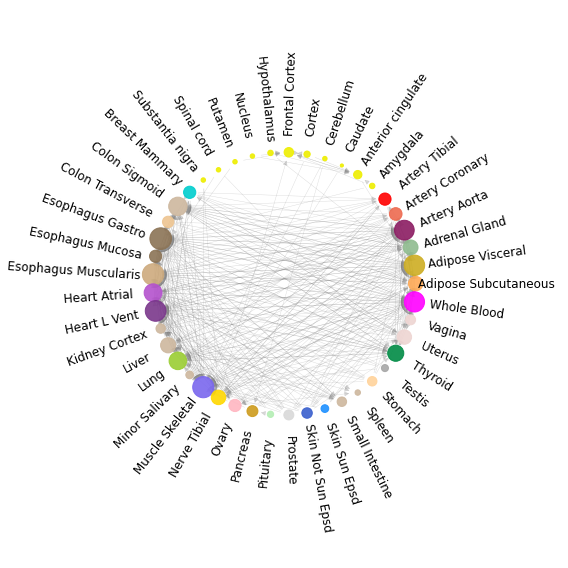

In [ ]:
colors = ['#ffaa56', '#cdad22', '#8fbc8f', '#8b1c62', '#ee6a50', '#ff0000', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#00cdcd', '#9ac0cd', '#ee82ee', '#cdb79e', '#eec591', '#8b7355', '#8b7355', '#cdaa7d',
          '#b452cd', '#7a378b', '#cdb79e', '#cdb79e', '#9acd32', '#cdb79e', '#7A67EE', '#FFD700', '#FFB6C1',
          '#CD9B1D', '#B4EEB4', '#D9D9D9', '#3A5FCD', '#1E90FF', '#CDB79E', '#CDB79E', '#FFD39B', '#A6A6A6',
          '#008B45', '#EED5D2', '#EED5D2', '#FF00FF']

fig = plt.figure(figsize=(8, 8))
threshold = 0.4
t2t_scores_ = t2t_scores * (1 - np.eye(t2t_scores.shape[0]))
G = nx.from_numpy_matrix(t2t_scores_ > threshold, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, tissue_dict_inv)
G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.circular_layout(G)  # 
# pos = nx.spring_layout(G, pos=pos, k=0.1, iterations=2)

edge_weights = np.array([t2t_scores[tissue_dict[u], tissue_dict[v]] for u,v in G.edges])
# edge_weights = 0.2 + 2*(edge_weights - np.min(edge_weights))/ (np.max(edge_weights) - np.min(edge_weights))
node_size = np.array([G.degree[u]*10 for u in G.nodes])
labels = {k: k.replace('_', ' ').replace('Brain ', '').replace(' Omentum', '').replace(' Tissue', '') for k in G.nodes.keys()}

color_map = [colors[tissue_dict[t]] for t in G.nodes]

# nx.draw(G, pos=pos, with_labels = True, width=weights)  # node_size=[d[k]*100 for k in d]
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_weights, edge_color="gray")
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=color_map, alpha=0.9)

labels_pos = {}
n = len(pos)
shiftval = 0.12
for i, (k, v) in enumerate(pos.items()):
    labels_pos[k] = pos[k] + np.sqrt(len(labels[k]))*np.array([shiftval * np.cos(i*2*np.pi/n), shiftval * np.sin(i*2*np.pi/n)])
    
    if k == 'Esophagus_Muscularis':
        labels_pos[k] += (-0.07, -0.01)
    elif k == 'Esophagus_Mucosa':
        labels_pos[k] += (-0.06, -0.0)
    elif k == 'Esophagus_Gastro':
        labels_pos[k] += (-0.06, +0.01)
    elif k == 'Colon_Transverse':
        labels_pos[k] += (-0.05, +0.02)
    elif k == 'Colon_Sigmoid':
        labels_pos[k] += (-0.04, +0.03)
    elif k == 'Breast_Mammary_Tissue':
        labels_pos[k] += (-0.03, +0.04)


text = nx.draw_networkx_labels(G, labels_pos, labels, font_size=12);
for i,(_,t) in enumerate(text.items()):
    angle = 360*i/len(text.items())
    if np.cos(angle*(np.pi/180)) < 0:
        angle = angle+180
    t.set_rotation(angle)

plt.gca().axis('off')

marginval = 0.9
x1,x2,y1,y2 = plt.axis()
plt.axis((x1-marginval,x2+marginval,y1-marginval,y2+marginval))
plt.tight_layout()
plt.savefig(f'figures/tissue_to_tissue_network_{threshold}cutoff_pergene.pdf', bbox_inches='tight');
